<h1> <img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwww.disneyclips.com%2Fimages%2Fimages%2Fminniereading.gif&f=1&nofb=1&ipt=2d646c9ccdbe2fe5aa37e902cd3a05cfa108c2d6137df09ac40418deb84aadc2" width="100"> <strong>Advanced Retrieval Strategies for Knowledge-Enhanced Chatbots</strong></h1>


```
Author: 🎤Lorenzo Molfetta, Stefano Fantazzini
Professor: Gianluca Moro

{name}.{surname}@unibo.it
```

_Alma Mater Studiorum Università di Bologna_

**Course**: TextMining & LLMs

**Research Group**: <mark><strong>UniboNLP@Cesena</strong></mark>

**Our website**: [link](https://disi-unibo-nlp.github.io)

<img src="https://drive.google.com/uc?export=view&id=1uskMMZ3v4QSDkC-eH5wTiTMmKiVfZFHs" width="300">





Modern information retrieval systems have evolved far beyond simple keyword matching and document ranking. In the era of Large Language Models, Retrieval-Augmented Generation (RAG) has emerged as a fundamental paradigm for building knowledge-aware AI systems that can access and synthesize information from vast document collections. However, the journey from basic retrieval to sophisticated, reasoning-capable chatbots presents numerous challenges and opportunities for optimization.

This notebook explores the evolution of RAG architectures, examining how we can progressively enhance information retrieval practices to build more intelligent and capable systems. We begin with foundational concepts in information retrieval, establishing the theoretical groundwork for understanding semantic search, embedding-based retrieval, and the challenges inherent in asymmetric query-document matching.


### Information Retrieval Foundations
We examine core principles of modern information retrieval, including:
- **Semantic Embedding Strategies**: Understanding how dense vector representations capture semantic meaning
- **Similarity Metrics and Ranking**: Evaluating different approaches to measuring document relevance
- **Retrieval Precision vs. Recall Trade-offs**: Balancing comprehensive coverage with focused relevance
- **Asymmetric Query Challenges**: Addressing the mismatch between short user queries and lengthy document content


### Reasoning-Enhanced Chatbot Systems
The culmination of our exploration focuses on integrating reasoning capabilities into RAG systems:
- **Base RAG Chatbots**: Implementing foundational query-retrieve-generate pipelines
- **ReAct (Reasoning and Acting) Frameworks**: Developing iterative systems that reason about information needs
- **Multi-Step Information Synthesis**: Building chatbots capable of handling complex, multi-faceted queries
- **Adaptive Retrieval Strategies**: Creating systems that dynamically adjust their information-gathering approach

## Index

1. [Install Libraries](#install_lib)
2. [Deploy Ollama model](#ollama)
3. [RAG Fundations](#baseRag)
4. [Graph-based RAG](#grag)
5. [BRIGHT: Retrieve w/ Reasoning](#bright)
6. [Retrieval-Enhnaced Chatbot](#ragchat)
7. [Reasoning Agentic Chatbot](#reasoningChatbot)

# 1. Install Libraries
<a name="install_lib"></a>

Enable GPU access on this notebook and then install the following libraries. After that, **restart the runtime**.

In [ ]:
%%shell
pip install -q datasets \
               pymilvus \
               milvus-lite \
               faiss-cpu \
               langchain \
               langchain-core \
               langchain-community \
               ollama \
               pydantic \
               dspy \
               langchain-ollama \
               kg-gen \
               pylate \
               evaluate \
               rouge_score \
               networkx  \
               matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 MB 14.7 MB/s eta 0:00:00


> ‼️ Restart runtime

Set random seed for reproducibility.

In [1]:
import os
import random
import numpy as np
import torch

seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set environment variable for reproducibility in some frameworks
os.environ["PYTHONHASHSEED"] = str(seed)

Let's import some test data for the following experiments.

In [2]:
!git clone https://github.com/disi-unibo-nlp/reasoning_rag_chatbot_agents.git

Cloning into 'reasoning_rag_chatbot_agents'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 75 (delta 20), reused 15 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (75/75), 2.84 MiB | 3.19 MiB/s, done.
Resolving deltas: 100% (20/20), done.


# 2. Local Open Source LLMs with Ollama
<a name="ollama"></a>


[`Ollama`](https://ollama.com) is a versatile platform that allows users to run LLMs directly on their local machines.

It runs as a background application and provides a straightforward command-line interface (CLI) and an Application Programming Interface (API) for interacting with various open-source LLMs.

It allows you to download the model of your choice from a wide array of [models](https://ollama.com/library?sort=newest) and perform offline AI usage, meaning that you can interact with and utilise LLMs even without an internet connection on your device.

### How do we start Ollama in Colab?

To run **Ollama** in Colab, we need access to a terminal in which we will perform our operations.

"Technically" Colab's built-in terminal is typically a Pro-only feature, however, we can work around this limitation thanks to the `colab-xterm` extension!

This allows us to open a terminal directly inside the notebook.




In [ ]:
!pip install -q colab-xterm==0.2.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.6/115.6 kB 3.7 MB/s eta 0:00:00


In [ ]:
%load_ext colabxterm

Now let's deploy the model and make it accessible through API calls to a local address.

**RUN** the cell below to create a separate shell in background. Then, inside it, run the following commands:
- `curl -fsSL https://ollama.com/install.sh | sh` to download and configure ollama (you can ignore warnings);
- `ollama serve >/dev/null 2>&1 &` to deploy the ollama server endpoint for user requests
- (reasoning model) `ollama pull qwen3:1.7b` to download the qwen model (or `ollama run qwen3:1.7b` to interact with the model via shell);
- `ollama pull llama3.2:3b` to download Llama;
- `ollama pull bge-m3` to download an encoder model for retrieval.

You can ignore warnings.


For this laboratory, we shall mainly use `qwen3:1.7b`. You can change model simply by changing the name after `run` (e.g. "mistral", "llama3.1:8b-instruct-q8_0").

> ollama pull qwen3:1.7b && ollama pull llama3.2:3b && granite4:micro-h && ollama pull bge-m3

In [ ]:
%xterm

> Once the models finish downloading, you can list all the currently available models on your machine with `ollama list`


In [5]:
!ollama list

NAME    ID    SIZE    MODIFIED 


> ‼️ **NOTE** ‼️: Remember to launch the above terminal and `ollama serve` everytime you restart the colab environment.

### Reasoning with local LLMs

To make it easier to interact with our language models, we'll define a function that sends the question to the wanted model and neatly displays the reasoning steps (if available from the model) and final answer.

In [2]:
from langchain_core.prompts import ChatPromptTemplate
from IPython.display import Markdown, display
import re

def ask_and_display_response(model, question, template=None, display_answer=True):
    """
    Send a question to a model using and display the model's response.

    Args:
        model: A LangChain-Ollama compatible LLM.
        question (str): The user prompt.
        template (str): A template that defines the prompt' structure.

    Returns:
        dict: A dictionary with keys:
              - 'thinking': The model's reasoning (if available).
              - 'answer': The final response.
    """
    if template is None:
      template = """{question}"""

    # Step 1: Build the prompt chain from the template
    prompt = ChatPromptTemplate.from_template(template)
    # Combine prompt and model into a callable pipeline
    chain = prompt | model

    # Step 2: Call the model with the question
    response = chain.invoke({"question": question})

    # Step 3: Extract reasoning enclosed in <think>...</think> (if present)
    think_match = re.search(r"<think>(.*?)</think>", response, re.DOTALL)
    thinking = think_match.group(1).strip() if think_match else None

    # Step 4: Remove reasoning tags and content to isolate the final answer
    final_answer = re.sub(r"<think>.*?</think>", "", response, flags=re.DOTALL).strip()

    # Step 5: Display results in using Markdown
    if display_answer:
      if thinking:
          display(Markdown(f"### 🧠 Model Thinking\n```\n{thinking}\n```"))
      display(Markdown(f"### 🤖 Final Answer\n{final_answer}"))

    return {"thinking": thinking, "answer": final_answer}


Let's try some reasoning task to see how LLMs have evolved.

In [ ]:
from langchain_ollama.llms import OllamaLLM

# Load the model downloaded locally
# The model name must match one installed or available in your Ollama setup!
model_llm = OllamaLLM(model="qwen3:1.7b")

# Define the question (prompt) you want to ask
question = """
If a brick weighs 1 kilo plus half a brick, how much does a brick weigh?
"""

# Send the question through the model using the helper function
result = ask_and_display_response(model_llm, question)

### 🤖 Final Answer
To determine the weight of a brick, we are given the equation:

> A brick weighs 1 kilo plus half a brick.

Let’s denote the weight of a brick in kilograms as $ x $. According to the problem:

$$
x = 1 + \frac{1}{2}x
$$

---

### Step 1: Solve the Equation

We want to isolate $ x $. Subtract $ \frac{1}{2}x $ from both sides:

$$
x - \frac{1}{2}x = 1
$$

This simplifies to:

$$
\frac{1}{2}x = 1
$$

Now, multiply both sides by 2 to solve for $ x $:

$$
x = 2
$$

---

### Step 2: Verify the Solution

If a brick weighs 2 kilograms, then half a brick weighs:

$$
\frac{1}{2} \times 2 = 1 \text{ kilogram}
$$

So, the total weight is:

$$
1 + 1 = 2 \text{ kilograms}
$$

This confirms that the equation holds true.

---

### Final Answer

The weight of a brick is:

$$
\boxed{2}
$$

# 3. RAG Fundations
<a name="baseRag"></a>

Now let's implement a very basic RAG pipeline based on semantic similarity.

In [ ]:
import numpy as np

from collections import defaultdict
from scipy.sparse import csr_matrix
from pymilvus import MilvusClient
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain_ollama import OllamaEmbeddings


from tqdm import tqdm

We shall use Milvus, the most efficient open-source vector database currently available.

In [ ]:
milvus_client = MilvusClient(uri="./milvus.db")

embedding_model = OllamaEmbeddings(
    model="bge-m3",
)

/usr/local/lib/python3.12/dist-packages/milvus_lite/__init__.py:15: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Let's create some dummy instances.

In [ ]:
nano_dataset = [
    {
        "passage": "Jakob Bernoulli (1654–1705): Jakob was one of the earliest members of the Bernoulli family to gain prominence in mathematics. He made significant contributions to calculus, particularly in the development of the theory of probability. He is known for the Bernoulli numbers and the Bernoulli theorem, a precursor to the law of large numbers. He was the older brother of Johann Bernoulli, another influential mathematician, and the two had a complex relationship that involved both collaboration and rivalry.",
        "triplets": [
            ["Jakob Bernoulli", "made significant contributions to", "calculus"],
            [
                "Jakob Bernoulli",
                "made significant contributions to",
                "the theory of probability",
            ],
            ["Jakob Bernoulli", "is known for", "the Bernoulli numbers"],
            ["Jakob Bernoulli", "is known for", "the Bernoulli theorem"],
            ["The Bernoulli theorem", "is a precursor to", "the law of large numbers"],
            ["Jakob Bernoulli", "was the older brother of", "Johann Bernoulli"],
        ],
    },
    {
        "passage": "Johann Bernoulli (1667–1748): Johann, Jakob’s younger brother, was also a major figure in the development of calculus. He worked on infinitesimal calculus and was instrumental in spreading the ideas of Leibniz across Europe. Johann also contributed to the calculus of variations and was known for his work on the brachistochrone problem, which is the curve of fastest descent between two points.",
        "triplets": [
            [
                "Johann Bernoulli",
                "was a major figure of",
                "the development of calculus",
            ],
            ["Johann Bernoulli", "was", "Jakob's younger brother"],
            ["Johann Bernoulli", "worked on", "infinitesimal calculus"],
            ["Johann Bernoulli", "was instrumental in spreading", "Leibniz's ideas"],
            ["Johann Bernoulli", "contributed to", "the calculus of variations"],
            ["Johann Bernoulli", "was known for", "the brachistochrone problem"],
        ],
    },
    {
        "passage": "Daniel Bernoulli (1700–1782): The son of Johann Bernoulli, Daniel made major contributions to fluid dynamics, probability, and statistics. He is most famous for Bernoulli’s principle, which describes the behavior of fluid flow and is fundamental to the understanding of aerodynamics.",
        "triplets": [
            ["Daniel Bernoulli", "was the son of", "Johann Bernoulli"],
            ["Daniel Bernoulli", "made major contributions to", "fluid dynamics"],
            ["Daniel Bernoulli", "made major contributions to", "probability"],
            ["Daniel Bernoulli", "made major contributions to", "statistics"],
            ["Daniel Bernoulli", "is most famous for", "Bernoulli’s principle"],
            [
                "Bernoulli’s principle",
                "is fundamental to",
                "the understanding of aerodynamics",
            ],
        ],
    },
    {
        "passage": "Leonhard Euler (1707–1783) was one of the greatest mathematicians of all time, and his relationship with the Bernoulli family was significant. Euler was born in Basel and was a student of Johann Bernoulli, who recognized his exceptional talent and mentored him in mathematics. Johann Bernoulli’s influence on Euler was profound, and Euler later expanded upon many of the ideas and methods he learned from the Bernoullis.",
        "triplets": [
            [
                "Leonhard Euler",
                "had a significant relationship with",
                "the Bernoulli family",
            ],
            ["leonhard Euler", "was born in", "Basel"],
            ["Leonhard Euler", "was a student of", "Johann Bernoulli"],
            ["Johann Bernoulli's influence", "was profound on", "Euler"],
        ],
    },
]


We can now insert them into Milvus.

In [ ]:
entityid_2_relationids = defaultdict(list)
relationid_2_passageids = defaultdict(list)

entities = []
relations = []
passages = []
for passage_id, dataset_info in enumerate(nano_dataset):
    passage, triplets = dataset_info["passage"], dataset_info["triplets"]
    passages.append(passage)
    for triplet in triplets:
        if triplet[0] not in entities:
            entities.append(triplet[0])
        if triplet[2] not in entities:
            entities.append(triplet[2])
        relation = " ".join(triplet)
        if relation not in relations:
            relations.append(relation)
            entityid_2_relationids[entities.index(triplet[0])].append(
                len(relations) - 1
            )
            entityid_2_relationids[entities.index(triplet[2])].append(
                len(relations) - 1
            )
        relationid_2_passageids[relations.index(relation)].append(passage_id)

Finally, we can create some Milvus collections (a sort of table of the relational paradigm).

In [ ]:
embedding_dim = len(embedding_model.embed_query("foo"))


def create_milvus_collection(collection_name: str):
    if milvus_client.has_collection(collection_name=collection_name):
        milvus_client.drop_collection(collection_name=collection_name)

    milvus_client.create_collection(
        collection_name=collection_name,
        dimension=embedding_dim,
        consistency_level="Strong",  # Supported values are (`"Strong"`, `"Session"`, `"Bounded"`, `"Eventually"`). See https://milvus.io/docs/consistency.md#Consistency-Level for more details.
    )

# Create separate collection for each data format
entity_col_name = "entity_collection"
relation_col_name = "relation_collection"
passage_col_name = "passage_collection"

create_milvus_collection(entity_col_name)
create_milvus_collection(relation_col_name)
create_milvus_collection(passage_col_name)

.. and embed and upload data.

In [ ]:
def milvus_insert(
    collection_name: str,
    text_list: list[str],
):
    batch_size = 512
    for row_id in tqdm(range(0, len(text_list), batch_size), desc="Inserting"):
        batch_texts = text_list[row_id : row_id + batch_size]
        batch_embeddings = embedding_model.embed_documents(batch_texts)

        batch_ids = [row_id + j for j in range(len(batch_texts))]
        batch_data = [
            {
                "id": id_,
                "text": text,
                "vector": vector,
            }
            for id_, text, vector in zip(batch_ids, batch_texts, batch_embeddings)
        ]
        milvus_client.insert(
            collection_name=collection_name,
            data=batch_data,
        )


milvus_insert(
    collection_name=relation_col_name,
    text_list=relations,
)

milvus_insert(
    collection_name=entity_col_name,
    text_list=entities,
)

milvus_insert(
    collection_name=passage_col_name,
    text_list=passages,
)


Inserting: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


### Similarity Retrieval

Retrieval by similarity follow the steps below.

In [ ]:
query = "What contribution did the son of Euler's teacher make?"

query_ner_list = ["Euler"]

# 1. Encode the query into a vector
query_embedding = embedding_model.embed_query(query)


# 2. Perform cosinie-similarity with the embeddings in the database
top_k = 3

relation_search_res = milvus_client.search(
    collection_name="passage_collection",
    data=[query_embedding],
    limit=top_k,
    output_fields=["text"],
)[0]

In [ ]:
relation_search_res

[{'id': 3, 'distance': 0.5317320823669434, 'entity': {'text': 'Leonhard Euler (1707–1783) was one of the greatest mathematicians of all time, and his relationship with the Bernoulli family was significant. Euler was born in Basel and was a student of Johann Bernoulli, who recognized his exceptional talent and mentored him in mathematics. Johann Bernoulli’s influence on Euler was profound, and Euler later expanded upon many of the ideas and methods he learned from the Bernoullis.'}}, {'id': 2, 'distance': 0.4642852246761322, 'entity': {'text': 'Daniel Bernoulli (1700–1782): The son of Johann Bernoulli, Daniel made major contributions to fluid dynamics, probability, and statistics. He is most famous for Bernoulli’s principle, which describes the behavior of fluid flow and is fundamental to the understanding of aerodynamics.'}}, {'id': 1, 'distance': 0.43008953332901, 'entity': {'text': 'Johann Bernoulli (1667–1748): Johann, Jakob’s younger brother, was also a major figure in the developm

In [ ]:
import json

for res in relation_search_res:
  print("="*50)
  res_dict = dict(res)
  print(json.dumps(res_dict, indent=4))

{
    "id": 3,
    "distance": 0.5317320823669434,
    "entity": {
        "text": "Leonhard Euler (1707\u20131783) was one of the greatest mathematicians of all time, and his relationship with the Bernoulli family was significant. Euler was born in Basel and was a student of Johann Bernoulli, who recognized his exceptional talent and mentored him in mathematics. Johann Bernoulli\u2019s influence on Euler was profound, and Euler later expanded upon many of the ideas and methods he learned from the Bernoullis."
    }
}
{
    "id": 2,
    "distance": 0.4642852246761322,
    "entity": {
        "text": "Daniel Bernoulli (1700\u20131782): The son of Johann Bernoulli, Daniel made major contributions to fluid dynamics, probability, and statistics. He is most famous for Bernoulli\u2019s principle, which describes the behavior of fluid flow and is fundamental to the understanding of aerodynamics."
    }
}
{
    "id": 1,
    "distance": 0.43008953332901,
    "entity": {
        "text": "Johann 

### Reranking: Encoders vs. LLMs

Reranking is a crucial post-retrieval step in RAG systems that refines the initial ranking of retrieved documents to improve relevance quality. While retrievers excel at quickly finding potentially relevant chunks from large knowledge bases, they often struggle with nuanced semantic matching and may return documents with varying relevance scores. Reranking addresses this by applying more sophisticated models to the smaller set of retrieved candidates, aiming to push the most relevant documents to the top positions where they're more likely to be used for generation. When implementing reranking, practitioners must choose between two primary approaches:

**Encoder Rerankers**
• Computationally efficient and fast
• Effective when properly trained on relevant data
• Limited by initial retrieval quality - if the retriever model didn't spot differences between chunks, the reranker struggles too
• Performance degrades outside pretraining domain due to lack of nuanced understanding

**LLM Rerankers**
• Excel at exploiting semantic relationships and contextual understanding
• Can recover from poor initial retrieval by recognizing subtle relevance patterns
• Less efficient - require additional model calls introducing latency
• Add complexity to production systems, especially problematic for high-throughput applications

The choice ultimately comes down to balancing accuracy gains against computational costs and system complexity.

Let's briefly see how to define a prompt for this task.

In [ ]:
from langchain_ollama.llms import OllamaLLM

llm = OllamaLLM(model="qwen3:1.7b")

#### Experiment: LLM-Based Relation Reranking

In [ ]:
query_prompt_one_shot_input = """I will provide you with a list of relationship descriptions. Your task is to select 3 relationships that may be useful to answer the given question. Please return a JSON object containing your thought process and a list of the selected relationships in order of their relevance.

Question:
When was the mother of the leader of the Third Crusade born?

Relationship descriptions:
[1] Eleanor was born in 1122.
[2] Eleanor married King Louis VII of France.
[3] Eleanor was the Duchess of Aquitaine.
[4] Eleanor participated in the Second Crusade.
[5] Eleanor had eight children.
[6] Eleanor was married to Henry II of England.
[7] Eleanor was the mother of Richard the Lionheart.
[8] Richard the Lionheart was the King of England.
[9] Henry II was the father of Richard the Lionheart.
[10] Henry II was the King of England.
[11] Richard the Lionheart led the Third Crusade.

"""
query_prompt_one_shot_output = """{"thought_process": "To answer the question about the birth of the mother of the leader of the Third Crusade, I first need to identify who led the Third Crusade and then determine who his mother was. After identifying his mother, I can look for the relationship that mentions her birth.",
"useful_relationships": ["[11] Richard the Lionheart led the Third Crusade", "[7] Eleanor was the mother of Richard the Lionheart", "[1] Eleanor was born in 1122"]}"""

query_prompt_template = """
### Instructions

Return a JSON object containing your thought process and a list of the selected relationships in order of their relevance and following the example below:
```json
{{
  "thought_process": "To answer the question about ....",
  "useful_relationships": [
    [0],
    [1],
    ...
  ]
}}
```
### Input

I will provide you with a list of relationship descriptions. Your task is to select 3 relationships that may be useful to answer the given question. Please return a JSON object containing your thought process and a list of the selected relationships in order of their relevance.

Relationship descriptions:
{relation_des_str}

Now answer the following question:

{question}
"""


def rerank_relations(
    query: str, relation_candidate_texts: list[str], relation_candidate_ids: list[str]
) -> list[int]:
    relation_des_str = "\n".join(
        map(
            lambda item: f"[{item[0]}] {item[1]}",
            zip(relation_candidate_ids, relation_candidate_texts),
        )
    ).strip()

    id_to_text = dict(zip(relation_candidate_ids, relation_candidate_texts))

    rerank_prompts = ChatPromptTemplate.from_messages(
        [
            HumanMessage(query_prompt_one_shot_input),
            AIMessage(query_prompt_one_shot_output),
            HumanMessagePromptTemplate.from_template(query_prompt_template),
        ]
    )
    rerank_chain = rerank_prompts | llm
    rerank_res = rerank_chain.invoke(
        {"question": query, "relation_des_str": relation_des_str}
    )

    rerank_relation_ids = []
    rerank_res_content = rerank_res.content if hasattr(rerank_res, 'content') else str(rerank_res)

    try:
        if "```json" in rerank_res_content:
            json_str = rerank_res_content.split("```json")[-1].split("```")[0].strip()
            out_json = eval(json_str)
        elif "{" in rerank_res_content and "}" in rerank_res_content:
            start_idx = rerank_res_content.find("{")
            end_idx = rerank_res_content.rfind("}") + 1
            json_str = rerank_res_content[start_idx:end_idx]
            out_json = eval(json_str)
        else:
            return []
    except Exception:
        return []

    rerank_relation_lines = out_json.get("useful_relationships", [])

    for line in rerank_relation_lines:
        if isinstance(line, str):
            rel_id = int(line.split(']')[0].strip('['))
        else:
            rel_id = int(line[0])
        rerank_relation_ids.append(rel_id)

    return rerank_relation_ids, out_json.get('thought_process', ''), id_to_text

In [ ]:
relation_search_res_for_rerank = milvus_client.search(
    collection_name="relation_collection",
    data=[query_embedding],
    limit=5,
    output_fields=["text"],
)[0]


# print top-k elements and their similarity scores
print("Top-k retrieved relations for reranking:")
for res in relation_search_res_for_rerank:
    res_dict = dict(res)
    print(json.dumps(res_dict, indent=4))

print("="*30)

# Rerank relations using LLM
relation_candidate_texts = [res['entity']['text'] for res in relation_search_res_for_rerank]
relation_candidate_ids = [res['id'] for res in relation_search_res_for_rerank]

rerank_relation_ids, llm_reasoning, id_to_text = rerank_relations(
    query,
    relation_candidate_texts=relation_candidate_texts,
    relation_candidate_ids=relation_candidate_ids,
)

Top-k retrieved relations for reranking:
{
    "id": 20,
    "distance": 0.5714835524559021,
    "entity": {
        "text": "Leonhard Euler was a student of Johann Bernoulli"
    }
}
{
    "id": 21,
    "distance": 0.5401729941368103,
    "entity": {
        "text": "Johann Bernoulli's influence was profound on Euler"
    }
}
{
    "id": 18,
    "distance": 0.5232967734336853,
    "entity": {
        "text": "Leonhard Euler had a significant relationship with the Bernoulli family"
    }
}
{
    "id": 19,
    "distance": 0.47815656661987305,
    "entity": {
        "text": "leonhard Euler was born in Basel"
    }
}
{
    "id": 12,
    "distance": 0.4507191777229309,
    "entity": {
        "text": "Daniel Bernoulli was the son of Johann Bernoulli"
    }
}


In [ ]:
print(rerank_relation_ids)

[12, 20, 19]


In [ ]:
print(llm_reasoning)

To answer the question, I first need to identify who the son of Euler's teacher is. Leonhard Euler's teacher was Johann Bernoulli. Daniel Bernoulli was Johann Bernoulli's son (relationship [12]). The question asks about the contribution of this son, which is Daniel Bernoulli's work in fluid dynamics (Bernoulli equation). Relevant relationships include [12] (son of the teacher), [20] (Euler's teacher), and [19] (Euler's birthplace, though not directly relevant to the contribution).


# 4. Graph-based RAG
<a name="grag"></a>

**Traditional RAG** systems typically rely on **semantic similarity**. They embed a user's query and a large corpus of documents into a vector space, then retrieve the document chunks closest to the query. While effective, this approach has limitations:

1. **Context Fragmentation**: It retrieves isolated pieces of information without understanding their underlying relationships.
2. **Limited Reasoning**: It cannot easily traverse multiple steps of logic or follow chains of reasoning.
3. **Missing Connections**: Related facts scattered across different chunks may not be retrieved together.
4. **No Structural Understanding**: Vector similarity doesn't capture the explicit relationships between entities and concepts.

**Graph-based RAG** addresses these issues by representing knowledge as an **entity-directed graph**, where nodes are concepts/entities and edges are relationships. This structure allows retrieval algorithms to:

- **Explore connections** between related concepts
- **Traverse reasoning paths** through multiple hops
- **Discover context** that would be missed by simple vector similarity
- **Follow explicit relationships** rather than relying solely on semantic proximity


| Aspect | **Vector-based RAG** | **Graph-based RAG** |
|--------|---------------------|---------------------|
| **Knowledge Representation** | Flat vector embeddings of text chunks | Knowledge graph with entities (nodes) and relationships (edges) |
| **Retrieval Strategy** | Semantic similarity (cosine distance) | Graph traversal, path finding, community detection |
| **Context Assembly** | Top-k most similar chunks | Connected subgraphs, reasoning paths, or community summaries |
| **Reasoning Capability** | Single-hop similarity matching | Multi-hop reasoning through graph traversal |
| **Relationship Awareness** | Implicit (through embeddings) | Explicit (through typed edges) |


Graph-based RAG excels when queries require:

1. **Multi-hop Reasoning**: "What is the relationship between X's teacher and Y's employer?"
   - Traditional RAG: Retrieves chunks about X and chunks about Y separately
   - Graph RAG: Follows graph edges from X → X's teacher → connection → Y's employer → Y

2. **Structured Knowledge Navigation**: Following explicit relationships like "works_for", "located_in", "invented_by"
   - Traditional RAG: Must infer relationships from semantic similarity
   - Graph RAG: Traverses typed edges representing actual relationships

3. **Contextual Expansion**: Finding related entities by traversing graph neighborhoods
   - Traditional RAG: May miss related entities not semantically similar to query
   - Graph RAG: Discovers related entities through graph connectivity

4. **Complex Question Answering**: Questions requiring connecting multiple facts through intermediate entities
   - Traditional RAG: Struggles with questions needing synthesis across multiple chunks
   - Graph RAG: Assembles reasoning chains by following graph paths

### Overview

In this section, we'll explore three distinct graph-based RAG methodologies, each with different trade-offs:

1. **GraphRAG**:
   - **Approach**: Hierarchical community detection with LLM-generated summaries
   - **Strengths**: Excellent for global synthesis queries, handles entire datasets
   - **Use Cases**: Research questions, thematic analysis, broad knowledge synthesis

2. **LightRAG**:
   - **Approach**: Efficient k-hop subgraph expansion around query entities
   - **Strengths**: Fast, simple, broad context gathering
   - **Use Cases**: Entity-centric queries needing surrounding context

3. **PathRAG**:
   - **Approach**: Explicit reasoning path discovery with reliability scoring
   - **Strengths**: High interpretability, multi-hop reasoning chains
   - **Use Cases**: Questions requiring step-by-step logical connections

In [ ]:
import sys
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter, deque
import time
import warnings
import heapq
from typing import List, Dict, Tuple, Set, Optional, Any
import re
import random
from itertools import combinations
import json
import pickle
from dataclasses import dataclass


import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import tempfile

from sentence_transformers import SentenceTransformer
import psutil
import evaluate
import pandas as pd
import ollama

warnings.filterwarnings('ignore')

### Data and Utils

In [ ]:
@dataclass
class Node:
    """Node data structure for LightRAG"""
    id: str
    identifier: str
    embedding: Optional[np.ndarray] = None

@dataclass
class Path:
    """Represents a path through the graph, used by PathRAG"""
    nodes: List[str]
    edges: List[Tuple[str, str]]
    reliability_score: float

    def __len__(self):
        return len(self.edges)

@dataclass
class EdgeWithRelation:
    """Edge with relationship information"""
    source: str
    target: str
    relation: Optional[str] = None

    def to_tuple(self) -> Tuple[str, str]:
        """Convert to simple tuple for compatibility"""
        return (self.source, self.target)

@dataclass
class SubGraph:
    """SubGraph result structure with relationship information"""
    nodes: List[str]
    edges: List[Tuple[str, str]]  # Simple edges for backward compatibility
    edges_with_relations: List[EdgeWithRelation]  # Edges with relationship names
    relationships: Dict[Tuple[str, str], str]  # Map from edge tuple to relationship name
    relevance_score: float

print("Data classes defined successfully!")

Data classes defined successfully!


In [ ]:
def load_jsonl_file(file_path: str) -> List[Dict]:
    """Load data from JSONL file"""
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line:
                data.append(json.loads(line))
    return data

def load_pickle_file(file_path: str) -> Any:
    """Load data from a pickle file"""
    with open(file_path, 'rb') as f:
        return pickle.load(f)

In [ ]:
def visualize_graph(G, title="NetworkX Graph",
                    figsize=(12, 8),
                    node_color='lightblue',
                    edge_color='black',
                    with_labels=True,
                    font_size=8,
                    node_size=500,
                    with_edge_labels=True,
                    edge_font_size=6):
    """
    Visualize NetworkX graph using matplotlib
    """
    plt.figure(figsize=figsize)

    # Choose layout
    if len(G.nodes()) < 50:
        pos = nx.spring_layout(G, k=1, iterations=50)
    else:
        pos = nx.kamada_kawai_layout(G)

    # Draw the graph
    nx.draw(G, pos,
            node_color=node_color,
            edge_color=edge_color,
            with_labels=with_labels,
            font_size=font_size,
            node_size=node_size,
            alpha=0.7,
            arrows=True if G.is_directed() else False,
            arrowsize=20)

    # Draw edge labels if requested
    if with_edge_labels:
        # Get edge labels (use edge attributes if available, otherwise show edge tuple)
        edge_labels = {}
        for edge in G.edges(data=True):
            if len(edge) == 3 and edge[2]:  # Has edge attributes
                # Try common attribute names for edge labels
                if 'weight' in edge[2]:
                    edge_labels[(edge[0], edge[1])] = edge[2]['weight']
                elif 'label' in edge[2]:
                    edge_labels[(edge[0], edge[1])] = edge[2]['label']
                elif 'name' in edge[2]:
                    edge_labels[(edge[0], edge[1])] = edge[2]['name']
                else:
                    # Use the first attribute value
                    edge_labels[(edge[0], edge[1])] = list(edge[2].values())[0]
            else:
                # No attributes, show edge as tuple
                edge_labels[(edge[0], edge[1])] = f"{edge[0]}-{edge[1]}"

        nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=edge_font_size)

    plt.title(title, fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
HOTPOTQA_FILE_PATH = 'reasoning_rag_chatbot_agents/data/hotpotqa_sample.jsonl'
SUPPORTING_FACTS_GRAPHS_PATH = 'reasoning_rag_chatbot_agents/data/supporting_facts_graphs_all_graphs_v2.pkl' # Using supporting facts as KG
QUESTION_GRAPHS_PATH = 'reasoning_rag_chatbot_agents/data/question_graphs_all_graphs_v2.pkl' # Using question graphs for entity extraction

hotpotqa_data_full = load_jsonl_file(HOTPOTQA_FILE_PATH)
print(f"Loaded {len(hotpotqa_data_full)} items from {HOTPOTQA_FILE_PATH}")

# Load pre-generated supporting facts graphs
supporting_facts_graphs_data_list = load_pickle_file(SUPPORTING_FACTS_GRAPHS_PATH)
print(f"Loaded {len(supporting_facts_graphs_data_list)} graph structures from {SUPPORTING_FACTS_GRAPHS_PATH}")

# Load pre-generated question graphs for entity extraction
question_graphs_data_list = load_pickle_file(QUESTION_GRAPHS_PATH)
print(f"Loaded {len(question_graphs_data_list)} question graph structures from {QUESTION_GRAPHS_PATH}")

Loaded 100 items from reasoning_rag_chatbot_agents/data/hotpotqa_sample.jsonl
Loaded 96 graph structures from reasoning_rag_chatbot_agents/data/supporting_facts_graphs_all_graphs_v2.pkl
Loaded 100 question graph structures from reasoning_rag_chatbot_agents/data/question_graphs_all_graphs_v2.pkl


In [ ]:
# filter empty graphs
hotpotqa_data_filtered = []
supporting_facts_graphs_filtered = []
question_graphs_filtered = []

for graph_item_dict in supporting_facts_graphs_data_list:
    original_index = graph_item_dict.get("index")

    if original_index is None:
        continue

    # Get the corresponding graphs
    supp_nx_graph = graph_item_dict.get('nx_graph')
    q_graph_item_dict = question_graphs_data_list[original_index]
    q_nx_graph = q_graph_item_dict.get('nx_graph')

    assert q_graph_item_dict["index"] == original_index

    if (supp_nx_graph and isinstance(supp_nx_graph, nx.Graph) and len(supp_nx_graph.nodes()) > 0 and
        q_nx_graph and isinstance(q_nx_graph, nx.Graph) and len(q_nx_graph.nodes()) > 0):

        hotpotqa_data_filtered.append(hotpotqa_data_full[original_index])
        supporting_facts_graphs_filtered.append(graph_item_dict)
        question_graphs_filtered.append(q_graph_item_dict)
    else:
        print(f"Skipping question with original index {original_index} due to empty or invalid graph.")

hotpotqa_data = hotpotqa_data_filtered
supporting_facts_graphs_data_list = supporting_facts_graphs_filtered
question_graphs_data_list = question_graphs_filtered

In [ ]:
print(json.dumps(hotpotqa_data[0], indent=3))

{
   "question": "Were Scott Derrickson and Ed Wood of the same nationality?",
   "answer": "yes",
   "supporting_facts": [
      [
         "Scott Derrickson",
         0
      ],
      [
         "Ed Wood",
         0
      ]
   ],
   "context": "Adam Collis: Adam Collis is an American filmmaker and actor.  He attended the Duke University from 1986 to 1990 and the University of California, Los Angeles from 2007 to 2010.  He also studied cinema at the University of Southern California from 1991 to 1997.  Collis first work was the assistant director for the Scott Derrickson's short \"Love in the Ruins\" (1995).  In 1998, he played \"Crankshaft\" in Eric Koyanagi's \"Hundred Percent\".\nEd Wood (film): Ed Wood is a 1994 American biographical period comedy-drama film directed and produced by Tim Burton, and starring Johnny Depp as cult filmmaker Ed Wood.  The film concerns the period in Wood's life when he made his best-known films as well as his relationship with actor Bela Lugosi, play

## Synthetic Entity Extraction
You can use the [KG-Gen](https://github.com/stair-lab/kg-gen) library to synthetically extract entities and relationships from plain text.

In [ ]:
from kg_gen import KGGen
import warnings


kg = KGGen(
    model="ollama_chat/granite4:micro-h",
    api_base="http://127.0.0.1:11434"
)

In [ ]:
from tqdm import tqdm

sentences = [
    """CrissCross is a 1992 American drama film directed by Chris Menges and written by Scott Sommer, based on his homonymous novel.
    It stars Goldie Hawn, Arliss Howard, Keith Carradine, Steve Buscemi, and David Arnott.""",
    """Made in Britain: Made in Britain is a 1982 British television play written by David Leland, and directed by Alan Clarke, about a 16-year-old racist skinhead named Trevor,
    and his constant confrontations with authority figures.""",
    """It was originally broadcast on ITV on 10 July 1983 as fourth in an untitled series of works by Leland (including "Birth of a Nation"),
    loosely based around the British educational system, which subsequently acquired the overall title of "Tales Out of School". """
]
tot_graph = None

for sent in tqdm(sentences):
  try:
    this_graph = kg.generate(
      input_data=sent,
      chunk_size=300,
      temperature=0.2
    )
    if tot_graph is None:
      tot_graph = this_graph
    else:
      tot_graph = kg.aggregate([this_graph, tot_graph])
  except:
    print("Skipping sentence:",sent)

100%|██████████| 3/3 [00:18<00:00,  6.05s/it]


In [ ]:
kg_data = tot_graph.__dict__

for k in kg_data:
  print(f"************ {k.upper()} ************")
  if kg_data[k]:
    for el in kg_data[k]:
      print(el)

************ ENTITIES ************
Leland
Alan Clarke
David Arnott
director Chris Menges
David Leland
novel by Scott Sommer
Made in Britain
ITV
1992 American drama film
CrissCross
writer Scott Sommer
Keith Carradine
Trevor
Steve Buscemi
Goldie Hawn
Arliss Howard
************ EDGES ************
was written by
is written by
was directed by
is based on
created series titled
is a
broadcast on
is directed by
stars
************ RELATIONS ************
('ITV', 'broadcast on', '10 July 1983')
('CrissCross', 'stars', 'Arliss Howard')
('CrissCross', 'was written by', 'Scott Sommer')
('Trevor', 'is a', '16-year-old racist skinhead')
('Leland', 'created series titled', 'Tales Out of School')
('CrissCross', 'is based on', 'novel by Scott Sommer')
('CrissCross', 'stars', 'Goldie Hawn')
('CrissCross', 'stars', 'Keith Carradine')
('CrissCross', 'stars', 'David Arnott')
('CrissCross', 'was directed by', 'Chris Menges')
('Made in Britain', 'is written by', 'David Leland')
('CrissCross', 'is a', '1992 Ame

In [ ]:
print("Clustering similar entities and relationships")
graph = kg.cluster(
  tot_graph
)

Clustering similar entities and relationships


In [ ]:
graph

Graph(entities={'CrissCross'}, edges={'"broadcast"', 'is written by', 'based', 'stars'}, relations={('CrissCross', 'stars', 'Tales Out of School'), ('CrissCross', 'stars', 'CrissCross'), ('CrissCross', 'is written by', 'Chris Menges'), ('CrissCross', 'is written by', 'CrissCross'), ('CrissCross', '"broadcast"', '10 July 1983'), ('CrissCross', 'is written by', 'Scott Sommer'), ('CrissCross', 'based', 'CrissCross'), ('CrissCross', '"broadcast"', '16-year-old racist skinhead'), ('CrissCross', '"broadcast"', 'CrissCross')}, entity_clusters={'CrissCross': {'Leland', 'Alan Clarke', 'David Arnott', 'director Chris Menges', 'David Leland', 'novel by Scott Sommer', 'Made in Britain', 'ITV', 'Arliss Howard', '1992 American drama film', 'CrissCross', 'writer Scott Sommer', 'Trevor', 'Steve Buscemi', 'Goldie Hawn', 'Keith Carradine'}}, edge_clusters={'is written by': {'was written by', 'is written by', 'is directed by', 'was directed by'}, 'based': {'is based on'}, 'stars': {'created series titled

# GraphRAG: Hierarchical Community-Based Retrieval
<a name="microsoft-graphrag"></a>


Developed by Microsoft Research, [**GraphRAG**](https://arxiv.org/pdf/2404.16130) fundamentally rethinks how we can leverage graph structures for retrieval-augmented generation. The methodology is implemented through the **`GraphRetriever`** class, which handles the retrieval operations.


Rather than performing real-time graph traversal during queries (like traditional graph databases), GraphRAG:
- Uses graphs as an **intermediate representation during indexing**
- Retrieves via **hierarchical community detection and summarization**
- Employs a **preprocessing-heavy strategy** for query-time efficiency

<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fmiro.medium.com%2Fv2%2Fresize%3Afit%3A894%2F1*MwcADsr42InEH0-aDzbR4w.png&f=1&nofb=1&ipt=f6674bbfd3d41cee8dd78d85218636be1c2ba42cab8019ac3f04c79597b2afa1" width="600">


## Why GraphRAG?

Traditional RAG systems face several fundamental challenges:

1. **Limited Context Understanding**: Vector-based retrieval treats documents as isolated semantic units, missing the rich relationships and connections between concepts.

2. **Poor Global Reasoning**: When queries require understanding broad themes or synthesizing information across many documents, simple similarity search fails to capture the big picture.

3. **Inability to Follow Reasoning Chains**: Complex queries requiring multi-hop reasoning (e.g., "How did X's work influence Y's discoveries?") are difficult to answer with isolated chunks.

4. **Fragmented Information**: Related facts scattered across different documents may never be retrieved together.

GraphRAG addresses these by building a **hierarchical knowledge graph** with **community-based organization**, and the `GraphRetriever` class provides the interface to query this structure.

## GraphRAG: Theoretical Foundations

### Core Components

#### 1. Knowledge Graph Representation

A knowledge graph $G = (V, E)$ consists of:
- **Vertices** $V$: Entities extracted from the corpus (people, locations, concepts)
- **Edges** $E \subseteq V \times V$: Relationships between entities

Each entity $v \in V$ has:
- An identifier (name/label)
- Optional embedding $\mathbf{e}_v \in \mathbb{R}^d$
- Attributes/metadata

Each edge $(u, v) \in E$ may have:
- A relationship type (e.g., "works_at", "located_in")
- Weight or confidence score

#### 2. Community Detection

**Goal**: Partition the graph into hierarchical communities $\{C_1, C_2, \ldots, C_k\}$ where entities within each community are densely connected.

#### 3. Community Summarization

For each community $C_\ell$ at level $\ell$, generate a summary $s_\ell$ using an LLM:

$$s_\ell = \text{LLM}(\text{prompt}(\{v : v \in C_\ell\}, \{(u,v) : u,v \in C_\ell\}))$$

The prompt includes:
- All entities in the community
- Relationships between them
- Request for thematic summary

**Hierarchical summaries** provide multi-resolution understanding:
- Level 0: Highest abstraction (entire graph themes)
- Level $L$: Finest detail (individual entity clusters)

#### 4. Retrieval Strategy

Given a query $q$, GraphRAG retrieval involves:

1. **Query Embedding**: $\mathbf{q} = \text{Embed}(q)$

2. **Community Matching**: For each level $\ell$, compute relevance scores:
   $$\text{score}(C_\ell, q) = \text{Similarity}(\text{Embed}(s_\ell), \mathbf{q})$$

3. **Adaptive Level Selection**: Choose appropriate hierarchy level based on query specificity:
   - Broad query → higher levels (general summaries)
   - Specific query → lower levels (detailed entities)

4. **Graph Traversal**: Starting from retrieved communities, optionally traverse edges to include:
   - **1-hop neighbors**: Directly connected entities
   - **k-hop neighborhoods**: Multi-hop reasoning
   - **Shortest paths**: Connect disparate entities

5. **Context Assembly**: Combine:
   - Community summaries
   - Entity details
   - Relationship information
   - Original text chunks (if hybrid approach)

## LightRAG: Efficient Subgraph-Based Retrieval

Now that we've seen GraphRAG's preprocessing-heavy approach with community detection, let's explore **LightRAG** - a more lightweight alternative that performs real-time graph traversal.

### How LightRAG Differs from GraphRAG

| Aspect | **GraphRAG** | **LightRAG** |
|--------|-------------|-------------|
| **Preprocessing** | Heavy (entity extraction, community detection, summarization) | Light (entity extraction, graph building) |
| **Query Time** | Fast (retrieve pre-computed summaries via GraphRetriever) | Moderate (real-time graph traversal) |
| **Retrieval Strategy** | Hierarchical community summaries | K-hop subgraph expansion |
| **Best For** | Global synthesis queries, broad themes | Specific entity-centric queries |

**LightRAG** offers a straightforward and efficient two-stage approach. Instead of discovering explicit paths (like PathRAG) or using community summaries (like GraphRAG), it retrieves a **subgraph** of contextually relevant nodes. It's designed for speed and broad context gathering.

<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fcamo.githubusercontent.com%2F054a656498dc5e6890e4ec2ec7e0444fa754051d652642e1bf8ad529762c7012%2F68747470733a2f2f692d626c6f672e6373646e696d672e636e2f6469726563742f62326161663633343135316234373036383932363933666662343364393039332e706e67&f=1&nofb=1&ipt=56171406b3c4faa728ff45cac77c1f07c9862d715aea61aad4eccf26bfc57472" width="800">

### The LightRAG Pipeline

The LightRAG pipeline consists of two main stages:

__Stage 1: Node Retrieval__

This stage aims to identify the most semantically relevant starting points in the knowledge graph $G=(V, E)$.

1.  **Keyword Extraction**: Keywords $K_q$ are extracted from the input query $q$.
2.  **Dense Vector Matching**: We find the top-$N$ nodes in $V$ that have the highest cosine similarity to the embeddings of the keywords in $K_q$. This produces an initial set of relevant nodes, $V_q \subseteq V$.

__Stage 2: Subgraph Retrieval__

**Objective**: Expand the initial node set $V_q$ to form a connected subgraph $G_S = (V_S, E_S)$ that includes relevant neighbors.

1.  **H-Hop Neighbor Expansion**: Starting from the nodes in $V_q$, we perform a Breadth-First Search (BFS) to collect all nodes and edges within a predefined distance of `h` hops. The exploration is typically done in an undirected manner, following both incoming and outgoing edges to capture a comprehensive local context.
2.  **Subgraph Construction**:
    -   The final node set $V_S$ is the union of the initial set $V_q$ and all unique neighbors found within `h` hops.
    -   The edge set $E_S$ consists of all edges that connect any two nodes within the final set $V_S$.

3.  **Relevance Scoring**: The final subgraph is assigned a relevance score, which can be calculated as the density of the initial retrieved nodes within the expanded subgraph:
    $$ \text{Relevance}(G_S) = \frac{|V_q \cap V_S|}{|V_S|} $$
    A higher score indicates that the expanded subgraph is densely centered around the initial, most relevant concepts.

In [ ]:
class LightRAG:
    """
    LightRAG: Simplified Graph-based Retrieval-Augmented Generation Framework

    Implements a two-stage pipeline:
    1. Node Retrieval: Extract entities from question graphs and find relevant nodes
    2. Subgraph Retrieval: Collect h-hop neighbors of retrieved nodes

    Now includes relationship/edge label support.
    """

    def __init__(self,
                 embedding_model: str = 'all-MiniLM-L6-v2',
                 max_hops: int = 2):
        self.encoder = SentenceTransformer(embedding_model)
        self.max_hops = max_hops
        self.graph = nx.DiGraph()
        self.nodes: Dict[str, Node] = {}
        self.node_embeddings: Optional[np.ndarray] = None
        self.node_ids: List[str] = []

    def build_graph(self, nodes: List[Dict], edges: List[Any]):
        """
        Build the graph from nodes and edges data

        Args:
            nodes: List of node dictionaries with 'id' and 'identifier'
            edges: List of edges, can be:
                   - Tuples: (source, target)
                   - Tuples with relation: (source, target, relation)
                   - Dicts: {'source': str, 'target': str, 'relation': str}
        """
        # Add nodes
        for node_data in nodes:
            node = Node(id=node_data['id'], identifier=node_data['identifier'])
            self.nodes[node.id] = node
            self.graph.add_node(node.id)

        # Add edges with relationship information
        for edge in edges:
            if isinstance(edge, dict):
                # Dictionary format: {'source': 'A', 'target': 'B', 'relation': 'knows'}
                source = edge['source']
                target = edge['target']
                relation = edge.get('relation', None)
                self.graph.add_edge(source, target, relation=relation)
            elif isinstance(edge, (tuple, list)) and len(edge) == 3:
                # Triple format: (source, target, relation)
                source, target, relation = edge
                self.graph.add_edge(source, target, relation=relation)
            elif isinstance(edge, (tuple, list)) and len(edge) == 2:
                # Simple tuple format: (source, target)
                source, target = edge
                self.graph.add_edge(source, target, relation=None)
            else:
                raise ValueError(f"Unsupported edge format: {edge}")

        print(f"Graph built: {self.graph.number_of_nodes()} nodes, {self.graph.number_of_edges()} edges")
        self._precompute_embeddings()

    def _precompute_embeddings(self):
        """Precompute embeddings for all nodes"""
        self.node_ids = list(self.nodes.keys())
        identifiers = [self.nodes[node_id].identifier for node_id in self.node_ids]
        if identifiers:
            self.node_embeddings = self.encoder.encode(identifiers, convert_to_numpy=True)
            for i, node_id in enumerate(self.node_ids):
                self.nodes[node_id].embedding = self.node_embeddings[i]

    def retrieve_nodes_from_entities(self, entities: List[str], n_nodes: int = 20) -> List[str]:
        """Retrieve nodes based on provided entities from question graphs"""
        if not entities or not self.node_ids or self.node_embeddings is None:
            return []

        entity_embeddings = self.encoder.encode(entities, convert_to_numpy=True)
        similarities = np.dot(entity_embeddings, self.node_embeddings.T)
        max_similarities = np.max(similarities, axis=0)

        actual_n_nodes = min(n_nodes, len(self.node_ids))
        if actual_n_nodes == len(self.node_ids):
            top_indices = np.argsort(max_similarities)[::-1]
        else:
            top_indices = np.argpartition(max_similarities, -actual_n_nodes)[-actual_n_nodes:]
            top_indices = top_indices[np.argsort(max_similarities[top_indices])[::-1]]

        return [self.node_ids[i] for i in top_indices]

    def _get_h_hop_neighbors(self, start_nodes: List[str]) -> Tuple[Set[str], List[EdgeWithRelation]]:
        """Get all nodes and edges (with relations) within h hops of start nodes"""
        all_nodes = set()
        all_edges_set = set()  # Use set to avoid duplicates, store tuples (source, target, relation)
        queue = deque([(node, 0) for node in start_nodes if node in self.graph.nodes()])
        visited = set()

        # Add start nodes
        for node in start_nodes:
            if node in self.graph.nodes():
                all_nodes.add(node)
                visited.add(node)

        print(f"Starting BFS from {len(queue)} valid start nodes: {[n for n, _ in queue]}")

        while queue:
            current_node, current_hop = queue.popleft()

            if current_hop >= self.max_hops:
                continue

            # Get all neighbors (both directions for undirected-like traversal)
            neighbors = set()

            # Outgoing edges (successors)
            for neighbor in self.graph.successors(current_node):
                if neighbor in self.graph.nodes():  # Ensure neighbor exists
                    neighbors.add(neighbor)
                    edge_data = self.graph.get_edge_data(current_node, neighbor)
                    relation = edge_data.get('relation') if edge_data else None
                    all_edges_set.add((current_node, neighbor, relation))

            # Incoming edges (predecessors) - treat graph as undirected for traversal
            for neighbor in self.graph.predecessors(current_node):
                if neighbor in self.graph.nodes():  # Ensure neighbor exists
                    neighbors.add(neighbor)
                    edge_data = self.graph.get_edge_data(neighbor, current_node)
                    relation = edge_data.get('relation') if edge_data else None
                    all_edges_set.add((neighbor, current_node, relation))

            # Add neighbors to queue for next hop
            for neighbor in neighbors:
                if neighbor not in visited:
                    visited.add(neighbor)
                    all_nodes.add(neighbor)
                    queue.append((neighbor, current_hop + 1))

        # Convert to EdgeWithRelation objects
        edges_with_relations = [
            EdgeWithRelation(source=source, target=target, relation=relation)
            for source, target, relation in all_edges_set
        ]

        print(f"BFS completed: Found {len(all_nodes)} nodes, {len(edges_with_relations)} edges")

        return all_nodes, edges_with_relations

    def retrieve_subgraph(self, retrieved_nodes: List[str]) -> SubGraph:
        """Retrieve subgraph around the given nodes with relationship information"""
        if not retrieved_nodes:
            return SubGraph(
                nodes=[],
                edges=[],
                edges_with_relations=[],
                relationships={},
                relevance_score=0.0
            )

        print(f"Retrieving subgraph for {len(retrieved_nodes)} nodes: {retrieved_nodes[:5]}{'...' if len(retrieved_nodes) > 5 else ''}")

        subgraph_nodes, edges_with_relations = self._get_h_hop_neighbors(retrieved_nodes)

        # Create simple edges list for backward compatibility
        simple_edges = [edge.to_tuple() for edge in edges_with_relations]

        # Create relationships dictionary
        relationships = {}
        for edge in edges_with_relations:
            if edge.relation is not None:
                relationships[edge.to_tuple()] = edge.relation

        # Calculate relevance score
        initial_node_set = set(retrieved_nodes)
        relevance_score = len(initial_node_set.intersection(subgraph_nodes)) / len(subgraph_nodes) if subgraph_nodes else 0.0

        result = SubGraph(
            nodes=list(subgraph_nodes),
            edges=simple_edges,
            edges_with_relations=edges_with_relations,
            relationships=relationships,
            relevance_score=relevance_score
        )

        print(f"Subgraph result: {len(result.nodes)} nodes, {len(result.edges)} edges, {len(result.relationships)} labeled relationships")

        return result

    def query_with_entities(self, entities: List[str], n_nodes: int = 20) -> SubGraph:
        """Query using entities from question graphs"""
        print(f"Querying with entities: {entities}")
        retrieved_nodes = self.retrieve_nodes_from_entities(entities, n_nodes)
        print(f"Retrieved {len(retrieved_nodes)} relevant nodes")

        if not retrieved_nodes:
            return SubGraph(
                nodes=[],
                edges=[],
                edges_with_relations=[],
                relationships={},
                relevance_score=0.0
            )
        return self.retrieve_subgraph(retrieved_nodes)

    def get_relationships_between(self, node1: str, node2: str) -> List[str]:
        """Get all relationship names between two nodes"""
        relationships = []

        # Check direct edge from node1 to node2
        if self.graph.has_edge(node1, node2):
            edge_data = self.graph.get_edge_data(node1, node2)
            relation = edge_data.get('relation') if edge_data else None
            if relation:
                relationships.append(relation)

        # Check direct edge from node2 to node1
        if self.graph.has_edge(node2, node1):
            edge_data = self.graph.get_edge_data(node2, node1)
            relation = edge_data.get('relation') if edge_data else None
            if relation:
                relationships.append(relation)

        return relationships

    def print_subgraph_relationships(self, subgraph: SubGraph):
        """Pretty print the relationships in a subgraph"""
        print(f"\n🔗 Subgraph Relationships ({len(subgraph.edges_with_relations)} edges):")
        print("-" * 60)

        if not subgraph.edges_with_relations:
            print("  No edges found in subgraph")
            return

        for edge in subgraph.edges_with_relations:
            if edge.relation:
                print(f"  {edge.source} --[{edge.relation}]--> {edge.target}")
            else:
                print(f"  {edge.source} --------> {edge.target}")

        if subgraph.relationships:
            print(f"\n📊 Relationship Summary:")
            relation_counts = {}
            for relation in subgraph.relationships.values():
                relation_counts[relation] = relation_counts.get(relation, 0) + 1

            for relation, count in sorted(relation_counts.items()):
                print(f"  • {relation}: {count} connections")
        else:
            print(f"\n📊 No labeled relationships found")

    def debug_graph_info(self):
        """Print debug information about the graph"""
        print(f"\n🔍 Graph Debug Info:")
        print(f"  Nodes: {self.graph.number_of_nodes()}")
        print(f"  Edges: {self.graph.number_of_edges()}")
        print(f"  Node IDs: {list(self.graph.nodes())[:10]}{'...' if self.graph.number_of_nodes() > 10 else ''}")

        # Sample edges with relations
        edges_with_data = []
        for u, v, data in list(self.graph.edges(data=True))[:5]:
            relation = data.get('relation', 'None')
            edges_with_data.append(f"{u} --[{relation}]--> {v}")

        if edges_with_data:
            print(f"  Sample edges: {edges_with_data}")
        else:
            print("  No edges found")

In [ ]:
# Filter examples to find suitable graphs for demonstration
# We look for examples with sufficient complexity (>12 nodes) to demonstrate the retrieval methods effectively

print("Searching for suitable examples (graphs with >12 nodes):")
print("-" * 60)

suitable_examples = []
for ROW_ID in range(len(hotpotqa_data)):
    example_question = hotpotqa_data[ROW_ID]['question']
    example_answer = hotpotqa_data[ROW_ID]['answer']

    nodes_set = set()
    edges_set = set()

    # Extract graph structure from supporting facts
    graph_item_dict = supporting_facts_graphs_data_list[ROW_ID]
    nx_graph_sf = graph_item_dict['nx_graph']
    for node in nx_graph_sf.nodes():
        nodes_set.add(str(node))
    for u, v in nx_graph_sf.edges():
        edges_set.add((str(u), str(v)))

    nodes_list = [{'id': node_name, 'identifier': node_name} for node_name in nodes_set]
    edges_list = list(edges_set)

    if len(nodes_list) > 12:
        suitable_examples.append(ROW_ID)
        print(f"Example {ROW_ID}: {len(nodes_list)} nodes, {len(edges_list)} edges")

print(f"\nTotal suitable examples found: {len(suitable_examples)}")

Searching for suitable examples (graphs with >12 nodes):
------------------------------------------------------------
Example 3: 17 nodes, 25 edges
Example 20: 14 nodes, 11 edges
Example 23: 14 nodes, 11 edges
Example 29: 15 nodes, 14 edges
Example 32: 13 nodes, 6 edges
Example 37: 21 nodes, 18 edges
Example 38: 14 nodes, 10 edges
Example 39: 16 nodes, 8 edges
Example 42: 18 nodes, 21 edges
Example 43: 19 nodes, 16 edges
Example 44: 13 nodes, 11 edges
Example 56: 14 nodes, 11 edges
Example 61: 14 nodes, 12 edges
Example 63: 16 nodes, 14 edges
Example 65: 16 nodes, 9 edges
Example 66: 14 nodes, 11 edges
Example 71: 24 nodes, 19 edges
Example 78: 13 nodes, 11 edges
Example 85: 13 nodes, 10 edges
Example 89: 21 nodes, 17 edges
Example 92: 17 nodes, 13 edges
Example 95: 17 nodes, 20 edges

Total suitable examples found: 22


## LightRAG Experiment: Subgraph-Based Retrieval

**Methodology:**
1. Extract entities from the question graph (named entities, key concepts)
2. Find top-N most similar nodes in the knowledge graph using dense embeddings
3. Perform BFS expansion to collect h-hop neighbors
4. Return the induced subgraph containing all discovered nodes and their edges

**Research Question:** How does local subgraph expansion compare to explicit path discovery? Does retrieving a broader context improve answer quality?

Select an example from HotpotQA dataset:

In [ ]:
ROW_ID = 85

example_question = hotpotqa_data[ROW_ID]['question']
example_answer = hotpotqa_data[ROW_ID]['answer']
example_context = hotpotqa_data[ROW_ID]['context']

print(f"Question: {example_question}")
print(f"Gold Answer: {example_answer}")

Question: What occupation do Chris Menges and Aram Avakian share?
Gold Answer: director


Let's build a Knowledge Graph from the supporting facts:

In [ ]:
nodes_set = set()
edges_with_relations = []
edges_with_labels_count = 0

graph_item_dict = supporting_facts_graphs_data_list[ROW_ID]
nx_graph_sf = graph_item_dict['nx_graph']

for node in nx_graph_sf.nodes():
    nodes_set.add(str(node))

for u, v, data in nx_graph_sf.edges(data=True):
    relation = data.get('relation', '') if data else ''
    if relation and relation != 'None':
        edges_with_relations.append((str(u), str(v), str(relation)))
        edges_with_labels_count += 1
    else:
        edges_with_relations.append((str(u), str(v)))

nodes_list = [{'id': node_name, 'identifier': node_name} for node_name in nodes_set]

print(f"Knowledge Graph Statistics:")
print(f"  Nodes: {len(nodes_list)}")
print(f"  Edges: {len(edges_with_relations)}")
print(f"  Edges with labels: {edges_with_labels_count}")
print(f"  Avg degree: {2*len(edges_with_relations)/len(nodes_list):.2f}")
if len(nodes_list) > 1:
    density = len(edges_with_relations)/(len(nodes_list)*(len(nodes_list)-1)/2)
    print(f"  Density: {density:.3f}")

Knowledge Graph Statistics:
  Nodes: 13
  Edges: 12
  Edges with labels: 12
  Avg degree: 1.85
  Density: 0.154


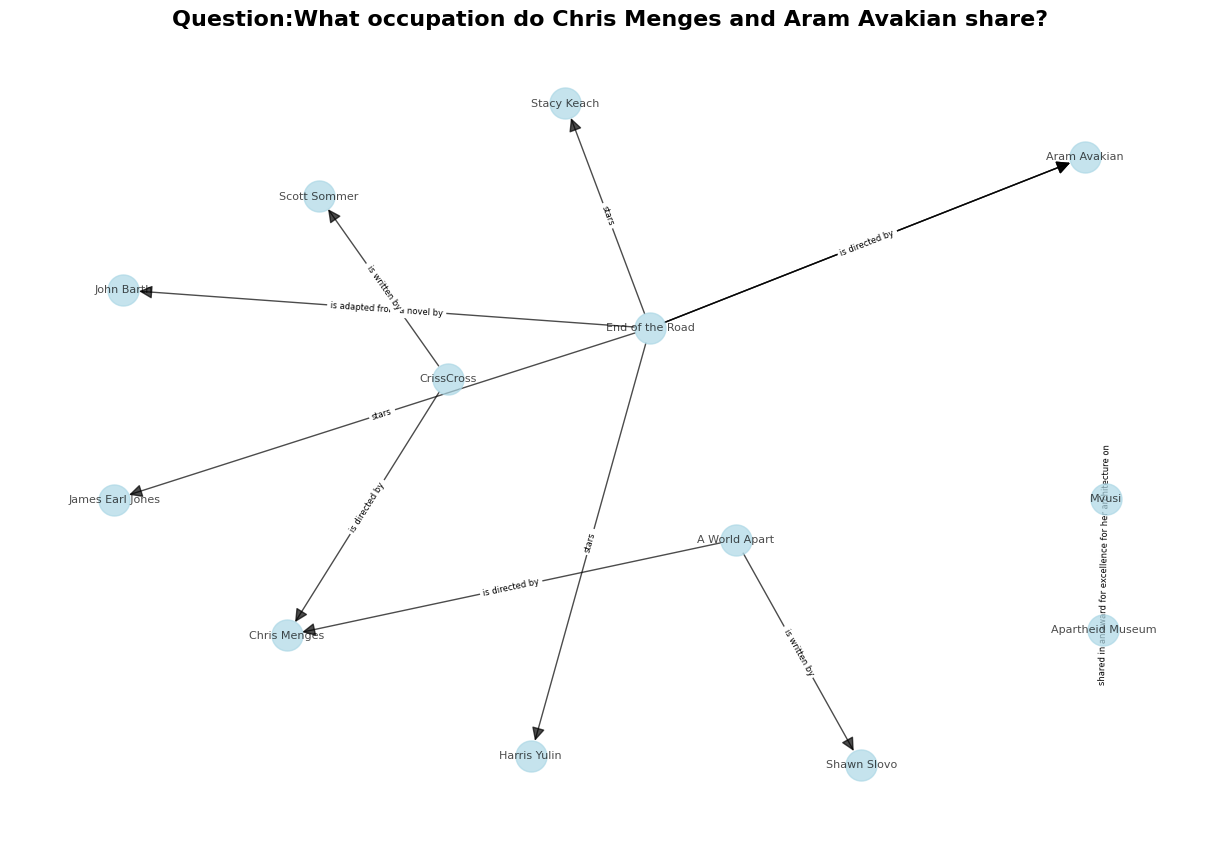

In [ ]:
nx_graph_sf = supporting_facts_graphs_data_list[ROW_ID]['nx_graph']

visualize_graph(nx_graph_sf, f"Question:{example_question}")

In [ ]:
# Experiment Configuration Constants
embedding_model_name = 'BAAI/bge-m3'    # Embedding model for semantic similarity
LLM_MODEL_NAME = 'granite4:micro-h'     # Local LLM via Ollama for answer generation
MAX_HOPS = 4                            # Number of hops for BFS expansion
N_NODES = 5                             # Number of initial nodes to retrieve

### Step 1: Initialize LightRAG System

Configure the LightRAG system with:
- **Embedding Model**: BAAI/bge-m3 (1024-dimensional vectors for semantic similarity)
- **Max Hops**: Controls subgraph expansion radius (higher = more context, slower retrieval)
- **LLM**: IBM/granite4 for answer generation

In [ ]:
lightrag_system = LightRAG(
    embedding_model=embedding_model_name,
    max_hops=MAX_HOPS
)

lightrag_system.build_graph(nodes_list, edges_with_relations)

print(f"Graph built: {len(lightrag_system.node_embeddings)} nodes with embeddings")
print(f"Edges indexed: {lightrag_system.graph.number_of_edges()}")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Graph built: 13 nodes, 10 edges
Graph built: 13 nodes with embeddings
Edges indexed: 10


### Step 2: Extract Query Entities

Extract key entities from the question using the pre-constructed question graph. These entities act as 'entry points' into the knowledge graph.

In [ ]:
query_graph_dict = question_graphs_data_list[ROW_ID]
query_nx_graph = query_graph_dict['nx_graph']
query_entities = [str(node) for node in query_nx_graph.nodes()]

print(f"Extracted {len(query_entities)} entities:")
for i, entity in enumerate(query_entities, 1):
    print(f"  {i}. '{entity}'")

Extracted 3 entities:
  1. 'Chris Menges'
  2. 'occupation'
  3. 'Aram Avakian'


### Step 3: Retrieve Relevant Subgraph

**Algorithm:**
1. **Dense Retrieval**: Find top-N most similar nodes using embeddings
2. **Graph Expansion**: BFS traversal to collect h-hop neighbors  
3. **Subgraph Extraction**: Return induced subgraph with all edges

In [ ]:
import time
start_time = time.time()

retrieved_subgraph = lightrag_system.query_with_entities(
    entities=query_entities,
    n_nodes=N_NODES
)

retrieval_time = time.time() - start_time

print(f"Retrieval completed in {retrieval_time:.3f}s")
print(f"Initial seeds: {N_NODES} → Expanded to: {len(retrieved_subgraph.nodes)} nodes")
print(f"Edges in subgraph: {len(retrieved_subgraph.edges)}")
print(f"Expansion ratio: {len(retrieved_subgraph.nodes)/N_NODES:.1f}x")

Querying with entities: ['Chris Menges', 'occupation', 'Aram Avakian']
Retrieved 5 relevant nodes
Retrieving subgraph for 5 nodes: ['Chris Menges', 'Aram Avakian', 'CrissCross', 'Mvusi', 'A World Apart']
Starting BFS from 5 valid start nodes: ['Chris Menges', 'Aram Avakian', 'CrissCross', 'Mvusi', 'A World Apart']
BFS completed: Found 13 nodes, 10 edges
Subgraph result: 13 nodes, 10 edges, 10 labeled relationships
Retrieval completed in 0.115s
Initial seeds: 5 → Expanded to: 13 nodes
Edges in subgraph: 10
Expansion ratio: 2.6x


### Step 4: Format Knowledge as Triplets

Transform graph structure into natural language triplets (`Subject → Relation → Object`) for LLM consumption.

In [ ]:
formatted_knowledge = ""

if hasattr(retrieved_subgraph, 'edges_with_relations') and retrieved_subgraph.edges_with_relations:
    for edge in retrieved_subgraph.edges_with_relations:
        relation = edge.relation if edge.relation else 'related_to'
        formatted_knowledge += f"{edge.source} -> {relation} -> {edge.target}\n"
else:
    for edge in retrieved_subgraph.edges:
        source, target = edge[0], edge[1]
        relation = edge[2] if len(edge) > 2 and edge[2] else 'related_to'
        formatted_knowledge += f"{source} -> {relation} -> {target}\n"

num_triplets = len(formatted_knowledge.split('\n')) - 1
print(f"Generated {num_triplets} triplets ({len(formatted_knowledge)} chars)")
print(formatted_knowledge)

Generated 10 triplets (506 chars)
End of the Road -> stars -> Stacy Keach
A World Apart -> is directed by -> Chris Menges
A World Apart -> is written by -> Shawn Slovo
Mvusi -> shared in an award for excellence for her architecture on -> Apartheid Museum
End of the Road -> is directed by -> Aram Avakian
End of the Road -> stars -> Harris Yulin
End of the Road -> stars -> James Earl Jones
End of the Road -> is adapted from a novel by -> John Barth
CrissCross -> is directed by -> Chris Menges
CrissCross -> is written by -> Scott Sommer



### Step 5: Generate Answer with LLM

In [ ]:
example_question

'What occupation do Chris Menges and Aram Avakian share?'

In [ ]:
print(formatted_knowledge)

End of the Road -> stars -> Stacy Keach
A World Apart -> is directed by -> Chris Menges
A World Apart -> is written by -> Shawn Slovo
Mvusi -> shared in an award for excellence for her architecture on -> Apartheid Museum
End of the Road -> is directed by -> Aram Avakian
End of the Road -> stars -> Harris Yulin
End of the Road -> stars -> James Earl Jones
End of the Road -> is adapted from a novel by -> John Barth
CrissCross -> is directed by -> Chris Menges
CrissCross -> is written by -> Scott Sommer



In [ ]:
prompt = f"""Based on the following knowledge triplets, answer the question directly.

Knowledge:
{formatted_knowledge}

Question: {example_question}

Provide a concise answer based only on the given knowledge."""

response = ollama.chat(
    model=LLM_MODEL_NAME,
    messages=[{'role': 'user', 'content': prompt}]
)
lightrag_answer = response['message']['content'].strip()
print(lightrag_answer)

Both Chris Menges and Aram Avakian share the occupation of director.


## PathRAG: Explicit Reasoning Path Discovery

We've now seen:
- **GraphRAG** with **GraphRetriever**: Hierarchical community-based retrieval (preprocessing-heavy)
- **LightRAG**: Fast subgraph expansion around relevant nodes

Now let's explore **PathRAG**, which takes yet another approach: discovering and scoring **explicit reasoning paths** within the knowledge graph.


<img src="https://miro.medium.com/v2/resize:fit:1200/0*6On8J9d9wHU5LiE4.png" width="400">


| Aspect | **GraphRAG** | **LightRAG** | **PathRAG** |
|--------|-----------------------------------|-------------|------------|
| **Core Strategy** | Community summaries | Subgraph expansion | Explicit path finding |
| **Interpretability** | Medium (community themes) | Low (large subgraphs) | High (scored paths) |
| **Reasoning Focus** | Global synthesis | Broad context | Multi-hop chains |
| **Computational Cost** | High preprocessing, low query | Low preprocessing, medium query | Medium preprocessing, high query |

**PathRAG** takes a more complex approach by discovering and scoring explicit **reasoning paths** within the knowledge graph. This method is designed to uncover nuanced, multi-hop relationships between concepts, prioritizing reliability and interpretability over raw speed.

## PathRAG Experiment: Path-Based Reasoning Retrieval


**Key Difference from LightRAG:** PathRAG focuses on EXPLICIT PATHS rather than broad subgraphs. Each path represents a potential reasoning chain: A → B → C → Answer. Path scoring favors shorter, high-confidence connections.

In [ ]:
class PathRAG:
    """
    PathRAG: Path-Based Retrieval-Augmented Generation Framework

    Discovers and scores explicit reasoning paths through knowledge graphs using
    a PageRank-inspired reliability scoring mechanism.

    Includes relationship/edge label support for interpretable path visualization.
    """

    def __init__(self,
                 embedding_model: str = 'all-MiniLM-L6-v2',
                 alpha: float = 0.85,
                 theta: float = 1e-5,
                 max_iterations: int = 100):
        """
        Initialize PathRAG system.

        Args:
            embedding_model: Sentence transformer model name for computing node embeddings
                           (e.g., 'all-MiniLM-L6-v2', 'BAAI/bge-m3')
            alpha: Damping factor for path reliability scoring (0.0-1.0)
                  - Higher values = prefer longer, well-connected paths
                  - Lower values = prefer shorter, direct paths
                  - Similar to PageRank's teleportation probability
            theta: Convergence threshold for iterative reliability computation
                  - Smaller values = more precise but slower
                  - Typical range: 1e-6 to 1e-4
            max_iterations: Maximum iterations for reliability score computation
                          - Safety limit to prevent infinite loops
                          - Typical value: 100-200
        """
        self.encoder = SentenceTransformer(embedding_model)
        self.alpha = alpha
        self.theta = theta
        self.max_iterations = max_iterations
        self.graph = nx.DiGraph()
        self.nodes: Dict[str, Node] = {}
        self.node_embeddings: Optional[np.ndarray] = None
        self.node_ids: List[str] = []

    def build_graph(self, nodes: List[Dict], edges: List[Any]):
        """
        Build the graph from nodes and edges data

        Args:
            nodes: List of node dictionaries with 'id' and 'identifier'
            edges: List of edges, can be:
                   - Tuples: (source, target)
                   - Tuples with relation: (source, target, relation)
                   - Dicts: {'source': str, 'target': str, 'relation': str}
        """
        # Add nodes
        for node_data in nodes:
            node = Node(id=node_data['id'], identifier=node_data['identifier'])
            self.nodes[node.id] = node
            self.graph.add_node(node.id)

        # Add edges with relationship information
        for edge in edges:
            if isinstance(edge, dict):
                # Dictionary format: {'source': 'A', 'target': 'B', 'relation': 'knows'}
                source = edge['source']
                target = edge['target']
                relation = edge.get('relation', None)
                self.graph.add_edge(source, target, relation=relation)
            elif isinstance(edge, (tuple, list)) and len(edge) == 3:
                # Triple format: (source, target, relation)
                source, target, relation = edge
                self.graph.add_edge(source, target, relation=relation)
            elif isinstance(edge, (tuple, list)) and len(edge) == 2:
                # Simple tuple format: (source, target)
                source, target = edge
                self.graph.add_edge(source, target, relation=None)
            else:
                raise ValueError(f"Unsupported edge format: {edge}")

        print(f"Graph built: {self.graph.number_of_nodes()} nodes, {self.graph.number_of_edges()} edges")
        self._precompute_embeddings()

    def _precompute_embeddings(self):
        self.node_ids = list(self.nodes.keys())
        identifiers = [self.nodes[node_id].identifier for node_id in self.node_ids]
        if identifiers:
            self.node_embeddings = self.encoder.encode(identifiers, convert_to_numpy=True)
            for i, node_id in enumerate(self.node_ids):
                self.nodes[node_id].embedding = self.node_embeddings[i]

    def retrieve_nodes_from_entities(self, entities: List[str], n_nodes: int = 20) -> List[str]:
        """Retrieve nodes based on provided entities from question graphs"""
        if not entities or not self.node_ids or self.node_embeddings is None:
            return []

        entity_embeddings = self.encoder.encode(entities, convert_to_numpy=True)
        similarities = np.dot(entity_embeddings, self.node_embeddings.T)
        max_similarities = np.max(similarities, axis=0)

        actual_n_nodes = min(n_nodes, len(self.node_ids))
        if actual_n_nodes == 0:
            return []

        if actual_n_nodes == len(self.node_ids):
            top_indices = np.argsort(max_similarities)[::-1]
        else:
            top_indices = np.argpartition(max_similarities, -actual_n_nodes)[-actual_n_nodes:]
            top_indices = top_indices[np.argsort(max_similarities[top_indices])[::-1]]

        return [self.node_ids[i] for i in top_indices]

    def _propagate_resources(self, start_node: str, end_node: str) -> Dict[str, float]:
        resources = {node_id: 0.0 for node_id in self.graph.nodes()}
        resources[start_node] = 1.0
        try:
            reachable = nx.descendants(self.graph, start_node) | {start_node}
            if end_node not in reachable: return resources
        except: reachable = set(self.graph.nodes())

        for _ in range(self.max_iterations):
            new_resources = resources.copy()
            updated = False
            for node in list(reachable):
                current_resource = resources[node]
                successors = list(self.graph.successors(node))
                if not successors or current_resource <= 0: continue
                out_degree = len(successors)
                if current_resource / out_degree < self.theta: continue
                resource_per_successor = self.alpha * current_resource / out_degree
                for successor in successors:
                    old_value = new_resources.get(successor, 0.0)
                    new_resources[successor] = max(old_value, resource_per_successor)
                    if abs(new_resources[successor] - old_value) > 1e-9: updated = True
            resources = new_resources
            if not updated: break
        return resources

    def _extract_paths(self, start_node: str, end_node: str, resources: Dict[str, float], max_path_length: int = 6) -> List[Path]:
        paths = []
        def dfs(current_node: str, path_nodes: List[str], path_edges: List[EdgeWithRelation], visited: Set[str]):
            if len(path_edges) >= max_path_length: return
            if current_node == end_node and path_nodes:
                path_resources = [resources.get(node_id, 0) for node_id in path_nodes]
                reliability = sum(path_resources) / len(path_edges) if path_edges else 0

                # Create simple edges list for backward compatibility
                simple_edges = [edge.to_tuple() for edge in path_edges]

                # Create relationships dictionary
                relationships = {}
                for edge in path_edges:
                    if edge.relation is not None:
                        relationships[edge.to_tuple()] = edge.relation

                # Create a path with the original structure but add relationship info as attributes
                path = Path(
                    nodes=path_nodes.copy(),
                    edges=simple_edges,
                    reliability_score=reliability
                )
                # Add relationship information as additional attributes
                path.edges_with_relations = path_edges.copy()
                path.relationships = relationships
                paths.append(path)
                return

            for successor in self.graph.successors(current_node):
                if successor not in visited:
                    # Get edge data for relationship information
                    edge_data = self.graph.get_edge_data(current_node, successor)
                    relation = edge_data.get('relation') if edge_data else None
                    edge_with_relation = EdgeWithRelation(
                        source=current_node,
                        target=successor,
                        relation=relation
                    )

                    visited.add(successor)
                    dfs(successor, path_nodes + [successor], path_edges + [edge_with_relation], visited)
                    visited.remove(successor)

        dfs(start_node, [start_node], [], {start_node})
        return paths

    def retrieve_paths(self, retrieved_nodes: List[str], k_paths: int = 10) -> List[Path]:
        candidate_paths = []
        for start_node, end_node in combinations(retrieved_nodes, 2):
            if nx.has_path(self.graph, start_node, end_node):
                resources = self._propagate_resources(start_node, end_node)
                paths = self._extract_paths(start_node, end_node, resources)
                candidate_paths.extend(paths)
        return sorted(candidate_paths, key=lambda p: p.reliability_score, reverse=True)[:k_paths]

    def query_with_entities(self, entities: List[str], n_nodes: int = 20, k_paths: int = 10) -> List[Path]:
        """Query using entities from question graphs"""
        print(f"Querying with entities: {entities}")
        retrieved_nodes = self.retrieve_nodes_from_entities(entities, n_nodes)
        print(f"Retrieved {len(retrieved_nodes)} relevant nodes")

        if not retrieved_nodes:
            return []
        return self.retrieve_paths(retrieved_nodes, k_paths)

    def get_relationships_between(self, node1: str, node2: str) -> List[str]:
        """Get all relationship names between two nodes"""
        relationships = []

        # Check direct edge from node1 to node2
        if self.graph.has_edge(node1, node2):
            edge_data = self.graph.get_edge_data(node1, node2)
            relation = edge_data.get('relation') if edge_data else None
            if relation:
                relationships.append(relation)

        # Check direct edge from node2 to node1
        if self.graph.has_edge(node2, node1):
            edge_data = self.graph.get_edge_data(node2, node1)
            relation = edge_data.get('relation') if edge_data else None
            if relation:
                relationships.append(relation)

        return relationships

    def print_path_relationships(self, paths: List[Path]):
        """Pretty print the relationships in paths"""
        print(f"\n🛤️  Path Relationships ({len(paths)} paths):")
        print("-" * 60)

        if not paths:
            print("  No paths found")
            return

        for i, path in enumerate(paths):
            print(f"\n  Path {i+1} (Reliability: {path.reliability_score:.4f}):")
            if hasattr(path, 'edges_with_relations') and path.edges_with_relations:
                for edge in path.edges_with_relations:
                    if edge.relation:
                        print(f"    {edge.source} --[{edge.relation}]--> {edge.target}")
                    else:
                        print(f"    {edge.source} --------> {edge.target}")
            else:
                # Fallback for simple edges
                for edge in path.edges:
                    if isinstance(edge, tuple) and len(edge) >= 2:
                        print(f"    {edge[0]} --------> {edge[1]}")

            if hasattr(path, 'relationships') and path.relationships:
                relation_counts = {}
                for relation in path.relationships.values():
                    relation_counts[relation] = relation_counts.get(relation, 0) + 1

                if relation_counts:
                    relations_str = ", ".join([f"{rel}({count})" for rel, count in relation_counts.items()])
                    print(f"    Relations: {relations_str}")

In [ ]:
# Let's find a question where entities are connected through paths
# We'll check a few examples to find one with good connectivity

def check_connectivity(row_id):
    """Check if query entities in a question are connected"""
    q_data = question_graphs_data_list[row_id]
    sf_data = supporting_facts_graphs_data_list[row_id]

    # Get question entities
    q_nx = q_data['nx_graph']
    entities = [str(e) for e in q_nx.nodes()]

    # Get supporting facts graph
    sf_nx = sf_data['nx_graph']

    # Check connectivity
    G_undirected = sf_nx.to_undirected()

    # Find which entities exist in the graph
    valid = [e for e in entities if e in sf_nx.nodes()]

    if len(valid) < 2:
        return None

    # Check if there's a path between the first two entities
    try:
        if nx.has_path(G_undirected, valid[0], valid[1]):
            path = nx.shortest_path(G_undirected, valid[0], valid[1])
            return {
                'row_id': row_id,
                'question': hotpotqa_data_filtered[row_id]['question'],
                'answer': hotpotqa_data_filtered[row_id]['answer'],
                'entities': valid,
                'path_length': len(path) - 1,
                'num_nodes': sf_nx.number_of_nodes(),
                'num_edges': sf_nx.number_of_edges()
            }
    except:
        pass

    return None

# Check a sample of examples
print("Searching for PathRAG-suitable questions...")
connected_examples = []
for i in range(min(20, len(hotpotqa_data_filtered))):
    result = check_connectivity(i)
    if result and result['path_length'] > 1 and result['path_length'] <= 4:
        connected_examples.append(result)
        print(f"  ROW_ID={i}: Path length={result['path_length']}, Nodes={result['num_nodes']}")
        print(f"    Q: {result['question'][:80]}...")
        print(f"    A: {result['answer']}")

print(f"\nFound {len(connected_examples)} suitable examples")

Searching for PathRAG-suitable questions...
  ROW_ID=1: Path length=2, Nodes=12
    Q: What government position was held by the woman who portrayed Corliss Archer in t...
    A: Chief of Protocol
  ROW_ID=3: Path length=2, Nodes=17
    Q: Are the Laleli Mosque and Esma Sultan Mansion located in the same neighborhood?...
    A: no
  ROW_ID=11: Path length=2, Nodes=10
    Q: What screenwriter with credits for "Evolution" co-wrote a film starring Nicolas ...
    A: David Weissman

Found 3 suitable examples


In [ ]:
PATHRAG_ROW_ID = 11

example_row = hotpotqa_data_filtered[PATHRAG_ROW_ID]
question = example_row['question']
expected_answer = example_row['answer']
supporting_facts = example_row['supporting_facts']

print(f"Question: {question}")
print(f"Expected answer: {expected_answer}")
print(f"Supporting facts: {len(supporting_facts)}")

Question: What screenwriter with credits for "Evolution" co-wrote a film starring Nicolas Cage and Téa Leoni?
Expected answer: David Weissman
Supporting facts: 3


### Build Knowledge Graph

In [ ]:
# Build graph from supporting facts
sf_graph_data = supporting_facts_graphs_data_list[PATHRAG_ROW_ID]
nx_graph_sf = sf_graph_data['nx_graph']

# Extract nodes and edges with relations
nodes_set = set()
edges_with_relations = []

for u, v, data in nx_graph_sf.edges(data=True):
    nodes_set.add(str(u))
    nodes_set.add(str(v))
    relationship_label = data.get('relation', 'related_to')
    edges_with_relations.append((str(u), str(v), relationship_label))

nodes_list = list(nodes_set)
edges_with_labels_count = sum(1 for _, _, rel in edges_with_relations if rel and rel != 'related_to')

print(f"Graph structure:")
print(f"  Nodes: {len(nodes_list)}")
print(f"  Edges: {len(edges_with_relations)}")
print(f"  Edges with labels: {edges_with_labels_count}/{len(edges_with_relations)}")

print(f"\nSample edges:")
for src, tgt, rel in edges_with_relations[:5]:
    print(f"  {src} --[{rel}]--> {tgt}")

Graph structure:
  Nodes: 10
  Edges: 9
  Edges with labels: 9/9

Sample edges:
  The Family Man --[directed by]--> Brett Ratner
  The Family Man --[is a]--> romantic comedy-drama film
  The Family Man --[is a]--> American
  The Family Man --[written by]--> David Weissman
  The Family Man --[starring]--> Nicolas Cage


In [ ]:
# Let's examine all nodes in the graph
print(f"\nAll nodes in the graph:")
for node in sorted(nodes_list):
    print(f"  - {node}")

print(f"\nAll edges in the graph:")
for src, tgt, rel in edges_with_relations:
    print(f"  {src} --[{rel}]--> {tgt}")


All nodes in the graph:
  - 2000
  - American
  - Brett Ratner
  - David Diamond
  - David Weissman
  - Ennio Flaiano
  - Nicolas Cage
  - The Family Man
  - Téa Leoni
  - romantic comedy-drama film

All edges in the graph:
  The Family Man --[directed by]--> Brett Ratner
  The Family Man --[is a]--> romantic comedy-drama film
  The Family Man --[is a]--> American
  The Family Man --[written by]--> David Weissman
  The Family Man --[starring]--> Nicolas Cage
  The Family Man --[is a]--> 2000
  The Family Man --[based on novel by]--> Ennio Flaiano
  The Family Man --[starring]--> Téa Leoni
  The Family Man --[written by]--> David Diamond


---

## Comparison and Benchmarking

Now that we've seen LightRAG (ROW_ID=85) and PathRAG (ROW_ID=11) on different questions, let's compare them systematically on the full dataset.

## Benchmark: LightRAG vs. PathRAG
Let's compare the two approaches. We will use Rouge to evaluate the precision of the open answer.

In [ ]:
from dataclasses import dataclass
import pandas as pd
import numpy as np
import time
import json
from itertools import combinations
from collections import deque
from typing import List, Dict, Set, Tuple, Optional, Any
import networkx as nx
import evaluate
import ollama

@dataclass
class ComparisonResult:
    query: str
    reference_answer: str
    pathrag_time: float
    lightrag_time: float
    pathrag_paths: List['Path']
    lightrag_subgraph: 'SubGraph'
    pathrag_coverage: float
    lightrag_coverage: float
    pathrag_connectivity: float
    lightrag_connectivity: float
    pathrag_generated_text: str
    lightrag_generated_text: str
    pathrag_rouge1: float # Updated to use multiple ROUGE metrics
    pathrag_rouge2: float
    pathrag_rougeL: float
    lightrag_rouge1: float
    lightrag_rouge2: float
    lightrag_rougeL: float

class RAGComparator:
    def __init__(self, hotpotqa_data: List[Dict],
                 knowledge_graph_data_list: List[Dict],
                 question_graphs_data_list: List[Dict] = None,
                 embedding_model: str = 'BAAI/bge-m3',
                 llm_model: str = 'llama3.2:3b'):
        self.embedding_model = embedding_model
        self.llm_model = llm_model
        self.hotpotqa_data = hotpotqa_data
        self.knowledge_graph_data_list = knowledge_graph_data_list
        self.question_graphs_data_list = question_graphs_data_list or []
        self.pathrag = None
        self.lightrag = None
        self.rouge = evaluate.load('rouge')
        self.total_nodes_in_kg = 0

    def extract_question_entities(self, question_index: int) -> List[str]:
        """Extract entities from the question graph"""
        if question_index >= len(self.question_graphs_data_list):
            return []

        question_graph_data = self.question_graphs_data_list[question_index]
        nx_graph = question_graph_data.get('nx_graph')

        if not nx_graph or not isinstance(nx_graph, nx.Graph):
            return []

        # Extract all nodes (entities) from the question graph
        entities = list(nx_graph.nodes())
        return [str(entity) for entity in entities]

    def format_knowledge_for_llm(self, paths: List['Path'] = None, subgraph: 'SubGraph' = None) -> str:
        """Format retrieved knowledge into a readable format for the LLM"""
        knowledge_text = ""

        if paths:
            knowledge_text += "Retrieved reasoning paths:\n"
            for i, path in enumerate(paths[:5], 1):  # Limit to top 5 paths
                # Use edges_with_relations if available, otherwise fall back to simple edges
                if hasattr(path, 'edges_with_relations') and path.edges_with_relations:
                    path_str = ""
                    for j, edge in enumerate(path.edges_with_relations):
                        if j > 0:
                            path_str += " → "
                        if edge.relation:
                            path_str += f"{edge.source} --[{edge.relation}]--> {edge.target}"
                        else:
                            path_str += f"{edge.source} → {edge.target}"
                        if j >= 5:  # Limit path display length
                            path_str += " → ..."
                            break
                else:
                    # Fallback to original path display
                    path_nodes = path.nodes[:6] if hasattr(path, 'nodes') else []
                    path_str = " → ".join(path_nodes)
                    if len(path.nodes) > 6:
                        path_str += " → ..."

                knowledge_text += f"{i}. {path_str} (reliability: {path.reliability_score:.3f})\n"

            # Add unique entities from all paths
            all_entities = set()
            for path in paths:
                if hasattr(path, 'nodes'):
                    all_entities.update(path.nodes)
            knowledge_text += f"\nRelevant entities: {', '.join(sorted(list(all_entities))[:20])}"
            if len(all_entities) > 20:
                knowledge_text += "..."

        elif subgraph and subgraph.nodes:
            knowledge_text += "Retrieved knowledge subgraph:\n"
            knowledge_text += f"Entities: {', '.join(subgraph.nodes[:30])}"
            if len(subgraph.nodes) > 30:
                knowledge_text += "..."

            # Use edges_with_relations if available
            if hasattr(subgraph, 'edges_with_relations') and subgraph.edges_with_relations:
                knowledge_text += f"\n\nKey relationships:\n"
                for i, edge in enumerate(subgraph.edges_with_relations[:10], 1):
                    if edge.relation:
                        knowledge_text += f"{i}. {edge.source} --[{edge.relation}]--> {edge.target}\n"
                    else:
                        knowledge_text += f"{i}. {edge.source} → {edge.target}\n"
                if len(subgraph.edges_with_relations) > 10:
                    knowledge_text += "... and more relationships\n"
            elif subgraph.edges:
                knowledge_text += f"\n\nKey relationships:\n"
                for i, (source, target) in enumerate(subgraph.edges[:10], 1):
                    knowledge_text += f"{i}. {source} → {target}\n"
                if len(subgraph.edges) > 10:
                    knowledge_text += "... and more relationships\n"
        else:
            knowledge_text = "No relevant knowledge retrieved."

        return knowledge_text

    def generate_answer_with_ollama(self, question: str, knowledge: str, method_name: str) -> str:
        """Generate answer using ollama with the retrieved knowledge"""
        try:
            prompt = f"""You are an AI assistant answering questions using retrieved knowledge from a knowledge graph.

Question: {question}

Retrieved Knowledge ({method_name}):
{knowledge}

Instructions:
- Answer the question directly and concisely based on the retrieved knowledge
- If the knowledge is insufficient, state what you can determine and what information is missing
- Keep your answer factual and specific
- Do not make assumptions beyond what the knowledge provides

Answer:"""

            response = ollama.chat(
                model=self.llm_model,
                messages=[{'role': 'user', 'content': prompt}],
                options={'temperature': 0.1, 'top_p': 0.9}
            )

            return response['message']['content'].strip()

        except Exception as e:
            print(f"Error generating answer with ollama: {e}")
            return f"Error: Could not generate answer using {method_name} knowledge."

    def extract_edges_with_relations(self, nx_graph) -> List[Any]:
        """Extract edges with relation information from NetworkX graph"""
        edges_with_relations = []
        edges_with_labels_count = 0

        for u, v, data in nx_graph.edges(data=True):
            if data:  # Has edge attributes
                relation = data.get('relation')
                if relation and str(relation) != 'None':
                    edges_with_relations.append((u, v, str(relation)))
                    edges_with_labels_count += 1
                else:
                    edges_with_relations.append((u, v))
            else:
                # No attributes
                edges_with_relations.append((u, v))

        print(f"Extracted {len(edges_with_relations)} edges, {edges_with_labels_count} with labels")
        return edges_with_relations

    def initialize_systems(self):
        print("\n📊 Initializing RAG systems with data from extract_gr.py...")

        combined_nodes = set()
        combined_edges = []

        if not self.knowledge_graph_data_list:
            print("Knowledge graph data list is empty. Cannot initialize RAG systems.")
            # Initialize with empty graphs to prevent errors, though results will be meaningless
            self.test_graph_nodes_for_rag = []
            self.test_graph_edges_for_rag = []
        else:
            for graph_item_dict in self.knowledge_graph_data_list:
                nx_graph = graph_item_dict.get('nx_graph')
                if nx_graph and isinstance(nx_graph, nx.Graph): # Check if nx_graph exists and is a graph
                    # Add nodes
                    for node in nx_graph.nodes():
                        combined_nodes.add(str(node))

                    # Extract edges with relations
                    graph_edges = self.extract_edges_with_relations(nx_graph)
                    combined_edges.extend(graph_edges)
                else:
                    print(f"Warning: Skipping item due to missing or invalid 'nx_graph': {graph_item_dict.get('index', 'Unknown index')}")

            self.test_graph_nodes_for_rag = [{'id': node_name, 'identifier': node_name} for node_name in combined_nodes]
            self.test_graph_edges_for_rag = combined_edges
            self.total_nodes_in_kg = len(self.test_graph_nodes_for_rag)

        print(f"Unified knowledge graph: {len(self.test_graph_nodes_for_rag)} nodes, {len(self.test_graph_edges_for_rag)} edges")

        # Initialize PathRAG
        self.pathrag = PathRAG(embedding_model=self.embedding_model, alpha=0.85, theta=1e-5, max_iterations=100)
        if self.test_graph_nodes_for_rag: # Only build if nodes exist
             self.pathrag.build_graph(self.test_graph_nodes_for_rag, self.test_graph_edges_for_rag)
        else: # Build with empty graph if no nodes
            self.pathrag.build_graph([], [])

        # Initialize LightRAG
        self.lightrag = LightRAG(embedding_model=self.embedding_model, max_hops=2)
        if self.test_graph_nodes_for_rag: # Only build if nodes exist
            self.lightrag.build_graph(self.test_graph_nodes_for_rag, self.test_graph_edges_for_rag)
        else: # Build with empty graph if no nodes
            self.lightrag.build_graph([], [])

        print(f"\nRAG Systems initialized successfully!")

        # Test ollama connection
        try:
            test_response = ollama.chat(
                model=self.llm_model,
                messages=[{'role': 'user', 'content': 'Hello, can you respond?'}],
                options={'temperature': 0.1}
            )
            print(f"Ollama connection verified with model: {self.llm_model}")
        except Exception as e:
            print(f"Warning: Ollama connection failed: {e}")
            print("Answer generation will use fallback text instead of LLM responses.")

    def run_single_comparison(self, query: str, reference_answer: str, question_index: int = -1, n_nodes: int = 15, k_paths: int = 10) -> ComparisonResult:
        # Extract entities from question graph if available
        question_entities = self.extract_question_entities(question_index) if question_index >= 0 else []

        # PathRAG
        start_time = time.time()
        if question_entities and self.pathrag and self.test_graph_nodes_for_rag:
            pathrag_paths = self.pathrag.query_with_entities(question_entities, n_nodes=n_nodes, k_paths=k_paths)
        elif self.pathrag and self.test_graph_nodes_for_rag:
            pathrag_paths = self.pathrag.query(query, n_nodes=n_nodes, k_paths=k_paths)
        else:
            pathrag_paths = []
        pathrag_time = time.time() - start_time

        # Generate answer using PathRAG knowledge
        pathrag_knowledge = self.format_knowledge_for_llm(paths=pathrag_paths)
        pathrag_generated_text = self.generate_answer_with_ollama(query, pathrag_knowledge, "PathRAG")

        # Calculate ROUGE scores for PathRAG
        if reference_answer and pathrag_generated_text:
            pathrag_rouge_scores = self.rouge.compute(predictions=[pathrag_generated_text], references=[reference_answer])
        else:
            pathrag_rouge_scores = {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0}

        # LightRAG
        start_time = time.time()
        if question_entities and self.lightrag and self.test_graph_nodes_for_rag:
            lightrag_subgraph = self.lightrag.query_with_entities(question_entities, n_nodes=n_nodes)
        elif self.lightrag and self.test_graph_nodes_for_rag:
            lightrag_subgraph = self.lightrag.query(query, n_nodes=n_nodes)
        else:
            lightrag_subgraph = SubGraph(nodes=[], edges=[], relevance_score=0.0)
        lightrag_time = time.time() - start_time

        # Generate answer using LightRAG knowledge
        lightrag_knowledge = self.format_knowledge_for_llm(subgraph=lightrag_subgraph)
        lightrag_generated_text = self.generate_answer_with_ollama(query, lightrag_knowledge, "LightRAG")

        # Calculate ROUGE scores for LightRAG
        if reference_answer and lightrag_generated_text:
            lightrag_rouge_scores = self.rouge.compute(predictions=[lightrag_generated_text], references=[reference_answer])
        else:
            lightrag_rouge_scores = {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0}

        # Calculate coverage and connectivity metrics
        pathrag_retrieved_nodes_set = set()
        pathrag_retrieved_edges_set = set()

        if pathrag_paths:
            for p in pathrag_paths:
                if hasattr(p, 'nodes'):
                    pathrag_retrieved_nodes_set.update(p.nodes)
                if hasattr(p, 'edges_with_relations') and p.edges_with_relations:
                    for edge in p.edges_with_relations:
                        pathrag_retrieved_edges_set.add(edge.to_tuple())
                elif hasattr(p, 'edges'):
                    pathrag_retrieved_edges_set.update(p.edges)

        lightrag_edges_count = 0
        if hasattr(lightrag_subgraph, 'edges_with_relations') and lightrag_subgraph.edges_with_relations:
            lightrag_edges_count = len(lightrag_subgraph.edges_with_relations)
        elif lightrag_subgraph.edges:
            lightrag_edges_count = len(lightrag_subgraph.edges)

        return ComparisonResult(
            query=query,
            reference_answer=reference_answer,
            pathrag_time=pathrag_time,
            lightrag_time=lightrag_time,
            pathrag_paths=pathrag_paths,
            lightrag_subgraph=lightrag_subgraph,
            pathrag_coverage=len(pathrag_retrieved_nodes_set) / self.total_nodes_in_kg if self.total_nodes_in_kg > 0 else 0,
            lightrag_coverage=len(lightrag_subgraph.nodes) / self.total_nodes_in_kg if self.total_nodes_in_kg > 0 and lightrag_subgraph.nodes else 0,
            pathrag_connectivity=len(pathrag_retrieved_edges_set) / len(pathrag_retrieved_nodes_set) if pathrag_retrieved_nodes_set else 0,
            lightrag_connectivity=lightrag_edges_count / len(lightrag_subgraph.nodes) if lightrag_subgraph.nodes else 0,
            pathrag_generated_text=pathrag_generated_text,
            lightrag_generated_text=lightrag_generated_text,
            pathrag_rouge1=pathrag_rouge_scores['rouge1'],
            pathrag_rouge2=pathrag_rouge_scores['rouge2'],
            pathrag_rougeL=pathrag_rouge_scores['rougeL'],
            lightrag_rouge1=lightrag_rouge_scores['rouge1'],
            lightrag_rouge2=lightrag_rouge_scores['rouge2'],
            lightrag_rougeL=lightrag_rouge_scores['rougeL']
        )

    def run_comprehensive_comparison(self) -> List[ComparisonResult]:
        results = []
        if not self.hotpotqa_data or not self.test_graph_nodes_for_rag:
            print("Not enough data to run comprehensive comparison. HotpotQA data or KG is empty/not initialized.")
            return results

        print("\nRunning comprehensive comparison using HotpotQA data...")
        print("=" * 80)
        for i, item in enumerate(self.hotpotqa_data, 1):
            query = item['question']
            reference_answer = item['answer']
            print(f"\n{i:2d}/{len(self.hotpotqa_data)}: Query: {query[:60]}...")
            print(f"Reference Answer: {reference_answer[:60]}...")

            # Extract entities for this question
            question_entities = self.extract_question_entities(i-1)
            if question_entities:
                print(f"Question entities: {question_entities[:5]}{'...' if len(question_entities) > 5 else ''}")

            result = self.run_single_comparison(query, reference_answer, question_index=i-1)
            results.append(result)
            print(f"    PathRAG: {len(result.pathrag_paths)} paths, {result.pathrag_time:.3f}s")
            print(f"      Generated: {result.pathrag_generated_text[:80]}{'...' if len(result.pathrag_generated_text) > 80 else ''}")
            print(f"      ROUGE-1: {result.pathrag_rouge1:.3f}, ROUGE-2: {result.pathrag_rouge2:.3f}, ROUGE-L: {result.pathrag_rougeL:.3f}")
            print(f"    LightRAG: {len(result.lightrag_subgraph.nodes)} nodes, {result.lightrag_time:.3f}s")
            print(f"      Generated: {result.lightrag_generated_text[:80]}{'...' if len(result.lightrag_generated_text) > 80 else ''}")
            print(f"      ROUGE-1: {result.lightrag_rouge1:.3f}, ROUGE-2: {result.lightrag_rouge2:.3f}, ROUGE-L: {result.lightrag_rougeL:.3f}")
        print("=" * 80)
        return results

    def run_scaling_benchmark(self, max_samples: int = 50) -> pd.DataFrame:
        """Benchmark performance with increasing number of retrieved triplets"""
        if not self.hotpotqa_data or not self.test_graph_nodes_for_rag:
            print("Not enough data to run scaling benchmark.")
            return pd.DataFrame()

        # Test different numbers of retrieved nodes/paths
        test_scales = [5, 10, 15, 20, 25, 30, 50]
        sample_size = min(max_samples, len(self.hotpotqa_data))
        sample_indices = list(range(sample_size))

        results = []

        print(f"\n🔬 Running scaling benchmark with {sample_size} questions...")
        print("=" * 80)

        for scale in test_scales:
            print(f"\nTesting with {scale} retrieved nodes/paths...")

            pathrag_times = []
            lightrag_times = []
            pathrag_rouge_scores = []
            lightrag_rouge_scores = []
            pathrag_triplet_counts = []
            lightrag_triplet_counts = []

            for idx in sample_indices:
                item = self.hotpotqa_data[idx]
                query = item['question']
                reference_answer = item['answer']

                result = self.run_single_comparison(query, reference_answer, question_index=idx, n_nodes=scale, k_paths=scale*3)

                pathrag_times.append(result.pathrag_time)
                lightrag_times.append(result.lightrag_time)
                pathrag_rouge_scores.append(result.pathrag_rougeL)
                lightrag_rouge_scores.append(result.lightrag_rougeL)

                # Count triplets (edges) retrieved
                pathrag_triplet_count = 0
                if result.pathrag_paths:
                    unique_edges = set()
                    for path in result.pathrag_paths:
                        if hasattr(path, 'edges_with_relations') and path.edges_with_relations:
                            for edge in path.edges_with_relations:
                                unique_edges.add(edge.to_tuple())
                        elif hasattr(path, 'edges'):
                            unique_edges.update(path.edges)
                    pathrag_triplet_count = len(unique_edges)

                lightrag_triplet_count = 0
                if hasattr(result.lightrag_subgraph, 'edges_with_relations') and result.lightrag_subgraph.edges_with_relations:
                    lightrag_triplet_count = len(result.lightrag_subgraph.edges_with_relations)
                elif result.lightrag_subgraph.edges:
                    lightrag_triplet_count = len(result.lightrag_subgraph.edges)

                pathrag_triplet_counts.append(pathrag_triplet_count)
                lightrag_triplet_counts.append(lightrag_triplet_count)

            # Calculate averages
            results.append({
                'scale': scale,
                'pathrag_avg_time': np.mean(pathrag_times),
                'lightrag_avg_time': np.mean(lightrag_times),
                'pathrag_avg_rouge_l': np.mean(pathrag_rouge_scores),
                'lightrag_avg_rouge_l': np.mean(lightrag_rouge_scores),
                'pathrag_avg_triplets': np.mean(pathrag_triplet_counts),
                'lightrag_avg_triplets': np.mean(lightrag_triplet_counts),
                'pathrag_std_time': np.std(pathrag_times),
                'lightrag_std_time': np.std(lightrag_times)
            })

            print(f"  PathRAG: {np.mean(pathrag_times):.3f}s avg, {np.mean(pathrag_triplet_counts):.1f} triplets avg, ROUGE-L: {np.mean(pathrag_rouge_scores):.3f}")
            print(f"  LightRAG: {np.mean(lightrag_times):.3f}s avg, {np.mean(lightrag_triplet_counts):.1f} triplets avg, ROUGE-L: {np.mean(lightrag_rouge_scores):.3f}")

        scaling_df = pd.DataFrame(results)
        print("=" * 80)
        print("Scaling benchmark completed!")

        return scaling_df

def run_comparison():
    print("🚀 PathRAG vs LightRAG Comprehensive Comparison (using LLM-generated answers with labeled edges)")
    print("=" * 80)

    # Ensure data is loaded from the cells above
    if 'hotpotqa_data' not in globals() or 'supporting_facts_graphs_data_list' not in globals() or not hotpotqa_data or not supporting_facts_graphs_data_list:
        print("Data not loaded. Please run the data loading cells first.")
        return

    global comparator, scaling_results  # Make these global so they can be accessed later

    comparator = RAGComparator(
        hotpotqa_data=hotpotqa_data,
        knowledge_graph_data_list=supporting_facts_graphs_data_list,
        question_graphs_data_list=question_graphs_data_list,
        llm_model='llama3.2:3b'
    )
    comparator.initialize_systems()

    results = comparator.run_comprehensive_comparison()
    if not results:
        print("No results obtained from comparison!");
        return
    print(f"\nComparison completed! {len(results)} queries processed.")

    # Print detailed summary table
    df_results = pd.DataFrame(results)

    print("\n" + "="*140)
    print(f"📋 DETAILED ROUGE METRICS COMPARISON (LLM-Generated Answers with Labeled Edges)")
    print("-" * 140)
    header = f"{'Query':<30} | {'Time(P/L)':>12} | {'R1(P/L)':>10} | {'R2(P/L)':>10} | {'RL(P/L)':>10} | {'Winner':>8}"
    print(header)
    print("-" * 140)

    pathrag_wins_time, lightrag_wins_time = 0, 0
    pathrag_wins_rouge1, lightrag_wins_rouge1 = 0, 0
    pathrag_wins_rouge2, lightrag_wins_rouge2 = 0, 0
    pathrag_wins_rougeL, lightrag_wins_rougeL = 0, 0

    for r in results:
        # Time-based winner (less time is better)
        winner_time = "LightRAG" if r.lightrag_time < r.pathrag_time else "PathRAG"
        if r.lightrag_time == r.pathrag_time: winner_time = "Tie"
        if winner_time == 'LightRAG': lightrag_wins_time += 1
        elif winner_time == 'PathRAG': pathrag_wins_time += 1

        # ROUGE-based winners (higher scores are better)
        winner_rouge1 = "LightRAG" if r.lightrag_rouge1 > r.pathrag_rouge1 else "PathRAG"
        if r.lightrag_rouge1 == r.pathrag_rouge1: winner_rouge1 = "Tie"
        if winner_rouge1 == 'LightRAG': lightrag_wins_rouge1 += 1
        elif winner_rouge1 == 'PathRAG': pathrag_wins_rouge1 += 1

        winner_rouge2 = "LightRAG" if r.lightrag_rouge2 > r.pathrag_rouge2 else "PathRAG"
        if r.lightrag_rouge2 == r.pathrag_rouge2: winner_rouge2 = "Tie"
        if winner_rouge2 == 'LightRAG': lightrag_wins_rouge2 += 1
        elif winner_rouge2 == 'PathRAG': pathrag_wins_rouge2 += 1

        winner_rougeL = "LightRAG" if r.lightrag_rougeL > r.pathrag_rougeL else "PathRAG"
        if r.lightrag_rougeL == r.pathrag_rougeL: winner_rougeL = "Tie"
        if winner_rougeL == 'LightRAG': lightrag_wins_rougeL += 1
        elif winner_rougeL == 'PathRAG': pathrag_wins_rougeL += 1

        # Overall winner prioritizes ROUGE-L, then ROUGE-1, then time
        overall_winner = winner_rougeL
        if winner_rougeL == "Tie":
            overall_winner = winner_rouge1
            if winner_rouge1 == "Tie":
                overall_winner = winner_time

        print(f"{r.query[:28]:<30} | {r.pathrag_time:.2f}/{r.lightrag_time:.2f}     | {r.pathrag_rouge1:.2f}/{r.lightrag_rouge1:.2f}   | {r.pathrag_rouge2:.2f}/{r.lightrag_rouge2:.2f}   | {r.pathrag_rougeL:.2f}/{r.lightrag_rougeL:.2f}   | {overall_winner:>8}")

    print("-" * 140)

    # Calculate averages
    avg_pathrag_time = df_results['pathrag_time'].mean() if not df_results.empty else 0
    avg_lightrag_time = df_results['lightrag_time'].mean() if not df_results.empty else 0
    avg_pathrag_rouge1 = df_results['pathrag_rouge1'].mean() if not df_results.empty else 0
    avg_lightrag_rouge1 = df_results['lightrag_rouge1'].mean() if not df_results.empty else 0
    avg_pathrag_rouge2 = df_results['pathrag_rouge2'].mean() if not df_results.empty else 0
    avg_lightrag_rouge2 = df_results['lightrag_rouge2'].mean() if not df_results.empty else 0
    avg_pathrag_rougeL = df_results['pathrag_rougeL'].mean() if not df_results.empty else 0
    avg_lightrag_rougeL = df_results['lightrag_rougeL'].mean() if not df_results.empty else 0

    print(f"{'AVERAGES':<30} | {avg_pathrag_time:.2f}/{avg_lightrag_time:.2f}     | {avg_pathrag_rouge1:.2f}/{avg_lightrag_rouge1:.2f}   | {avg_pathrag_rouge2:.2f}/{avg_lightrag_rouge2:.2f}   | {avg_pathrag_rougeL:.2f}/{avg_lightrag_rougeL:.2f}   |")
    print("="*140)

    print(f"\n🏆 OVERALL PERFORMANCE (LLM-Generated Answers with Labeled Edges):")
    print(f"  Time Efficiency: PathRAG wins: {pathrag_wins_time}, LightRAG wins: {lightrag_wins_time}")
    print(f"  ROUGE-1 Score: PathRAG wins: {pathrag_wins_rouge1}, LightRAG wins: {lightrag_wins_rouge1}")
    print(f"  ROUGE-2 Score: PathRAG wins: {pathrag_wins_rouge2}, LightRAG wins: {lightrag_wins_rouge2}")
    print(f"  ROUGE-L Score: PathRAG wins: {pathrag_wins_rougeL}, LightRAG wins: {lightrag_wins_rougeL}")

In [ ]:
def plot_scaling_results():
    """Plot scaling benchmark results"""
    if 'scaling_results' not in globals() or scaling_results.empty:
        print("No scaling results available. Please run the comparison first.")
        return

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('PathRAG vs LightRAG: Scaling Analysis', fontsize=16, fontweight='bold')

    # Plot 1: Average Response Time
    ax1.plot(scaling_results['scale'], scaling_results['pathrag_avg_time'], 'b-o', label='PathRAG', linewidth=2, markersize=6)
    ax1.plot(scaling_results['scale'], scaling_results['lightrag_avg_time'], 'r-s', label='LightRAG', linewidth=2, markersize=6)
    ax1.fill_between(scaling_results['scale'],
                     scaling_results['pathrag_avg_time'] - scaling_results['pathrag_std_time'],
                     scaling_results['pathrag_avg_time'] + scaling_results['pathrag_std_time'],
                     alpha=0.2, color='blue')
    ax1.fill_between(scaling_results['scale'],
                     scaling_results['lightrag_avg_time'] - scaling_results['lightrag_std_time'],
                     scaling_results['lightrag_avg_time'] + scaling_results['lightrag_std_time'],
                     alpha=0.2, color='red')
    ax1.set_xlabel('Number of Retrieved Nodes/Paths')
    ax1.set_ylabel('Average Response Time (seconds)')
    ax1.set_title('Response Time vs Scale')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: ROUGE-L Score
    ax2.plot(scaling_results['scale'], scaling_results['pathrag_avg_rouge_l'], 'b-o', label='PathRAG', linewidth=2, markersize=6)
    ax2.plot(scaling_results['scale'], scaling_results['lightrag_avg_rouge_l'], 'r-s', label='LightRAG', linewidth=2, markersize=6)
    ax2.set_xlabel('Number of Retrieved Nodes/Paths')
    ax2.set_ylabel('Average ROUGE-L Score')
    ax2.set_title('ROUGE-L Score vs Scale')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot 3: Number of Triplets Retrieved
    ax3.plot(scaling_results['scale'], scaling_results['pathrag_avg_triplets'], 'b-o', label='PathRAG', linewidth=2, markersize=6)
    ax3.plot(scaling_results['scale'], scaling_results['lightrag_avg_triplets'], 'r-s', label='LightRAG', linewidth=2, markersize=6)
    ax3.set_xlabel('Number of Retrieved Nodes/Paths')
    ax3.set_ylabel('Average Number of Triplets')
    ax3.set_title('Retrieved Triplets vs Scale')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot 4: Efficiency (ROUGE-L per second)
    pathrag_efficiency = scaling_results['pathrag_avg_rouge_l'] / scaling_results['pathrag_avg_time']
    lightrag_efficiency = scaling_results['lightrag_avg_rouge_l'] / scaling_results['lightrag_avg_time']

    ax4.plot(scaling_results['scale'], pathrag_efficiency, 'b-o', label='PathRAG', linewidth=2, markersize=6)
    ax4.plot(scaling_results['scale'], lightrag_efficiency, 'r-s', label='LightRAG', linewidth=2, markersize=6)
    ax4.set_xlabel('Number of Retrieved Nodes/Paths')
    ax4.set_ylabel('ROUGE-L Score per Second')
    ax4.set_title('Efficiency: ROUGE-L per Second')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [ ]:
run_comparison()

🚀 PathRAG vs LightRAG Comprehensive Comparison (using LLM-generated answers with labeled edges)



📊 Initializing RAG systems with data from extract_gr.py...
Extracted 7 edges, 7 with labels
Extracted 11 edges, 11 with labels
Extracted 4 edges, 4 with labels
Extracted 25 edges, 25 with labels
Extracted 10 edges, 10 with labels
Extracted 2 edges, 2 with labels
Extracted 2 edges, 2 with labels
Extracted 4 edges, 4 with labels
Extracted 5 edges, 5 with labels
Extracted 9 edges, 9 with labels
Extracted 5 edges, 5 with labels
Extracted 9 edges, 9 with labels
Extracted 9 edges, 9 with labels
Extracted 7 edges, 7 with labels
Extracted 3 edges, 3 with labels
Extracted 9 edges, 9 with labels
Extracted 5 edges, 5 with labels
Extracted 8 edges, 8 with labels
Extracted 8 edges, 8 with labels
Extracted 2 edges, 2 with labels
Extracted 11 edges, 11 with labels
Extracted 6 edges, 6 with labels
Extracted 5 edges, 5 with labels
Extracted 11 edges, 11 with labels
Extracted 5 edges, 5 with labels
Extracted 7 edges, 7 with labels
Extracted 5 edges, 5 with labels
Extracted 4 edges, 4 with labels
Extrac

We proceed now to benchmark the effect of different number of explored nodes to the usefulness to noise ration in injecting information.

In [ ]:
scaling_results = comparator.run_scaling_benchmark(max_samples=10)


🔬 Running scaling benchmark with 10 questions...

Testing with 5 retrieved nodes/paths...
Querying with entities: ['Ed Wood', 'nationality', 'Scott Derrickson']
Retrieved 5 relevant nodes
Querying with entities: ['Ed Wood', 'nationality', 'Scott Derrickson']
Retrieved 5 relevant nodes
Retrieving subgraph for 5 nodes: ['Scott Derrickson', 'Ed Wood', 'Ed Wood (film)', 'population', 'Irish nationalist']
Starting BFS from 5 valid start nodes: ['Scott Derrickson', 'Ed Wood', 'Ed Wood (film)', 'population', 'Irish nationalist']
BFS completed: Found 15 nodes, 11 edges
Subgraph result: 15 nodes, 11 edges, 11 labeled relationships
Querying with entities: ['Kiss and Tell', 'woman who portrayed Corliss Archer', 'Corliss Archer', 'government position']
Retrieved 5 relevant nodes
Querying with entities: ['Kiss and Tell', 'woman who portrayed Corliss Archer', 'Corliss Archer', 'government position']
Retrieved 5 relevant nodes
Retrieving subgraph for 5 nodes: ['Corliss Archer', 'Kiss and Tell', 'Mee

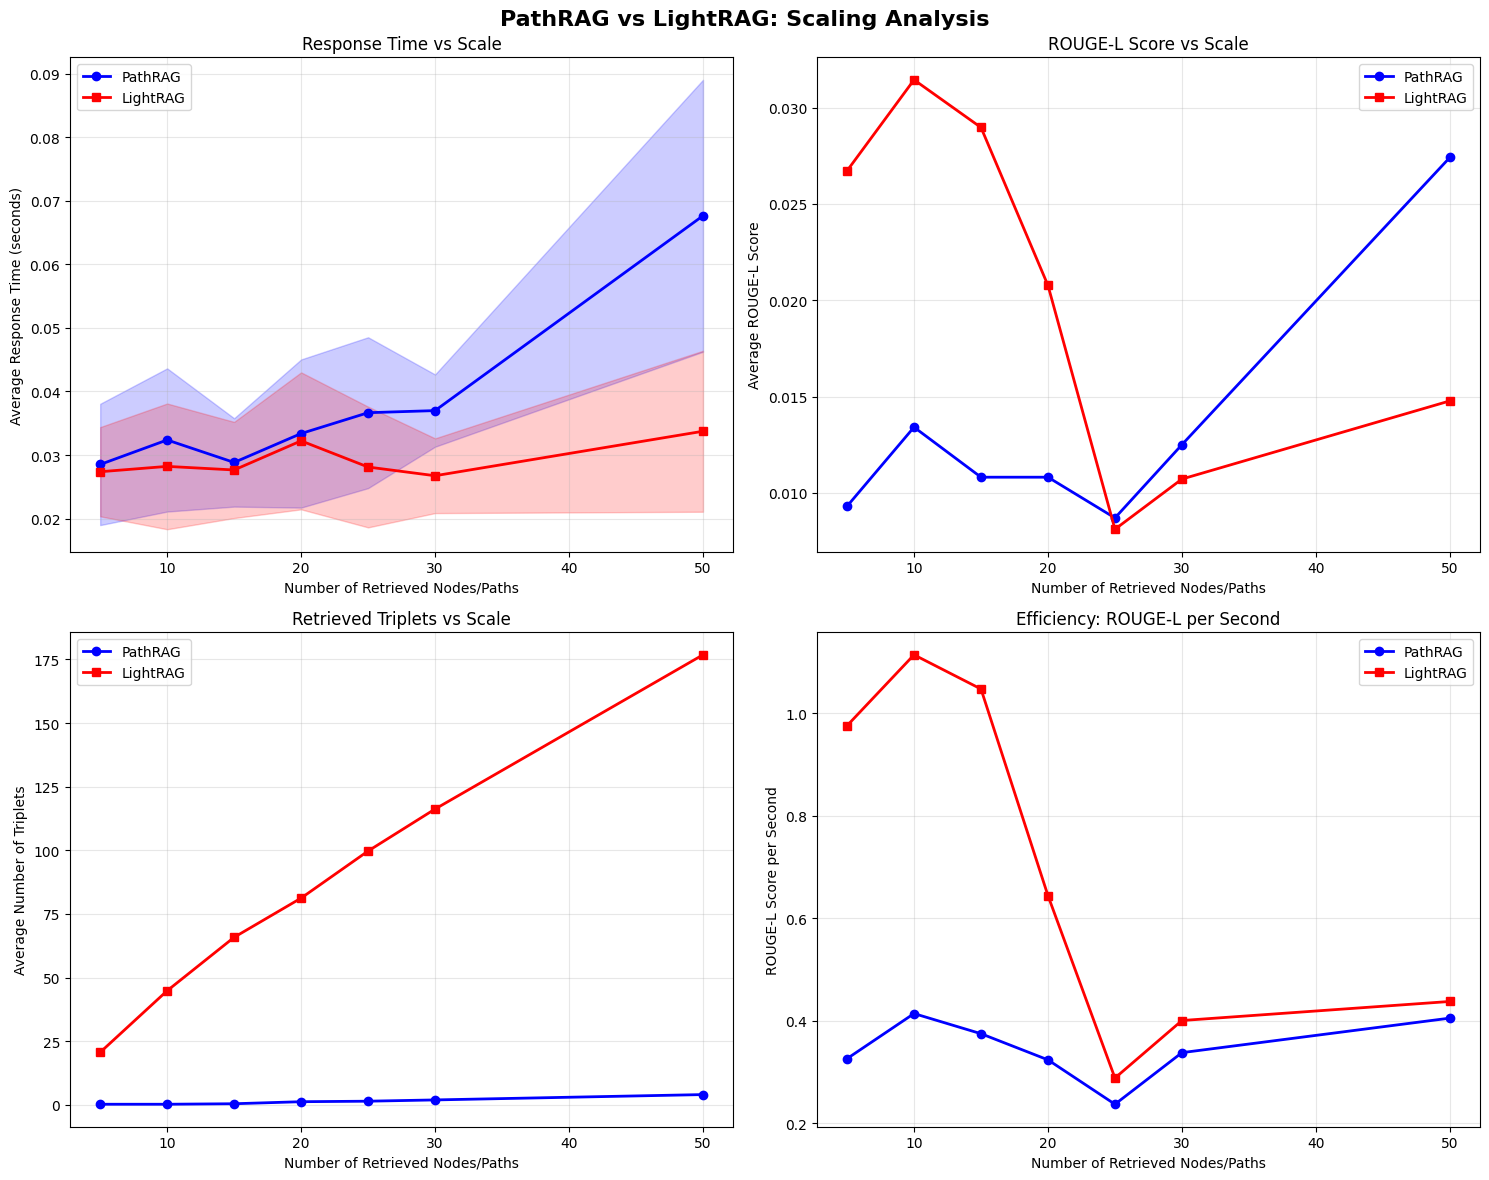

In [ ]:
plot_scaling_results()

## Comparison: GraphRAG vs Traditional RAG vs LightRAG vs PathRAG

| Aspect | **Traditional RAG** | **GraphRAG** | **LightRAG** | **PathRAG** |
|--------|-------------------|-------------|-------------|------------|
| **Knowledge Representation** | Flat vector embeddings | Hierarchical knowledge graph with communities | Dual-level graph (high-level relations + keywords) | Paths through knowledge graph |
| **Retrieval Strategy** | Semantic similarity (cosine distance) | Global (communities) + Local (graph traversal) | Hybrid keyword + entity retrieval | Path-based reasoning chains |
| **Global Reasoning** | Poor - limited to top-k similar chunks | Excellent - map-reduce over communities | 🟡 Moderate - aggregate keywords | 🟡 Moderate - through path patterns |
| **Multi-hop Reasoning** | Not supported | Native graph traversal | Supported via entity links | Core mechanism via paths |
| **Scalability** | Excellent - constant time lookup | 🟡 Moderate - community summaries scale | Good - efficient indexing | 🟡 Depends on path complexity |
| **Index Construction Cost** | Low - just embeddings | High - graph + communities + LLM summaries | 🟡 Medium - dual index | 🟡 Medium - path extraction |
| **Query Latency** | Very low (~ms) | High - multiple LLM calls | 🟡 Medium | 🟡 Medium |
| **Best Use Cases** | Simple fact lookup, high QPS | Complex synthesis, exploratory questions | Balance of speed and reasoning | Explicit reasoning chains |

<div style="background-color: #e1f5fe; padding: 15px; border-left: 5px solid #03a9f4; border-radius: 5px;">


<strong>Key Takeaway:</strong> No single approach dominates all scenarios. The choice depends on:
<ul>
<li><strong>Query Complexity:</strong> Simple facts → Traditional RAG; Complex synthesis → GraphRAG</li>
<li><strong>Latency Requirements:</strong> Real-time systems favor Traditional RAG/LightRAG</li>
<li><strong>Budget:</strong> GraphRAG has high indexing and query costs due to multiple LLM calls</li>
<li><strong>Dataset Structure:</strong> Highly interconnected knowledge benefits from graph-based methods</li>
</ul>
</div>

# 5. ✨ BRIGHT: Retrieve w/ Reasoning
<a name="bright"></a>

Traditionally, in RAG sysmtes, information relevance is determined by:

  * **Shared keywords:** Does the document contain the same words as the query?
  * **Semantic similarity:** Does the document talk about similar concepts, even if the exact words differ?

However, many real-world queries are complex and require **in-depth reasoning** to identify the truly relevant documents. Imagine these scenarios:

  * A programmer has an error message and needs to find the specific syntax documentation that explains the underlying issue, not just pages that mention the error.
  * An economist wants to find stories or examples that are explained by the same economic theory as a given situation, even if the surface details are completely different.

In these cases, simply matching words or general topics isn't enough. The system needs to *reason* about the query and the potential documents.

### 📉 Pitfalls of Previous Approaches

Existing retrieval benchmarks, like BEIR and MTEB, have been invaluable, but they primarily focus on fact-based, information-seeking queries. These often involve:

  * Queries aggregated from search engines (e.g., "Who sang 'I Think We're Alone Now'?").
  * A high degree of lexical (word) or semantic (meaning) overlap between the query and the relevant documents. For example, a query about "human activities influence climate system" would likely find documents also discussing "deforestation," "urbanization," and "emissions."

This means that current state-of-the-art models, which perform well on these benchmarks, might not be equipped for tasks demanding deeper reasoning.

### ✨ Introducing BRIGHT

To address this gap, **BRIGHT (Benchmarking Reasoning-Intensive Text Retrieval)** introduces the first text retrieval benchmark specifically designed to require **intensive reasoning** to connect queries with relevant documents.
The key idea is that relevance in BRIGHT goes beyond surface-form matching.

The benchmark consists of:

  * **1,384 real-world queries**
  * Spanning diverse domains like **economics, psychology, mathematics, and coding**
  * Queries drawn from **naturally occurring and carefully curated human data**


The authors implicitly defines a hierarchy of retrieval complexity, which we can visualize:

| Level | Type of Retrieval        | Query Example (from paper)                                                                 | Relevance Mechanism                                                                                                   | Typical Datasets      |
| :---- | :----------------------- | :----------------------------------------------------------------------------------------- | :-------------------------------------------------------------------------------------------------------------------- | :-------------------- |
| 🏷️   | **Level 1: Keyword-based** | "Who sang the song 'I Think We're Alone Now'?"                                 | Direct keyword matching.                                                                                  | Some parts of NQ, etc. |
| 🧠   | **Level 2: Semantic-based**| "How human activities influence climate system?"                               | Matching based on the meaning and concepts, even with different wording.                                    | NQ, MS MARCO |
| 💡   | **Level 3: Reasoning-based (BRIGHT)** | **Sustainable Living:** "At home, after I water my plants... Can I reuse it for my plants next time?" <br\> **Code:** "I have this table... I don't like UNPIVOT. Is there a better function...?" \<br\> **Math:** "Let k=2008^2+2^2008. What is the units digit of k^2+2^k?" | Requires intensive reasoning to determine relevance (e.g., risk of using recycled water, alternative function, using the same theorem). | **BRIGHT** |

BRIGHT focuses on this challenging "Level 3" retrieval.



**2️⃣ Finding 2: Querying with LLM-Generated Reasoning Steps Improves Retrieval 💡**

  * The researchers hypothesized that leveraging Large Language Models (LLMs) to generate explicit reasoning steps *about the query* could enhance retrieval.
  * **Method:** Prompt an LLM (like GPT-4 or Llama-3-70B) with the original query and ask it to:
    1.  Identify the essential problem.
    2.  Think step-by-step about what should be in relevant documents (Chain of Thought).
    3.  Draft an answer.
  * This "reasoning-enhanced" text was then used as the *new query* for the retrieval models.
  * **Result:** This approach led to significant improvements, with average nDCG@10 scores increasing by up to **12.2 points**.
  * Interestingly, **BM25 (the keyword-based model) showed the most improvement** with GPT-4 generated reasoning steps, potentially because these steps introduce relevant keywords that BM25 can latch onto, while LLM-generated queries might be out-of-distribution for trained dense models.
  * Even with this boost, the best score using GPT-4 reasoning with BM25 was still below 30 nDCG@10 (27.0), indicating substantial room for improvement.

**3️⃣ Finding 3: Retrieval Augmentation Boosts Downstream Question Answering (QA) Performance 📈**

  * A key application of retrieval is Retrieval Augmented Generation (RAG), where retrieved documents help an LLM generate better answers.
  * The study tested this on StackExchange datasets: retrieved documents were fed to Claude-3.5-sonnet to answer the original post's question.
  * **Result:** Stronger retrievers (those performing better on BRIGHT) generally led to better QA performance. For example, using documents from Qwen (the best BRIGHT retriever) improved QA scores by 1.9 points over no retrieval.
  * However, using the **oracle (gold) documents** boosted QA performance by 4.1 points, highlighting that *improving the reasoning-intensive retrieval step itself has significant potential to enhance downstream tasks*.

## 🔍 Building a Vector Database

### Load a Subset of the BRIGHT Dataset

To construct a vector database, we first need a collection of documents that will populate our vector space.

These documents will serve as the knowledge base for our retrieval system—meaning they'll be the sources the model will refer to when answering questions based on context.

To this end will utilize the [BRIGHT dataset](https://huggingface.co/datasets/xlangai/BRIGHT).

In [ ]:
from datasets import load_dataset

# Get the subset of the BRIGHT dataset containing the documents
ds_bright_documents = load_dataset("xlangai/BRIGHT", "documents")

# Get the subset of the BRIGHT dataset containing examples of queries to perform
ds_bright_examples = load_dataset("xlangai/BRIGHT", "examples")

README.md: 0.00B [00:00, ?B/s]

documents/biology-00000-of-00001.parquet:   0%|          | 0.00/11.0M [00:00<?, ?B/s]

documents/earth_science-00000-of-00001.p(…):   0%|          | 0.00/23.1M [00:00<?, ?B/s]

documents/economics-00000-of-00001.parqu(…):   0%|          | 0.00/11.0M [00:00<?, ?B/s]

documents/psychology-00000-of-00001.parq(…):   0%|          | 0.00/11.4M [00:00<?, ?B/s]

documents/robotics-00000-of-00001.parque(…):   0%|          | 0.00/7.87M [00:00<?, ?B/s]

documents/stackoverflow-00000-of-00001.p(…):   0%|          | 0.00/39.5M [00:00<?, ?B/s]

documents/sustainable_living-00000-of-00(…):   0%|          | 0.00/11.7M [00:00<?, ?B/s]

documents/pony-00000-of-00001.parquet:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

documents/leetcode-00000-of-00001.parque(…):   0%|          | 0.00/211M [00:00<?, ?B/s]

documents/aops-00000-of-00001.parquet:   0%|          | 0.00/65.3M [00:00<?, ?B/s]

documents/theoremqa_theorems-00000-of-00(…):   0%|          | 0.00/7.63M [00:00<?, ?B/s]

Generating biology split:   0%|          | 0/57359 [00:00<?, ? examples/s]

Generating earth_science split:   0%|          | 0/121249 [00:00<?, ? examples/s]

Generating economics split:   0%|          | 0/50220 [00:00<?, ? examples/s]

Generating psychology split:   0%|          | 0/52835 [00:00<?, ? examples/s]

Generating robotics split:   0%|          | 0/61961 [00:00<?, ? examples/s]

Generating stackoverflow split:   0%|          | 0/107081 [00:00<?, ? examples/s]

Generating sustainable_living split:   0%|          | 0/60792 [00:00<?, ? examples/s]

Generating pony split:   0%|          | 0/7894 [00:00<?, ? examples/s]

Generating leetcode split:   0%|          | 0/413932 [00:00<?, ? examples/s]

Generating aops split:   0%|          | 0/188002 [00:00<?, ? examples/s]

Generating theoremqa_theorems split:   0%|          | 0/23839 [00:00<?, ? examples/s]

Generating theoremqa_questions split:   0%|          | 0/188002 [00:00<?, ? examples/s]

examples/biology-00000-of-00001.parquet:   0%|          | 0.00/201k [00:00<?, ?B/s]

examples/earth_science-00000-of-00001.pa(…):   0%|          | 0.00/184k [00:00<?, ?B/s]

examples/economics-00000-of-00001.parque(…):   0%|          | 0.00/220k [00:00<?, ?B/s]

examples/psychology-00000-of-00001.parqu(…):   0%|          | 0.00/184k [00:00<?, ?B/s]

examples/robotics-00000-of-00001.parquet:   0%|          | 0.00/179k [00:00<?, ?B/s]

examples/stackoverflow-00000-of-00001.pa(…):   0%|          | 0.00/250k [00:00<?, ?B/s]

examples/sustainable_living-00000-of-000(…):   0%|          | 0.00/218k [00:00<?, ?B/s]

examples/pony-00000-of-00001.parquet:   0%|          | 0.00/27.7k [00:00<?, ?B/s]

examples/leetcode-00000-of-00001.parquet:   0%|          | 0.00/169k [00:00<?, ?B/s]

examples/aops-00000-of-00001.parquet:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

examples/theoremqa_theorems-00000-of-000(…):   0%|          | 0.00/124k [00:00<?, ?B/s]

examples/theoremqa_questions-00000-of-00(…):   0%|          | 0.00/1.49M [00:00<?, ?B/s]

Generating biology split:   0%|          | 0/103 [00:00<?, ? examples/s]

Generating earth_science split:   0%|          | 0/116 [00:00<?, ? examples/s]

Generating economics split:   0%|          | 0/103 [00:00<?, ? examples/s]

Generating psychology split:   0%|          | 0/101 [00:00<?, ? examples/s]

Generating robotics split:   0%|          | 0/101 [00:00<?, ? examples/s]

Generating stackoverflow split:   0%|          | 0/117 [00:00<?, ? examples/s]

Generating sustainable_living split:   0%|          | 0/108 [00:00<?, ? examples/s]

Generating pony split:   0%|          | 0/112 [00:00<?, ? examples/s]

Generating leetcode split:   0%|          | 0/142 [00:00<?, ? examples/s]

Generating aops split:   0%|          | 0/111 [00:00<?, ? examples/s]

Generating theoremqa_theorems split:   0%|          | 0/76 [00:00<?, ? examples/s]

Generating theoremqa_questions split:   0%|          | 0/194 [00:00<?, ? examples/s]

In [ ]:
bright_splits = list(ds_bright_examples.keys())
print("Splits (equal in both datasets):\n")
for split in bright_splits:
    print(f"- {split}")

print()
print("-"*50)

print("\nFeatures:\n")
print("BRIGHT documents dataset features:")
print(ds_bright_documents[bright_splits[0]])
print("\nBRIGHT example dataset features:")
print(ds_bright_examples[bright_splits[0]])

Splits (equal in both datasets):

- biology
- earth_science
- economics
- psychology
- robotics
- stackoverflow
- sustainable_living
- pony
- leetcode
- aops
- theoremqa_theorems
- theoremqa_questions

--------------------------------------------------

Features:

BRIGHT documents dataset features:
Dataset({
    features: ['id', 'content'],
    num_rows: 57359
})

BRIGHT example dataset features:
Dataset({
    features: ['query', 'reasoning', 'id', 'excluded_ids', 'gold_ids_long', 'gold_ids', 'gold_answer'],
    num_rows: 103
})


### Encode the Documents into Vectors

Now that we have our documents, the next step is to convert them into numerical representations called **embeddings**. These embeddings capture the semantic meaning of each document and allow us to compare them efficiently.

To do this, we use the [sentence-transformers](https://sbert.net) library, which provides easy access to powerful models that convert text into embeddings. These models are built on top of transformer architectures like BERT and are fine-tuned specifically for tasks like semantic search and sentence similarity.

In this example we will use [jina-embeddings-v3](https://huggingface.co/jinaai/jina-embeddings-v3), which is a multilingual multi-task text embedding model designed for a variety of NLP applications.

Jina V3 embeddings support **asymmetric retrieval**, meaning they treat queries and documents differently when generating embeddings.

- `retrieval.query` is used to encode questions or search queries (usually short).
- `retrieval.passage` is used to encode documents or passages (usually longer and informative).

This separation allows the model to optimize each type for its specific role, improving retrieval accuracy.

Asymmetric retrieval is common in modern search and QA systems, where the model learns to match different kinds of inputs — like questions to answers — more effectively by encoding them differently.

In [ ]:
from sentence_transformers import SentenceTransformer

# Instanciate the embedding model
model_emb = SentenceTransformer("jinaai/jina-embeddings-v3", trust_remote_code=True)

# Set the task
task = "retrieval.passage"

modules.json:   0%|          | 0.00/378 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/464 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

custom_st.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/jina-embeddings-v3:
- custom_st.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


config.json: 0.00B [00:00, ?B/s]

configuration_xlm_roberta.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- configuration_xlm_roberta.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
`torch_dtype` is deprecated! Use `dtype` instead!


modeling_lora.py: 0.00B [00:00, ?B/s]

modeling_xlm_roberta.py: 0.00B [00:00, ?B/s]

rotary.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- rotary.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


embedding.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- embedding.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


mlp.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- mlp.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


block.py: 0.00B [00:00, ?B/s]

stochastic_depth.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- stochastic_depth.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


mha.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- mha.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- block.py
- stochastic_depth.py
- mha.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


xlm_padding.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- xlm_padding.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- modeling_xlm_roberta.py
- rotary.py
- embedding.py
- mlp.py
- block.py
- xlm_padding.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- modeling_lora.py
- modeling_xlm_roberta.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
`torch_dtype` is deprecated! Use `d

model.safetensors:   0%|          | 0.00/1.14G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/192 [00:00<?, ?B/s]

In [ ]:
import numpy as np
from tqdm import tqdm
import torch
from typing import List, Dict, Tuple

# Parameters to control the embedding generation
entries_per_split = 5
number_of_splits = 2
bright_subset_splits = bright_splits[:number_of_splits]

# Batch processing parameters for optimal GPU utilization
BATCH_SIZE = 12
MAX_CONTENT_LENGTH = 8192

In [ ]:
def collect_all_documents() -> Tuple[List[str], List[Dict]]:
    """
    Phase 1: Collect ALL matching documents from ALL splits
    This separates data collection from GPU processing for maximum efficiency
    """
    all_contents = []
    all_metadata = []

    print("Phase 1: Collecting all matching documents...")

    # Process each split to collect documents
    for split_name in tqdm(bright_subset_splits, desc="Collecting from splits"):
        # Get example dataset for this split
        example_dataset = ds_bright_examples[split_name].select(range(entries_per_split))

        # Extract root IDs (remove .txt suffix)
        root_ids = {
            gold_id.removesuffix('.txt')
            for entry in example_dataset
            for gold_id in entry['gold_ids_long']
        }

        # Collect all matching documents from this split
        split_docs_collected = 0
        for doc in ds_bright_documents[split_name]:
            doc_id = doc['id']
            if any(doc_id.startswith(root) for root in root_ids):
                content = doc['content']

                # Optional: truncate very long documents for memory efficiency
                if len(content) > MAX_CONTENT_LENGTH:
                    content = content[:MAX_CONTENT_LENGTH]

                all_contents.append(content)
                all_metadata.append({
                    'id': doc_id,
                    'split': split_name,
                })
                split_docs_collected += 1

        print(f"\n{split_name}: collected {split_docs_collected} documents")

    total_docs = len(all_contents)
    print(f"\nPhase 1 Complete: Collected {total_docs} documents total")
    return all_contents, all_metadata

def encode_all_documents_in_batches(contents: List[str], metadata: List[Dict]) -> Tuple[np.ndarray, List[Dict]]:
    """
    Phase 2: Process ALL documents in optimal batches for maximum GPU utilization
    """
    if not contents:
        return np.array([]), []

    print(f"\nPhase 2: Encoding {len(contents)} documents in batches of {BATCH_SIZE}...")

    all_embeddings = []
    valid_metadata = []
    total_batches = (len(contents) + BATCH_SIZE - 1) // BATCH_SIZE

    # Process in batches for optimal GPU memory usage and parallelism
    for i in tqdm(range(0, len(contents), BATCH_SIZE),
                  desc="Encoding batches",
                  total=total_batches):

        batch_contents = contents[i:i + BATCH_SIZE]
        batch_metadata = metadata[i:i + BATCH_SIZE]

        try:
            # This is where the magic happens - GPU processes entire batch in parallel
            batch_embeddings = model_emb.encode(
                batch_contents,
                task=task,
                prompt_name=task,
                batch_size=len(batch_contents),  # Process full batch at once
                show_progress_bar=False,
                convert_to_numpy=True,
                normalize_embeddings=True,  # Often beneficial for similarity search
            )

            # Collect successful encodings
            all_embeddings.append(batch_embeddings)
            valid_metadata.extend(batch_metadata)

        except Exception as e:
            print(f"Batch {i//BATCH_SIZE + 1} failed: {e}")
            # Optionally try individual documents in failed batch
            for j, (content, meta) in enumerate(zip(batch_contents, batch_metadata)):
                try:
                    single_embedding = model_emb.encode(
                        [content], task=task, prompt_name=task
                    )
                    all_embeddings.append(single_embedding)
                    valid_metadata.append(meta)
                except Exception as single_e:
                    print(f"  Failed individual doc {meta['id']}: {single_e}")

    # Efficiently combine all embeddings
    if all_embeddings:
        final_embeddings = np.vstack(all_embeddings)
        return final_embeddings, valid_metadata
    else:
        return np.array([]), []

print("Starting optimized embedding generation with global batching...\n")

# Phase 1: Collect all documents from all splits
all_contents, all_metadata = collect_all_documents()

if not all_contents:
    print("No documents found to process!")
    final_embeddings = np.array([])
    all_metadata = []
else:
    # Phase 2: Encode everything in optimal batches
    final_embeddings, all_metadata = encode_all_documents_in_batches(all_contents, all_metadata)

    # Results summary
    print(f"\nEncoding Complete!")
    print(f"   📊 Total embeddings: {final_embeddings.shape[0]}")
    print(f"   🔢 Embedding dimension: {final_embeddings.shape[1] if len(final_embeddings) > 0 else 'N/A'}")
    print(f"   💾 Memory usage: {final_embeddings.nbytes / 1e6:.1f} MB")

# Optional: GPU cleanup
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"   🚀 GPU memory cleared")

print("\nDone!")

Starting optimized embedding generation with global batching...

Phase 1: Collecting all matching documents...



biology: collected 239 documents



earth_science: collected 326 documents

Phase 1 Complete: Collected 565 documents total

Phase 2: Encoding 565 documents in batches of 12...


Encoding batches: 100%|██████████| 48/48 [01:56<00:00,  2.43s/it]


✅ Encoding Complete!
   📊 Total embeddings: 565
   🔢 Embedding dimension: 1024
   💾 Memory usage: 2.3 MB
   🚀 GPU memory cleared

Done!


### Create the FAISS Vector Database

Now that we have numerical embeddings for all our document sections, we need a way to store and search through them efficiently.

We'll use [**FAISS**](https://ai.meta.com/tools/faiss/) (Facebook AI Similarity Search), a powerful library for fast similarity search in vector spaces.

In this step, we'll create a **flat index**.

A flat index is the simplest type of vector index (index which dictates how embeddings are arranged in the vectorial space). It uses a brute-force search method—comparing each query to every vector in the dataset.

- Advantages: It's simple, requires no training, and gives 100% accurate results.

- Disadvantages: It’s slow for large datasets because it checks every vector during search.

Flat indices are great for small datasets, but not ideal for real-time search in large-scale applications.

In our case, we can add our document vectors to the flat index. This means FAISS will internally store them and make them searchable based on vector similarity (e.g., cosine or L2 distance).


In [ ]:
import faiss

# Initialize a FAISS flat index using L2 (Euclidean) distance
index_flat = faiss.IndexFlatL2(final_embeddings.shape[1])

# Add all document embeddings to the index
index_flat.add(final_embeddings)

# Print the total number of indexed vectors (should match number of document sections)
print(f"Total number of vectors in the index: {index_flat.ntotal}")

✅ Total number of vectors in the index: 565


### Produce the query

In this step, we'll use the BRIGHT method to perform **LLM-augmented retrieval**.

Here's what we'll do:

1. **Display**:

  - The user query
  - The expected documents to retrieve
  - The ground-truth answer (gold answer)

2. **Augment the query** using the BRIGHT prompt template, which helps the model reason more effectively:

  ```
  {question}.
  (1) Identify the essential problem in the post.
  (2) Think step by step to reason about what should be included in the relevant documents.
  (3) Draft an answer
  ```

3. **Embed the model's response** and use it to perform retrieval.

4. **Re-prompt the model**, this time combining:

  - The original query
  - The documents retrieved using the BRIGHT-augmented embedding

  This additional context helps the model produce a more accurate and complete answer.


In [ ]:
# Select a specific example from the first split of the dataset
example = ds_bright_examples[bright_splits[0]].select(range(entries_per_split))[1]

# Extract key fields
query = example['query']
gold_ids = example['gold_ids']
gold_answer = example['gold_answer']

separator = "\n" + "=" * 50 + "\n"

# Print the Query
print(separator)
print("📌 QUERY")
print(query)

# Print the Gold Document IDs
print(separator)
print("📁 GOLD DOCUMENT IDS")
for idx, doc_id in enumerate(gold_ids, 1):
    print(f"{idx}. {doc_id}")

# Print the Gold Answer
print(separator)
print("GOLD ANSWER")
print(gold_answer.strip())
print(separator)




📌 QUERY
Why do I only breathe out of one nostril?
I was just sitting with my hand next to my nose and I realized that air was only coming out of the right nostril. Why is that? I would think I would use both, it seems much more efficient. Have I always only been breathing out of my right nostril?


📁 GOLD DOCUMENT IDS
1. breathe_out_of_one_nostril/Nasal_cycle_3.txt
2. breathe_out_of_one_nostril/Nasal_cycle_0.txt
3. breathe_out_of_one_nostril/Nasal_cycle_1.txt
4. breathe_out_of_one_nostril/Nasal_cycle_4.txt
5. breathe_out_of_one_nostril/Nasal_cycle_2.txt
6. breathe_out_of_one_nostril/Nasal_cycle_5.txt


✅ GOLD ANSWER
$\begingroup$

Apparently you're not the first person to notice this; in 1895, a German nose
specialist called Richard Kayser found that we have tissue called erectile
tissue in our noses (yes, it is very similar to the tissue found in a penis).
This tissue swells in one nostril and shrinks in the other, creating an open
airway via only one nostril. What's more, he found 

In [ ]:
# Define the prompt template following the BRIGHT setup
template = """{question}
(1) Identify the essential problem in the post.
(2) Think step by step to reason about what should be included in the relevant documents.
(3) Draft an answer
"""

# Ask the question and display the output
result = ask_and_display_response(model_llm, query, template)

### 🤖 Final Answer
(1) **Identify the essential problem in the post**:  
The user is observing a persistent asymmetry in nasal airflow, where air only exits through the right nostril. This raises questions about the underlying cause, such as anatomical factors, habits, or physiological conditions. The core issue is to determine why one nostril is functioning differently, whether it's a temporary phenomenon or a chronic condition.

(2) **Think step by step to reason about what should be included in the relevant documents**:  
- **Anatomical factors**: Check for a deviated septum, nasal polyps, or structural abnormalities.  
- **Physiological factors**: Consider nasal congestion, allergies, or sinus issues that may block one nostril.  
- **Habitual or environmental factors**: Assess if the user’s posture, habits (e.g., using a hand to block the other nostril), or lifestyle (e.g., smoking) contribute to this asymmetry.  
- **Medical conditions**: Rule out chronic issues like chronic sinusitis, nasal cancer, or congenital anomalies.  
- **Temporary causes**: Account for transient factors like a cold, infection, or temporary blockage.  

(3) **Draft an answer**:  
The phenomenon of breathing predominantly from one nostril is likely due to a combination of anatomical, physiological, or habitual factors. Common causes include:  
- **Anatomical asymmetry**: A deviated septum, nasal polyps, or structural abnormalities may block one nostril.  
- **Nasal congestion or blockage**: Infections, allergies, or sinus issues can cause one nostril to be less functional.  
- **Habitual or environmental factors**: Sitting with the head tilted or using a hand to block the other nostril may temporarily or permanently alter airflow.  
- **Chronic conditions**: Rarely, persistent asymmetry could signal a medical issue like chronic sinusitis or a deviated septum.  

It is not uncommon to breathe more efficiently from one nostril, and this can vary over time. If the asymmetry persists, worsens, or causes discomfort, consulting a healthcare professional is advisable to rule out underlying conditions. For most people, it is a temporary or situational phenomenon.

In [ ]:
# IMPORTANT! Define the task type for the embedding model
# For Jina
task = "retrieval.query"

# Encode the LLM-generated answer following the BRIGHT method
embedding_llm = model_emb.encode(
    result['answer'],
    task=task,
    prompt_name=task,
)

# Encode the original human-written query for comparison
embedding_query = model_emb.encode(
    question,
    task=task,
    prompt_name=task,
)

In [ ]:
###########################################
# Ground-truth document IDs for reference #
###########################################

print("Ground-truth document IDs:")
for gold_id in gold_ids:
    print(gold_id)

print("\n" + "="*60 + "\n")

# Number of documents to retrieve
top_k = 5


###################################################
# Retrieve using the LLM answer (BRIGHT approach) #
###################################################

print("🤖 Retrieval using LLM-generated answer:\n")

D_llm, I_llm = index_flat.search(np.array([embedding_llm]), top_k)

print("Top-k distances:", D_llm[0])
print("Top-k indices:", I_llm[0])

print("\n🔍 Retrieved document metadata:")
for rank, idx in enumerate(I_llm[0]):
    doc_meta = all_metadata[idx]
    print(f"{rank+1}: {doc_meta['id']} | Split: {doc_meta['split']}")

print("\n" + "="*60 + "\n")



#################################
# Retrieve using original query #
#################################

print("📚 Retrieval using original query:\n")

D_query, I_query = index_flat.search(np.array([embedding_query]), top_k)

print("Top-k distances:", D_query[0])
print("Top-k indices:", I_query[0])

print("\n🔍 Retrieved document metadata:")
for rank, idx in enumerate(I_query[0]):
    doc_meta = all_metadata[idx]
    print(f"{rank+1}: {doc_meta['id']} | Split: {doc_meta['split']}")

✅ Ground-truth document IDs:
breathe_out_of_one_nostril/Nasal_cycle_3.txt
breathe_out_of_one_nostril/Nasal_cycle_0.txt
breathe_out_of_one_nostril/Nasal_cycle_1.txt
breathe_out_of_one_nostril/Nasal_cycle_4.txt
breathe_out_of_one_nostril/Nasal_cycle_2.txt
breathe_out_of_one_nostril/Nasal_cycle_5.txt


🤖 Retrieval using LLM-generated answer:

Top-k distances: [0.90620947 0.9181917  1.1326647  1.1398718  1.1408758 ]
Top-k indices: [108 109 107 112 111]

🔍 Retrieved document metadata:
1: breathe_out_of_one_nostril/Nasal_cycle_4.txt | Split: biology
2: breathe_out_of_one_nostril/Nasal_cycle_5.txt | Split: biology
3: breathe_out_of_one_nostril/Nasal_cycle_2.txt | Split: biology
4: breathe_out_of_one_nostril/Nasal_cycle_0.txt | Split: biology
5: breathe_out_of_one_nostril/Nasal_cycle_1.txt | Split: biology


📚 Retrieval using original query:

Top-k distances: [1.5759256 1.6621356 1.7361348 1.7389336 1.7458446]
Top-k indices: [344 411 319 241 438]

🔍 Retrieved document metadata:
1: hurricanes_i

### Get the augmented answer

In [ ]:
print("No RAG answer:")
result = ask_and_display_response(model_llm, query)
print("\n" + "="*60 + "\n")

D_llm, I_llm = index_flat.search(np.array([embedding_llm]), top_k)

doc_retrieved = []
for rank, idx in enumerate(I_llm[0]):
    doc_meta = all_metadata[idx]
    doc_retrieved.append(doc_meta['id'])

docs = ds_bright_documents["biology"].filter(lambda x: x["id"] in doc_retrieved)['content']

print("RAG answer:")
template = """Context:""" + "".join(docs) + """\nQuery: {question}"""
result = ask_and_display_response(model_llm, query, template)

print("\n" + "="*60 + "\n")

print("\nGold Answer:\n", gold_answer)

No RAG answer:


### 🤖 Final Answer
It's fascinating how the human body can sometimes compensate for a minor imbalance. Here's a breakdown of possible reasons why you might only breathe out of one nostril:

### 1. **Temporary Factors**  
   - **Posture or Positioning**: If you're sitting with your hand next to your nose, your head might be tilted slightly, causing one nostril to appear "blocked." This is temporary and often resolves when you adjust your position.  
   - **Nasal Obstruction**: A small blockage (e.g., a polyp, scar, or minor swelling) in one nostril can make breathing through the other less efficient. However, this is usually subtle and may not be noticeable unless you're aware of it.  
   - **Habit or Preference**: Some people naturally favor one nostril, especially if they've used a specific method (e.g., blowing their nose or using a nasal spray) to clear the other.  

---

### 2. **Possible Medical Causes**  
   - **Nasal Obstruction**: A deviated septum, nasal polyps, or a structural issue could block one nostril. If you’ve recently had a cold, sinus infection, or a nasal injury, this might be temporary.  
   - **Allergies or Inflammation**: Chronic allergies or sinusitis can cause one nostril to feel narrower or blocked.  
   - **Nerve Issues**: Rarely, a nerve issue (e.g., a facial nerve palsy) might affect nasal airflow.  

---

### 3. **Why It Seems Inefficient**  
   - The body adapts to airflow. If one nostril is consistently blocked, the brain may prioritize the other, making it feel "more efficient." However, this is a physiological adjustment, not a medical issue.  

---

### When to Worry  
If the issue persists, worsens, or is accompanied by:  
- Persistent pain or pressure  
- Changes in smell or hearing  
- A lump or swelling in the nose  
- Frequent nasal congestion or discharge  

**Recommendation**: Monitor the situation. If it resolves without symptoms, it’s likely temporary. If it persists or causes concern, consult a healthcare provider for a thorough evaluation.  

In summary, it’s often a minor, temporary phenomenon—no cause for alarm unless there are underlying symptoms. 😊

Filter:   0%|          | 0/57359 [00:00<?, ? examples/s]

RAG answer:


### 🤖 Final Answer
The nasal cycle is a natural, involuntary process that alternates between congestion and decongestion of the nasal turbinates (bony structures in the nose) to optimize airflow and nasal function. Here’s why you might consistently breathe out of one nostril:

### 1. **Normal Physiological Regulation**  
   - The nasal cycle ensures one side of the nose is always more moist and humidified, which is essential for effective olfactory function (smell). The **affected side** (e.g., your right nostril) becomes more congested due to increased blood flow and mucus production, while the opposite side decongests.  
   - This alternation is controlled by the **autonomic nervous system** and is not a fixed preference but a natural response to nasal congestion.

### 2. **Why One Side is More Active**  
   - The **right nostril** may become more congested due to factors like **posture**, **dormant nasal obstruction**, or **inflammation** (e.g., from a cold or sinus issue). The body prioritizes airflow through the more active side to maintain nasal function.  
   - The cycle is **unconscious** and varies with age, body position, and other factors. For example, lying down may make the **dependent nostril** (the one less frequently used) more congested.

### 3. **Efficiency vs. Unilateral Breathing**  
   - The nasal cycle is **not inefficient**. The body’s natural alternation ensures optimal airflow and humidification. Even if you feel like you’re using both nostrils, the cycle is a **physiological adaptation** to maintain nasal health.  
   - The **sensation of "using only one nostril"** is normal and temporary. The cycle is designed to balance airflow and prevent nasal dryness or irritation.

### 4. **When to Worry**  
   - If you consistently breathe from one nostril and experience **persistent congestion**, **discomfort**, or **recurrent sinus issues**, consult a healthcare professional. This could indicate **nasal obstruction**, **sinus inflammation**, or other conditions.

### Summary  
The nasal cycle is a **normal, involuntary process** that alternates congestion and decongestion of the nasal turbinates. Your experience of breathing from one nostril is a **natural, physiological response** to maintain nasal function. It’s not a sign of illness and is not inefficient. The cycle ensures airflow is optimized for humidification and olfactory sensitivity. If symptoms persist, further evaluation may be needed.




Gold Answer:
 $\begingroup$

Apparently you're not the first person to notice this; in 1895, a German nose
specialist called Richard Kayser found that we have tissue called erectile
tissue in our noses (yes, it is very similar to the tissue found in a penis).
This tissue swells in one nostril and shrinks in the other, creating an open
airway via only one nostril. What's more, he found that this is indeed a
'nasal cycle', changing every 2.5 hours or so. Of course, the other nostril
isn't completely blocked, just mostly. If you try, you can feel a very light
push of air out of the blocked nostril.

This is controlled by the autonomic nervous system. You can change which
nostril is closed and which is open by laying on one side to open the opposite
one.

Interestingly, some researchers think that this is the reason we often switch
the sides we lay on during sleep rather regularly, as it is more comfortable
to sleep on the side with the blocked nostril downwards.

As to why we don't bre

### 📊 Retrieval Evaluation

To assess the effectiveness of each retrieval strategy, we use standard evaluation metrics:

- **Recall@k**

  How many of the correct (ground-truth) documents were retrieved in the top k results?

  Higher recall means that more ground-truth documents are correctly present in the top k results.

- **Precision@k**

  Of the top k retrieved documents, how many were actually correct?

  Higher precision means an higher number of correct documents is present in the top k results.

- **Hit@k**

  Did we get at least one correct document in the top k?

  It's a simple yes/no check — useful for evaluating minimal success.

- **nDCG@k** (Normalized Discounted Cumulative Gain)

  A metric that considers both relevance and ranking position — giving more weight to correct documents that appear earlier (top-spots) in the list.

  Useful for evaluating how well the model ranks the most useful documents (quality of the ranked results).

These metrics help us understand not just whether we're retrieving the right documents, but also how well we're prioritizing them.



In [ ]:
def dcg(relevances):
    return sum(rel / np.log2(idx + 2) for idx, rel in enumerate(relevances))

def ndcg_at_k(retrieved_ids, gold_ids, k):
    retrieved_ids_k = retrieved_ids[:k]
    relevances = [1 if doc_id in gold_ids else 0 for doc_id in retrieved_ids_k]
    ideal_relevances = sorted(relevances, reverse=True)

    dcg_val = dcg(relevances)
    idcg_val = dcg(ideal_relevances)

    return round(dcg_val / idcg_val, 3) if idcg_val > 0 else 0.0


def evaluate_retrieval(retrieved_ids, gold_ids, k):
    retrieved_set = set(retrieved_ids[:k])
    gold_set = set(gold_ids)

    relevant_retrieved = retrieved_set & gold_set
    num_relevant_retrieved = len(relevant_retrieved)

    recall = num_relevant_retrieved / len(gold_set) if gold_set else 0.0
    precision = num_relevant_retrieved / k
    hit = 1.0 if num_relevant_retrieved > 0 else 0.0
    ndcg = ndcg_at_k(retrieved_ids, gold_ids, k)

    return {
        f"Recall@{k}": round(recall, 3),
        f"Precision@{k}": round(precision, 3),
        f"Hit@{k}": round(hit, 3),
        f"nDCG@{k}": ndcg
    }

In [ ]:
from collections import defaultdict

# Evaluation parameters
top_k = 5

# Store aggregated metrics
metrics_sum_llm = defaultdict(float)
metrics_sum_query = defaultdict(float)
metrics_sum_gold_reasoning = defaultdict(float)
num_evaluated = 0

# Loop through splits and examples
for split in bright_splits[:number_of_splits]:
    examples = ds_bright_examples[split].select(range(entries_per_split))

    for example in tqdm(examples, desc=f"Evaluating split {split}"):
        query = example['query']
        gold_ids = example['gold_ids']
        reasoning = example['reasoning']

        # Step 1: Generate LLM answer using BRIGHT-style prompt
        template = """{question}
(1) Identify the essential problem in the post.
(2) Think step by step to reason about what should be included in the relevant documents.
(3) Draft an answer
"""
        result = ask_and_display_response(model=model_llm, question=query, template=template, display_answer=False)

        # Step 2: Embed both LLM answer and original query
        task = "retrieval.query"
        embedding_llm = model_emb.encode(
            result['answer'],
            task=task,
            prompt_name=task
            )

        embedding_query = model_emb.encode(
            query,
            task=task,
            prompt_name=task
            )

        embedding_gold_reasoning = model_emb.encode(
            reasoning,
            task=task,
            prompt_name=task
            )

        # Step 3: Perform retrieval
        _, I_llm = index_flat.search(np.array([embedding_llm]), top_k)
        _, I_query = index_flat.search(np.array([embedding_query]), top_k)
        _, I_gold_reasoning = index_flat.search(np.array([embedding_gold_reasoning]), top_k)

        retrieved_ids_llm = [all_metadata[i]['id'] for i in I_llm[0]]
        retrieved_ids_query = [all_metadata[i]['id'] for i in I_query[0]]
        retrieved_ids_gold_reasoning = [all_metadata[i]['id'] for i in I_gold_reasoning[0]]

        # Step 4: Evaluate and accumulate metrics
        metrics_llm = evaluate_retrieval(retrieved_ids_llm, gold_ids, top_k)
        metrics_query = evaluate_retrieval(retrieved_ids_query, gold_ids, top_k)
        metrics_gold_reasoning = evaluate_retrieval(retrieved_ids_gold_reasoning, gold_ids, top_k)

        for key in metrics_llm:
            metrics_sum_llm[key] += metrics_llm[key]
            metrics_sum_query[key] += metrics_query[key]
            metrics_sum_gold_reasoning[key] += metrics_gold_reasoning[key]

        num_evaluated += 1

# Step 5: Compute average scores
avg_metrics_llm = {k: round(v / num_evaluated, 3) for k, v in metrics_sum_llm.items()}
avg_metrics_query = {k: round(v / num_evaluated, 3) for k, v in metrics_sum_query.items()}
avg_metrics_gold_reasoning = {k: round(v / num_evaluated, 3) for k, v in metrics_sum_gold_reasoning.items()}

# Final Results
print(f"\nEvaluated {num_evaluated} examples across {number_of_splits} splits (Top-{top_k})\n")

print("\n📚 Average BRIGHT Performance – Original Query:")
for metric, value in avg_metrics_query.items():
    print(f"   {metric}: {value}")

print("\n🤖 Average BRIGHT Performance – LLM Answer:")
for metric, value in avg_metrics_llm.items():
    print(f"   {metric}: {value}")

print("\n⚜️ Average BRIGHT Performance – Gold Reasoning:")
for metric, value in avg_metrics_gold_reasoning.items():
    print(f"   {metric}: {value}")

Evaluating split earth_science: 100%|██████████| 5/5 [01:07<00:00, 13.50s/it]


✅ Evaluated 10 examples across 2 splits (Top-5)


📚 Average BRIGHT Performance – Original Query:
   Recall@5: 0.54
   Precision@5: 0.38
   Hit@5: 0.8
   nDCG@5: 0.654

🤖 Average BRIGHT Performance – LLM Answer:
   Recall@5: 0.573
   Precision@5: 0.4
   Hit@5: 0.8
   nDCG@5: 0.695

⚜️ Average BRIGHT Performance – Gold Reasoning:
   Recall@5: 0.407
   Precision@5: 0.32
   Hit@5: 0.7
   nDCG@5: 0.661


> ⁉️ Qwen3-**1.7B** is really better than Gemini ⁉️

### ModerColBERT Variant

[ModernColBERT](https://huggingface.co/lightonai/Reason-ModernColBERT) is a [late interaction](https://jina.ai/news/what-is-colbert-and-late-interaction-and-why-they-matter-in-search/) model trained for reasoning retrieval.

Based on the modernBERT architecture, it maps sentences & paragraphs to sequences of 128-dimensional dense vectors for semantic textual similarity tasks.

It achieves extremely competitive performance on the BRIGHT benchmark.

As we have done with the Jina embeddings, we will replicate the previous steps but with **ModernColBERT**:

1. **Embed the documents**
1. **Augment the query**
2. **Embed the model's response** and use it to perform retrieval.
3. **Re-prompt the model** with the additional context

In [ ]:
from pylate import models

model_emb = models.ColBERT(
    model_name_or_path="lightonai/Reason-ModernColBERT",
)

In [ ]:
from pylate import indexes, models
import numpy as np
from tqdm import tqdm
import torch
from typing import List, Tuple, Dict
import gc

# Initialize Voyager index
index = indexes.Voyager(
    index_folder="pylate-index",
    index_name="index",
    override=True
)

INDEXING_CHUNK_SIZE = 1000  # Process indexing in chunks to manage memory

def collect_all_documents_optimized() -> Tuple[List[str], List[str], Dict[str, int]]:
    """
    Phase 1: Efficiently collect ALL documents with metadata tracking
    """
    all_doc_texts = []
    all_doc_ids = []
    split_stats = {}

    print("Phase 1: Collecting documents from all splits...")

    for split_name in tqdm(bright_subset_splits, desc="Processing splits"):
        # Get examples for current split
        example_dataset = ds_bright_examples[split_name].select(range(entries_per_split))

        # Extract root IDs efficiently
        root_ids = {
            gold_id.removesuffix('.txt')
            for entry in example_dataset
            for gold_id in entry['gold_ids_long']
        }

        # Collect documents from current split
        split_doc_count = 0
        for doc in ds_bright_documents[split_name]:
            doc_id = doc['id']
            if any(doc_id.startswith(root) for root in root_ids):
                try:
                    content = doc['content']

                    # Optional: truncate very long documents for ColBERT efficiency
                    if len(content.split()) > MAX_CONTENT_LENGTH:
                        content = ' '.join(content.split()[:MAX_CONTENT_LENGTH])

                    all_doc_texts.append(content)
                    all_doc_ids.append(doc_id)
                    split_doc_count += 1

                except Exception as e:
                    print(f"Failed to process doc {doc_id}: {e}")

        split_stats[split_name] = split_doc_count
        print(f"  {split_name}: {split_doc_count} documents")

    total_docs = len(all_doc_texts)
    print(f"\nPhase 1 Complete: {total_docs} documents collected")
    print(f"Split distribution: {split_stats}")

    return all_doc_texts, all_doc_ids, split_stats

def encode_documents_optimized(doc_texts: List[str]) -> np.ndarray:
    """
    Phase 2: Encode documents with optimal batching for ColBERT
    """

    print(f"\nPhase 2: Encoding {len(doc_texts)} documents...")
    print(f"Using batch size: {BATCH_SIZE}")

    # Check GPU memory before starting
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print(f"GPU memory available: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f}GB")

    try:
        # ColBERT encoding with optimized parameters
        document_embeddings = model_emb.encode(
            doc_texts,
            batch_size=BATCH_SIZE,  # Optimized batch size
            is_query=False,  # Document encoding mode
            show_progress_bar=True,
            # Additional ColBERT optimizations
            convert_to_tensor=False,  # Keep as numpy for memory efficiency
        )

        print(f"Encoding complete! Shape: ({len(document_embeddings)},{document_embeddings[0].shape[1]})")
        return document_embeddings

    except torch.cuda.OutOfMemoryError:
        print(" GPU OOM detected, reducing batch size...")
        # Fallback with smaller batch size
        smaller_batch_size = max(1, BATCH_SIZE // 2)
        document_embeddings = model_emb.encode(
            doc_texts,
            batch_size=smaller_batch_size,
            is_query=False,
            show_progress_bar=True,
        )
        print(f"Encoding complete with reduced batch size: ({len(document_embeddings)}, {document_embeddings[0].shape[1]})")
        return document_embeddings

    except Exception as e:
        print(f"Encoding failed: {e}")
        return np.array([])

def index_documents_chunked(doc_ids: List[str], embeddings: np.ndarray) -> None:
    """
    Phase 3: Index documents in chunks for memory efficiency
    """
    if len(embeddings) == 0:
        print("No embeddings to index!")
        return

    total_docs = len(doc_ids)
    print(f"\nPhase 3: Indexing {total_docs} documents...")

    # Process in chunks to manage memory
    for i in tqdm(range(0, total_docs, INDEXING_CHUNK_SIZE), desc="Indexing chunks"):
        end_idx = min(i + INDEXING_CHUNK_SIZE, total_docs)

        chunk_ids = doc_ids[i:end_idx]
        chunk_embeddings = embeddings[i:end_idx]

        try:
            # Add chunk to index
            index.add_documents(
                documents_ids=chunk_ids,
                documents_embeddings=chunk_embeddings
            )

            # Optional: garbage collection for large datasets
            if i > 0 and i % (INDEXING_CHUNK_SIZE * 5) == 0:
                gc.collect()
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

        except Exception as e:
            print(f"Failed to index chunk {i//INDEXING_CHUNK_SIZE + 1}: {e}")


In [ ]:
print("Starting optimized ColBERT document indexing...")
print(f"Configuration:")
print(f"  - Encoding batch size: {BATCH_SIZE}")
print(f"  - Indexing chunk size: {INDEXING_CHUNK_SIZE}")
print(f"  - Max document length: {MAX_CONTENT_LENGTH} tokens")

try:
    # Phase 1: Collect all documents
    all_doc_texts, all_doc_ids, split_stats = collect_all_documents_optimized()

    if not all_doc_texts:
        print("No documents found to process!")
    else:
        # Phase 2: Encode all documents with optimal batching
        document_embeddings = encode_documents_optimized(all_doc_texts)

        if len(document_embeddings) > 0:
            # Phase 3: Index documents efficiently
            index_documents_chunked(all_doc_ids, document_embeddings)

            # Compute total size in bytes by summing the nbytes of each tensor
            total_bytes = sum(embedding.nbytes for embedding in document_embeddings)

            # Final statistics
            print(f"\n Indexing Complete!")
            print(f"   Total documents indexed: {len(all_doc_ids)}")
            print(f"   Embedding shape: ({len(document_embeddings)}, {document_embeddings[0].shape[1]})")
            print(f"   Index size: ~{total_bytes / 1e6:.1f} MB")

        else:
            print("No embeddings generated!")

except Exception as e:
    print(f"Process failed: {e}")

finally:
    # Cleanup GPU memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print("GPU memory cleaned up")


🚀 Starting optimized ColBERT document indexing...
Configuration:
  - Encoding batch size: 12
  - Indexing chunk size: 1000
  - Max document length: 8192 tokens
Phase 1: Collecting documents from all splits...


Processing splits:  50%|█████     | 1/2 [00:01<00:01,  1.10s/it]

  biology: 239 documents


Processing splits: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]

  earth_science: 326 documents

Phase 1 Complete: 565 documents collected
Split distribution: {'biology': 239, 'earth_science': 326}

Phase 2: Encoding 565 documents...
Using batch size: 12
GPU memory available: 15.8GB


Encoding documents (bs=12):   0%|          | 0/48 [00:00<?, ?it/s]

✅ Encoding complete! Shape: (565,128)

Phase 3: Indexing 565 documents...


Indexing chunks: 100%|██████████| 1/1 [00:21<00:00, 21.81s/it]


🎉 Indexing Complete!
   📊 Total documents indexed: 565
   🔢 Embedding shape: (565, 128)
   💾 Index size: ~46.8 MB
🧹 GPU memory cleaned up

✅ Done!


In [ ]:
# Select a sample example from the first split
example = ds_bright_examples[bright_splits[0]].select(range(entries_per_split))[1]

# Get the query, gold_ids (the documents to retrieve) and the gold answer
query = example['query']
gold_ids = example['gold_ids']
gold_answer = example['gold_answer']

# Define the prompt template following the BRIGHT setup
template = """{question}
(1) Identify the essential problem in the post.
(2) Think step by step to reason about what should be included in the relevant documents.
(3) Draft an answer
"""

# Ask the question and display the output
result = ask_and_display_response(model_llm, query, template)

# Encode the LLM-generated answer following the BRIGHT method
embedding_llm = model_emb.encode(
    result['answer'],
    is_query=True,
    show_progress_bar=True,
)

### 🤖 Final Answer
(1) **Identify the essential problem**: The core issue is understanding why the individual is breathing predominantly from one nostril (right) and whether this is a habitual behavior or a medical condition. The problem involves assessing the anatomical and physiological factors that could lead to unilateral breathing.

(2) **Think step by step to reason about relevant documents**:  
   - **Anatomical factors**: The nasal cavity has two nostrils. If one nostril is blocked (e.g., due to a polyp, sinus infection, or deviated septum), breathing through the unaffected nostril becomes dominant.  
   - **Medical conditions**: Conditions like nasal polyps, allergies, or chronic sinusitis can cause unilateral breathing. A deviated septum or nasal trauma might also lead to asymmetry.  
   - **Habitual behavior**: Some people develop a preference for one nostril due to habit, but this is not necessarily a medical issue.  
   - **Other factors**: Environmental irritants, nasal trauma, or even a rare anatomical variation could contribute.  

(3) **Draft an answer**:  
Your observation of breathing predominantly from the right nostril is likely due to **nasal congestion, a deviated septum, or an anatomical variation**. If one nostril is consistently blocked, it may be caused by a polyp, infection, or structural issue. While it’s possible to develop a habitual preference for one nostril, this is not typically a medical condition unless accompanied by symptoms like chronic congestion, pain, or reduced sense of smell.  

If the issue persists or is accompanied by other symptoms (e.g., nasal discharge, pain, or reduced airflow), consult a healthcare professional for a thorough evaluation. A doctor may use a nasal endoscope or imaging to check for structural abnormalities. In most cases, unilateral breathing is harmless, but early intervention can prevent complications.  

**Note**: If you’ve always breathed from one nostril, it’s likely a normal variation, but if it’s recent or severe, medical assessment is recommended.

Encoding queries (bs=32):   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
from pylate import retrieve

retriever = retrieve.ColBERT(index=index)

scores = retriever.retrieve(
    queries_embeddings=embedding_llm,
    k=5
)

print("\nGround-truth document IDs:")
for gold_id in gold_ids:
    print(gold_id)

print("\n" + "="*60 + "\n")

doc_retrieved = []
print("🔍 Retrieved document metadata:")
for rank, res in enumerate(scores[0]):
    print(f"{rank+1}: {res['id']} | Score: {res['score']}")
    doc_retrieved.append(res['id'])

print("\n" + "="*60 + "\n")

docs = ds_bright_documents["biology"].filter(lambda x: x["id"] in doc_retrieved)['content']

print("RAG answer:")
template = """Context:""" + "".join(docs) + """\nQuery: {question}"""
result = ask_and_display_response(model_llm, query, template)

Retrieving documents (bs=50): 100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


✅ Ground-truth document IDs:
breathe_out_of_one_nostril/Nasal_cycle_3.txt
breathe_out_of_one_nostril/Nasal_cycle_0.txt
breathe_out_of_one_nostril/Nasal_cycle_1.txt
breathe_out_of_one_nostril/Nasal_cycle_4.txt
breathe_out_of_one_nostril/Nasal_cycle_2.txt
breathe_out_of_one_nostril/Nasal_cycle_5.txt


🔍 Retrieved document metadata:
1: breathe_out_of_one_nostril/Nasal_cycle_4.txt | Score: 36.221275329589844
2: breathe_out_of_one_nostril/Nasal_cycle_0.txt | Score: 35.76980972290039
3: breathe_out_of_one_nostril/Nasal_cycle_1.txt | Score: 35.72016906738281
4: breathe_out_of_one_nostril/Nasal_cycle_5.txt | Score: 35.28834915161133
5: breathe_out_of_one_nostril/Nasal_cycle_2.txt | Score: 33.90523147583008




Filter:   0%|          | 0/57359 [00:00<?, ? examples/s]

RAG answer:


### 🤖 Final Answer
The nasal cycle is a natural, involuntary physiological process that ensures optimal nasal function. Here’s why you might only breathe out of one nostril (your right, in this case):

### 1. **Nasal Cycle Mechanism**  
   - The nasal cycle involves alternating **congestion and decongestion** of the nasal turbinates (bony structures in the nasal cavity). One side of the nose is **always more moist and ventilated**, while the other is **congested**.  
   - This alternation is controlled by the **autonomic nervous system**, with the **hypothalamus** triggering one half of the system (e.g., right nostril) to become more active, while the other (left) remains less active.

### 2. **Why One Nostril is "Used" More**  
   - The **less congested nostril** (e.g., right) is the one that **breathes out**. This is because the cycle ensures **humidification** of inhaled air, which is critical for nasal health.  
   - The **congested nostril** (left) is less ventilated, so the body prioritizes airflow through the **more active side** to maintain proper gas exchange and nasal mucus clearance.

### 3. **Why It’s Not "Always" the Same**  
   - The nasal cycle **alternates** over time. For example, the right nostril might be active during the day, while the left is more active at night. This is influenced by factors like **body posture**, **sleep position**, and **autonomic activity**.  
   - You might notice this asymmetry **temporarily** (e.g., during sleep or stress), but the cycle is **unconscious and dynamic**.

### 4. **Why It’s Efficient**  
   - Using one nostril more often allows for **better airflow and mucus drainage**. The **less congested side** (e.g., right) is more efficient for breathing, while the **congested side** (left) is optimized for humidification.  
   - This is a **physiological adaptation** to maintain nasal health, even if it feels "inefficient" to you.

### 5. **What to Do?**  
   - The nasal cycle is **normal** and **unconscious**. You don’t need to "fix" it—let the body manage it.  
   - If you’re concerned about symptoms (e.g., chronic congestion), consult a healthcare professional to rule out **nasal obstruction** or other conditions.

### Summary  
Your right nostril is likely the **more active side** of the nasal cycle, which is a **natural, involuntary process** to ensure optimal nasal function. The cycle alternates based on autonomic activity, body position, and health, and it’s **not a fixed habit**. The "efficiency" you feel is a result of the body’s self-regulation to maintain airflow and mucus clearance.

In [ ]:
from collections import defaultdict

# Evaluation parameters
top_k = 5

# Store aggregated metrics
metrics_sum_llm = defaultdict(float)
num_evaluated = 0

# Loop through splits and examples
for split in bright_splits[:number_of_splits]:
    examples = ds_bright_examples[split].select(range(entries_per_split))

    for example in tqdm(examples, desc=f"Evaluating split {split}"):
        query = example['query']
        gold_ids = example['gold_ids']

        # Step 1: Generate LLM answer using BRIGHT-style prompt
        template = """{question}
(1) Identify the essential problem in the post.
(2) Think step by step to reason about what should be included in the relevant documents.
(3) Draft an answer
"""
        result = ask_and_display_response(model=model_llm, question=query, template=template, display_answer=False)

        # Step 2: Embed both LLM answer and original query
        # Encode the LLM-generated answer following the BRIGHT method
        embedding_llm = model_emb.encode(
            result['answer'],
            is_query=True,
        )

        # Step 3: Perform retrieval
        scores = retriever.retrieve(
            queries_embeddings=embedding_llm,
            k=5,
        )

        retrieved_ids_llm = []
        for rank, res in enumerate(scores[0]):
            retrieved_ids_llm.append(res['id'])

        # Step 4: Evaluate and accumulate metrics
        metrics_llm = evaluate_retrieval(retrieved_ids_llm, gold_ids, top_k)

        for key in metrics_llm:
            metrics_sum_llm[key] += metrics_llm[key]

        num_evaluated += 1

# Step 5: Compute average scores
avg_metrics_llm = {k: round(v / num_evaluated, 3) for k, v in metrics_sum_llm.items()}

# Final Results
print(f"\nEvaluated {num_evaluated} examples across {number_of_splits} splits (Top-{top_k})\n")

print("🤖 Average BRIGHT Performance – LLM Answer (ColBERT):")
for metric, value in avg_metrics_llm.items():
    print(f"   {metric}: {value}")

Evaluating split earth_science: 100%|██████████| 5/5 [01:28<00:00, 17.64s/it]


✅ Evaluated 10 examples across 2 splits (Top-5)

🤖 Average BRIGHT Performance – LLM Answer (ColBERT):
   Recall@5: 0.72
   Precision@5: 0.46
   Hit@5: 0.9
   nDCG@5: 0.75


# 6. Retrieval-Enhnaced Chatbot
<a name="ragchat"></a>


RAG-enhanced chatbots offer several key advantages over traditional approaches. They provide **factual grounding** by anchoring responses in verifiable source material, reducing hallucinations and improving reliability. The **dynamic knowledge access** capability allows systems to work with current information without requiring model retraining. **Domain specialization** becomes achievable by simply updating the document collection, making RAG systems highly adaptable to specific use cases.

Additionally, RAG systems offer **transparency and auditability** through source attribution, enabling users to verify information origins. The **cost efficiency** is notable as it eliminates the need for expensive fine-tuning processes when updating knowledge bases. Finally, **privacy and security** benefits emerge from local processing capabilities, keeping sensitive information within controlled environments.

The following implementation demonstrates these principles through a modular architecture that supports streaming control and automated question-answering chains.


## Step-by-Step Process

**Document Input** → Documents are loaded and chunked into manageable segments

**Vectorization** → Text chunks are converted into semantic embeddings using transformer models

**Vector Storage** → Embeddings are indexed in FAISS vector database for efficient retrieval

**User Query** → Question is received and converted into vector representation

**Similarity Search** → Most relevant document chunks are retrieved based on semantic similarity

**Context Assembly** → Retrieved documents are combined with user query into structured prompt

**Answer Generation** → Language model generates contextual response using retrieved information

**Flow**: Documents → Embeddings → Vector DB → Query → Retrieval → Context + Query → LLM → Response

In [ ]:
import os
import time
import ollama
import glob
from pathlib import Path
from typing import List, Dict, Any
from tqdm import tqdm
import warnings
import requests
import json
import sys
warnings.filterwarnings("ignore")

# Rich for beautiful terminal output
from rich.console import Console
from rich.panel import Panel
from rich.text import Text
from rich.progress import Progress, SpinnerColumn, TextColumn
from rich.table import Table
from rich.markdown import Markdown

# LangChain imports
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader, TextLoader
from langchain_community.vectorstores import FAISS  # Use FAISS instead of Milvus for Colab
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.llms import Ollama
from langchain.prompts import ChatPromptTemplate, PromptTemplate
from langchain.schema import Document
from langchain.chains import RetrievalQA
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.callbacks.base import BaseCallbackHandler

# SentenceTransformers
from sentence_transformers import SentenceTransformer

# Initialize rich console
console = Console()

Let's configure the chatbot main components:
- LLM for answer generation through the Ollama interface
- Embedding model for information encoding and retrieval
- Chunking configuration for the vector database creation
- Retrieval configurations

In [ ]:
class Config:
    """Configuration settings for the RAG chatbot"""

    # Ollama settings
    OLLAMA_MODEL = "qwen3:1.7b"

    # Encoder for retreival
    EMBEDDING_MODEL = "BAAI/bge-m3"

    # Chunking settings
    CHUNK_SIZE = 512
    CHUNK_OVERLAP = 100

    # Vector store settings
    VECTOR_STORE = "FAISS"

    # Retrieval settings
    RETRIEVAL_K = 5

We can define now the util classes for streaming the answers and intermediate steps log.

In [ ]:
BASE_CHATBOT_PROMPT = """You are a helpful assistant that provides accurate information based on the given context. Always reply in english.

Instructions:
- Answer the question using only the information provided in the context
- Provide complete and detailed answers when the information is available
- Structure your response clearly
- Focus on delivering the requested information without unnecessary commentary
- Use a friendly and conversational tone, aiming to sound helpful and approachable while remaining informative and concise

NOTE: do not include any unrelated information from the context in your response. Only use the parts useful for answering the user's specific question.


Context:
-----------------
{context}
-----------------

Question:
{question}
"""

In [ ]:
class Colors:
    RESET = '\033[0m'
    GRAY = '\033[90m'
    ITALIC = '\033[3m'
    WHITE = '\033[37m'

class SafeColabStreaming(BaseCallbackHandler):
    """
    Streaming handler.
    """

    def __init__(self):
        self.tokens = []
        self.response_started = False
        self.full_response = ""
        self.in_thinking = False  # Add this
        self.thinking_color = Colors.GRAY + Colors.ITALIC  # Add this
        self.normal_color = Colors.WHITE  # Add this

    def on_llm_start(self, serialized: Dict[str, Any], prompts: List[str], **kwargs: Any) -> None:
        """Start of LLM generation"""
        self.tokens = []
        self.response_started = True
        self.full_response = ""
        self.in_thinking = False  # Add this
        # Use basic print for streaming part only
        print("🤖 Assistant:\n\n", end="", flush=True)
        sys.stdout.write(self.normal_color)  # Add this
        sys.stdout.flush()

    def on_llm_new_token(self, token: str, **kwargs: Any) -> None:
        """Handle each new token safely"""
        try:
            # Handle thinking tags - ADD THIS BLOCK
            if '<think>' in token:
                self.in_thinking = True
                sys.stdout.write(Colors.RESET + self.thinking_color)
                sys.stdout.flush()
                token = token.replace('<think>', '')

            elif '</think>' in token:
                self.in_thinking = False
                token = token.replace('</think>', '')
                sys.stdout.write(Colors.RESET + self.normal_color)
                sys.stdout.flush()

            # Filter problematic tokens (keep existing)
            if token.strip() in ['<|im_start|>', '<|im_end|>', '<|endoftext|>']:
                return

            # Use direct stdout writing for streaming (keep existing)
            if token:  # Only write if there's content
                sys.stdout.write(token)
                sys.stdout.flush()
                self.full_response += token

        except Exception:
            pass

    def on_llm_end(self, response, **kwargs: Any) -> None:
        """End of generation"""
        if self.response_started:
            sys.stdout.write(Colors.RESET)  # Add this to reset colors
            print("\n")  # End the streaming line
            self.response_started = False

class ManualStreamingRAG:
    """
    Streaming RAG.
    """

    def __init__(self, ollama_model="qwen3:1.7b", ollama_host="http://localhost:11434"):
        self.ollama_model = ollama_model
        self.ollama_host = ollama_host
        self.vectorstore = None
        self.retriever = None
        self.embeddings = None

    def initialize_simple(self):
        """Simple initialization without Rich console conflicts"""
        print("🔧 Initializing components...")

        try:
            # Initialize embeddings
            print("  📚 Loading embeddings...")

            self.embeddings = HuggingFaceEmbeddings(
                model_name=Config.EMBEDDING_MODEL,
                model_kwargs={'device': 'cuda'},
                encode_kwargs={'normalize_embeddings': True}
            )
            print("  Embeddings loaded!")

            # Test Ollama connection
            print("  🔍 Testing Ollama connection...")
            response = requests.get(f"{self.ollama_host}/api/tags")
            if response.status_code == 200:
                print("  Ollama connected!")
                return True
            else:
                print("  Ollama not accessible!")
                return False

        except Exception as e:
            print(f"  Error: {str(e)}")
            return False

    def create_vectorstore_simple(self, documents):
        """Create vector store without Rich progress bars"""
        if not documents:
            print("No documents to process!")
            return

        print(f"🔍 Creating vector store for {len(documents)} documents...")

        try:
            from langchain.vectorstores import FAISS

            self.vectorstore = FAISS.from_documents(
                documents=documents,
                embedding=self.embeddings
            )

            self.retriever = self.vectorstore.as_retriever(
                search_kwargs={"k": Config.RETRIEVAL_K}
            )

            print("Vector store created!")

        except Exception as e:
            print(f"Error creating vector store: {str(e)}")

    def stream_query_manual(self, question: str, context_docs: List = None):
        """Manually stream response using direct Ollama API calls"""

        # Get context from retriever if available
        if self.retriever and not context_docs:
            print("🔍 Retrieving relevant documents...")
            context_docs = self.retriever.get_relevant_documents(question)
            print(f"Found {len(context_docs)} relevant documents")

        # Build context
        context = ""
        if context_docs:
            context = "\n\n".join([doc.page_content for doc in context_docs[:4]])

        # Create prompt
        prompt = BASE_CHATBOT_PROMPT.format(context=context, question=question)

        print("\n" + "="*60)
        print(f"❓ Question: {question}")
        print("="*60)

        # Make streaming request to Ollama
        try:
            url = f"{self.ollama_host}/api/generate"
            data = {
                "model": self.ollama_model,
                "prompt": prompt,
                "stream": True
            }

            print("🤖 Assistant:\n\n", end="", flush=True)

            response = requests.post(url, json=data, stream=True)

            if response.status_code == 200:
                for line in response.iter_lines():
                    if line:
                        try:
                            json_response = json.loads(line.decode('utf-8'))

                            if 'response' in json_response:
                                token = json_response['response']

                                # Filter out system tokens
                                if token.strip() not in ['<think>', '</think>', '<|im_start|>', '<|im_end|>']:
                                    sys.stdout.write(token)
                                    sys.stdout.flush()

                            if json_response.get('done', False):
                                break

                        except json.JSONDecodeError:
                            continue

                print("\n\nResponse complete!")

            else:
                print(f"Error: HTTP {response.status_code}")

        except Exception as e:
            print(f"Error during streaming: {str(e)}")

We can finally define a `RAGChatbot`component that handles retrieval and generation with visual components.

In [ ]:
class StreamingRAGChatbot:

    def __init__(self):
        self.vectorstore = None
        self.retriever = None
        self.llm = None
        self.qa_chain = None
        self.embeddings = None
        self.manual_rag = ManualStreamingRAG()

    def display_welcome(self):
        """Rich welcome message"""
        from rich.panel import Panel
        from rich.text import Text

        welcome_text = Text("🤖 RAG Chatbot with Safe Streaming", style="bold blue")
        panel = Panel(
            welcome_text,
            title="Welcome",
            border_style="blue",
            padding=(1, 2)
        )
        console.print(panel)

    def check_ollama_connection(self):
        """Rich-formatted Ollama check"""
        from rich.progress import Progress, SpinnerColumn, TextColumn
        import time

        with Progress(
            SpinnerColumn(),
            TextColumn("[progress.description]{task.description}"),
            console=console,
        ) as progress:
            task = progress.add_task("🔍 Checking Ollama connection...", total=None)

            try:
                import ollama
                models = ollama.list()
                available_models = [model.model for model in models.models]

                if Config.OLLAMA_MODEL not in available_models:
                    console.print(f"Model not found. Available: {available_models}")
                    return False

                progress.update(task, description="Ollama connection successful!")
                time.sleep(1)
                return True

            except Exception as e:
                console.print(f"Error: {str(e)}")
                return False

    def check_vector_store_setup(self):
        """Simple vector store check"""
        print("🔍 Checking vector store...")
        try:
            import faiss
            print("FAISS available!")
            return True
        except ImportError:
            print("FAISS not available. Install with: !pip install faiss-cpu")
            return False

    def initialize_components(self):
        """RAG Chabot's component initialization"""
        from rich.progress import Progress, SpinnerColumn, TextColumn

        with Progress(
            SpinnerColumn(),
            TextColumn("[progress.description]{task.description}"),
            console=console,
        ) as progress:

            # Initialize embeddings
            task1 = progress.add_task("🔧 Loading SentenceTransformer embeddings...", total=None)
            try:

                self.embeddings = HuggingFaceEmbeddings(
                    model_name=Config.EMBEDDING_MODEL,
                    model_kwargs={'device': 'cuda'},
                    encode_kwargs={'normalize_embeddings': True}
                )
                progress.update(task1, description="SentenceTransformer embeddings loaded!")
            except Exception as e:
                console.print(f"Error loading embeddings: {str(e)}")
                return False

            # Initialize LLM
            task2 = progress.add_task("🔧 Initializing Ollama LLM with streaming...", total=None)
            try:
                from langchain.llms import Ollama
                from langchain.callbacks.manager import CallbackManager

                callback_manager = CallbackManager([SafeColabStreaming()])

                self.llm = Ollama(
                    model=Config.OLLAMA_MODEL,
                    callback_manager=callback_manager,
                    verbose=False
                )
                progress.update(task2, description="Ollama LLM with streaming initialized!")

            except Exception as e:
                console.print(f"Error initializing LLM: {str(e)}")
                return False

        console.print("🚀 All components initialized successfully!")
        return True

    def load_documents(self, data_path: str):
        """Simple document loading with recursive folder exploration"""

        print(f"📚 Loading documents from {data_path}...")

        documents = []

        def find_files_recursively(path: str) -> list:
            """Recursively find ALL files using manual traversal"""
            found_files = []
            total_files_seen = 0
            directories_processed = 0

            def traverse_directory(current_path: str, depth: int = 0):
                nonlocal found_files, total_files_seen, directories_processed

                indent = "  " * depth
                print(f"{indent}🔍 Scanning: {current_path}")

                try:
                    # Get all items in current directory
                    items = os.listdir(current_path)
                    files_in_dir = []
                    dirs_in_dir = []

                    # Separate files and directories
                    for item in items:
                        item_path = os.path.join(current_path, item)
                        if os.path.isfile(item_path):
                            files_in_dir.append((item, item_path))
                        elif os.path.isdir(item_path):
                            dirs_in_dir.append((item, item_path))

                    directories_processed += 1
                    print(f"{indent}   📊 Found {len(files_in_dir)} files, {len(dirs_in_dir)} subdirectories")

                    # Show subdirectory names
                    if dirs_in_dir:
                        dir_names = [name for name, _ in dirs_in_dir]
                        print(f"{indent}   📁 Subdirectories: {dir_names}")

                    # Process files in current directory
                    for file_name, file_path in files_in_dir:
                        total_files_seen += 1

                        # Skip hidden files and system files (optional)
                        if not file_name.startswith('.') and not file_name.startswith('~'):
                            found_files.append(file_path)
                            if total_files_seen <= 20:  # Show more for debugging
                                print(f"{indent}   Added: {file_name}")
                        elif total_files_seen <= 20:
                            print(f"{indent}   ⏭️ Skipped: {file_name} (hidden/system file)")

                    # Recursively process subdirectories
                    for dir_name, dir_path in dirs_in_dir:
                        # Skip hidden directories
                        if not dir_name.startswith('.'):
                            print(f"{indent}   🚶 Entering subdirectory: {dir_name}")
                            traverse_directory(dir_path, depth + 1)
                        else:
                            print(f"{indent}   ⏭️ Skipping hidden directory: {dir_name}")

                except PermissionError as e:
                    print(f"{indent}🚫 Permission denied accessing {current_path}: {e}")
                except Exception as e:
                    print(f"{indent}Error accessing {current_path}: {e}")

            # Start traversal from root path
            traverse_directory(path)

            print(f"📊 Final Summary: Processed {directories_processed} directories, saw {total_files_seen} total files, included {len(found_files)} files")
            return found_files

        if os.path.isfile(data_path):
            # Single file
            try:
                if data_path.lower().endswith('.pdf'):
                    loader = PyPDFLoader(data_path)
                else:
                    loader = TextLoader(data_path, encoding='utf-8')
                documents = loader.load()
            except Exception as e:
                print(f"Error loading file: {e}")

        elif os.path.isdir(data_path):
            # Directory - explore recursively (ALL files)
            print(f"🔍 Looking for ALL files in directory (no extension filtering)")
            all_files = find_files_recursively(data_path)

            print(f"📁 Found {len(all_files)} matching files")

            # Show first few files found for debugging
            if all_files:
                print("📋 First few files found:")
                for i, file_path in enumerate(all_files[:5]):
                    print(f"   {i+1}. {file_path}")
                if len(all_files) > 5:
                    print(f"   ... and {len(all_files) - 5} more")

            # Group files by directory for better organization
            dirs_processed = set()
            for file_path in all_files:
                file_dir = os.path.dirname(file_path)
                if file_dir not in dirs_processed:
                    print(f"📂 Processing: {os.path.relpath(file_dir, data_path)}")
                    dirs_processed.add(file_dir)

            for file_path in all_files:
                try:
                    if file_path.lower().endswith('.pdf'):
                        loader = PyPDFLoader(file_path)
                    else:
                        loader = TextLoader(file_path, encoding='utf-8')

                    file_docs = loader.load()
                    for doc in file_docs:
                        # Include relative path in metadata for better organization
                        doc.metadata['source'] = file_path
                        doc.metadata['relative_path'] = os.path.relpath(file_path, data_path)
                        doc.metadata['directory'] = os.path.dirname(os.path.relpath(file_path, data_path))
                    documents.extend(file_docs)

                except Exception as e:
                    print(f"Error loading {file_path}: {e}")
        else:
            print(f"Path does not exist: {data_path}")
            return []

        if documents:
            # Split documents
            print("✂️ Splitting documents...")
            text_splitter = RecursiveCharacterTextSplitter(
                chunk_size=Config.CHUNK_SIZE,
                chunk_overlap=Config.CHUNK_OVERLAP,
                length_function=len,
            )
            splits = text_splitter.split_documents(documents)
            print(f"Created {len(splits)} chunks from {len(documents)} documents!")
            return splits
        else:
            print("No documents loaded!")
            return []


    def create_vectorstore(self, documents):
        """Create vector store without Rich formatting"""
        if not documents:
            print("No documents to process!")
            return

        print("🔍 Creating vector store...")

        try:
            from langchain.vectorstores import FAISS

            self.vectorstore = FAISS.from_documents(
                documents=documents,
                embedding=self.embeddings
            )

            self.retriever = self.vectorstore.as_retriever(
                search_kwargs={"k": Config.RETRIEVAL_K}
            )

            print("Vector store created!")

        except Exception as e:
            print(f"Error: {str(e)}")

    def setup_qa_chain(self):
        """Setup QA chain"""
        if not self.retriever or not self.llm:
            print("Missing components!")
            return

        from langchain.chains import RetrievalQA
        from langchain.prompts import PromptTemplate

        prompt_template = BASE_CHATBOT_PROMPT

        PROMPT = PromptTemplate(
            template=prompt_template,
            input_variables=["context", "question"]
        )

        self.qa_chain = RetrievalQA.from_chain_type(
            llm=self.llm,
            chain_type="stuff",
            retriever=self.retriever,
            chain_type_kwargs={"prompt": PROMPT},
            return_source_documents=True,
        )

        print("QA Chain ready!")

    def query_safe(self, question: str):
        """Safe query method with Rich formatting for sources"""
        from rich.panel import Panel
        from rich.table import Table

        # Use Rich for question display
        question_panel = Panel(
            question,
            title="❓ Your Question",
            border_style="yellow",
            padding=(1, 2)
        )
        console.print(question_panel)

        if not self.qa_chain:
            console.print("QA chain not ready!")
            return

        try:
            console.print("🔍 Retrieving relevant documents...")

            # The streaming happens here automatically via the callback
            #result = self.qa_chain({"query": question})
            result = self.qa_chain.invoke({"query": question})

            # Display sources with Rich formatting after streaming is done
            if 'source_documents' in result and result['source_documents']:
                console.print("\n📚 Sources:")

                table = Table(show_header=True, header_style="bold blue")
                table.add_column("Source", style="cyan")
                table.add_column("Content Preview", style="white")

                for i, doc in enumerate(result['source_documents'][:3]):
                    content_preview = doc.page_content[:100] + "..." if len(doc.page_content) > 100 else doc.page_content
                    source = doc.metadata.get('source', f'Document {i+1}')
                    table.add_row(source, content_preview)

                console.print(table)

            return result

        except Exception as e:
            console.print(f"Error: {str(e)}")
            return None

## Database Creation and Chatbot Deployment

For this laboratory we are going to perform RAG on the information contained at the "Ingegneria e Scienze Informatiche" website (https://corsi.unibo.it/laurea/IngegneriaScienzeInformatiche) for the 2024-25 academic year.

We already scraped the website and converted information into a markdown format -- a notation well knwon to and easy to handle for LLMs.

In [ ]:
!unzip -q /content/reasoning_rag_chatbot_agents/data/cs_cesena_crawl.zip

In [ ]:
DATA_PATH = "/content/cs_cesena_crawl/"

In [ ]:
chatbot = StreamingRAGChatbot()
chatbot.display_welcome()

if not chatbot.check_ollama_connection():
    print("Please fix Ollama setup before continuing!")
    exit()

if not chatbot.check_vector_store_setup():
    console.print("Please install a vector store!")
    exit()

if chatbot.initialize_components():
    console.print("Streaming chatbot ready!")
else:
    console.print("Failed to initialize components!")
    exit()

╭──────────────────────────────────────────────────── Welcome ────────────────────────────────────────────────────╮
│                                                                                                                 │
│  🤖 RAG Chatbot with Safe Streaming                                                                             │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

Output()

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

🚀 All components initialized successfully!

✅ Streaming chatbot ready!

Let's create a database by iteratively parsing information contained in the website.

In [ ]:
# Create sample documents if path doesn't exist
if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH, exist_ok=True)

    # Create sample documents
    sample_docs = {
        "ai_basics.txt": """
        Artificial Intelligence (AI) is a branch of computer science that aims to create
        intelligent machines that work and react like humans. AI systems can perform tasks
        that typically require human intelligence, such as visual perception, speech
        recognition, decision-making, and language translation.

        Machine Learning is a subset of AI that provides systems the ability to automatically
        learn and improve from experience without being explicitly programmed. Deep Learning
        is a subset of machine learning that uses neural networks with multiple layers.
        """,

        "python_programming.txt": """
        Python is a high-level, interpreted programming language with easy-to-read syntax.
        It's widely used for web development, data science, artificial intelligence,
        automation, and more. Python's simplicity makes it an excellent choice for beginners,
        while its powerful libraries make it suitable for complex applications.

        Key features of Python include: dynamic typing, automatic memory management,
        extensive standard library, and support for multiple programming paradigms.
        """,

        "data_science.txt": """
        Data Science is an interdisciplinary field that uses scientific methods, processes,
        algorithms and systems to extract knowledge and insights from structured and
        unstructured data. It combines aspects of statistics, computer science, and
        domain expertise to analyze and interpret complex data.

        Common tools in data science include Python, R, SQL, Jupyter notebooks, pandas,
        numpy, scikit-learn, and visualization libraries like matplotlib and seaborn.
        """
    }

    for filename, content in sample_docs.items():
        with open(os.path.join(DATA_PATH, filename), 'w') as f:
            f.write(content)

    console.print(f"Created sample documents in {DATA_PATH}")


# Load and process documents
documents = chatbot.load_documents(DATA_PATH)
if documents:
    chatbot.create_vectorstore(documents)
    chatbot.setup_qa_chain()
    print("Document processing complete! Ready to chat!")
else:
    print("No documents loaded. Please check your data path.")

📚 Loading documents from /content/cs_cesena_crawl/...
🔍 Looking for ALL files in directory (no extension filtering)
🔍 Scanning: /content/cs_cesena_crawl/
   📊 Found 0 files, 2 subdirectories
   📁 Subdirectories: ['cs_cesena_general', 'cs_cesena_courses']
   🚶 Entering subdirectory: cs_cesena_general
  🔍 Scanning: /content/cs_cesena_crawl/cs_cesena_general
     📊 Found 64 files, 2 subdirectories
     📁 Subdirectories: ['qualita-corso', 'bacheca']
     ✅ Added: iscriversi-al-corso.md
     ✅ Added: obiettivi.md
     ✅ Added: insegnamenti_code_6673.md
     ✅ Added: conciliare-studio-e-lavoro.md
     ✅ Added: bacheca.md
     ✅ Added: il-progetto-ingegneria-e-scienze-informatiche.md
     ✅ Added: contatti.md
     ✅ Added: orario-lezioni.md
     ✅ Added: segreterie-e-uffici.md
     ✅ Added: muoversi-in-citta-agevolazioni-e-sostenibilita-per-la-comunita-unibo.md
     ✅ Added: risultati-di-apprendimento-attesi_code_8615.md
     ✅ Added: calendario-didattico-1.md
     ✅ Added: insegnamenti.md
  

We can run some experiments to anlyze the chatbot behavior without user interaction as folows:

In [ ]:
#example_queries = [
#    "What is artificial intelligence?",
#    "Tell me about Python programming",
#    "What tools are used in data science?",
#    "How does machine learning relate to AI?",
#    "What are the key features of Python?"
#]

example_queries = [
    "Who's teaching Mathematical Analysis?",
    "When are the Algorihtms and Data Stucture exma's date planned?",
    "How can I compute my final degree score?"
]

def run_example_queries():
    """Run example queries to demonstrate the system"""
    console.print(Panel(
        "🧪 Running Example Queries",
        border_style="magenta",
        padding=(1, 2)
    ))

    for i, query in enumerate(example_queries, 1):
        console.print(f"\n{'='*60}")
        console.print(f"Example Query {i}: {query}")
        console.print('='*60)

        result = chatbot.query_safe(query)

        time.sleep(2)
        print("\n\n\n")

run_example_queries()

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                                                                                                                 │
│  🧪 Running Example Queries                                                                                     │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

============================================================

📝 Example Query 1: Who's teaching Mathematical Analysis?

============================================================

╭─────────────────────────────────────────────── ❓ Your Question ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Who's teaching Mathematical Analysis?                                                                          │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

🔍 Retrieving relevant documents...

🤖 Assistant:

The course **Mathematical Analysis** (00013) is taught by **Cristiano Frattagli**, who is a professor associated with the department. The course offers 12 credits, is part of the 2024/2025 academic year, and uses the textbook *Matematica* by M. Bramanti, C. Pagani, and S. Salsa.



📚 Sources:

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Source                                                            ┃ Content Preview                             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /content/cs_cesena_crawl/cs_cesena_courses/www_unibo_it_it_studi… │ # 00013 - ANALISI MATEMATICA                │
│                                                                   │                                             │
│                                                                   │ ## Anno Accademico                          │
│                                                                   │                 2024/2025                   │
│                                                                   │                                             │
│                                                                   │ - Docente:                                  │
│                                                                   │ Cristiano Fra...                            │
│ /content/cs_cesena_crawl/cs_cesena_general/docenti.md             │ ## Alessandra Lumini                        │
│                                                                   │                                             │
│                                                                   │ Professoressa associata                     │
│                                                                   │                                             │
│                                                                   │ Vai al sito del docente                     │
│                                                                   │                                             │
│                                                                   │ <!-- image -->                              │
│                                                                   │                                             │
│                                                                   │ ## Davide Ma...                             │
│ /content/cs_cesena_crawl/cs_cesena_courses/www_unibo_it_it_studi… │ # 77776 - MATEMATICA DISCRETA E PROBABILITÀ │
│                                                                   │                                             │
│                                                                   │ ## Anno Accademico                          │
│                                                                   │                 2024/2025                   │
│                                                                   │                                             │
│                                                                   │ - Docente...                                │
└───────────────────────────────────────────────────────────────────┴─────────────────────────────────────────────┘

============================================================

📝 Example Query 2: When are the Algorihtms and Data Stucture exma's date planned?

============================================================

╭─────────────────────────────────────────────── ❓ Your Question ────────────────────────────────────────────────╮
│                                                                                                                 │
│  When are the Algorihtms and Data Stucture exma's date planned?                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

🔍 Retrieving relevant documents...

🤖 Assistant:

The exams for "Algorihtms and Data Stucture" are scheduled on two dates:  
- **September 3, 2025, at 14:00**  
- **June 23, 2025, at 14:00**  

These dates are listed in the context as part of the course's exam schedule. Note that the lecture dates for the course run from February 17–26, 2025, and February 21–30, 2025, but the exam dates are separate and likely correspond to the assessment period for the course.



📚 Sources:

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Source                                                 ┃ Content Preview                                        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /content/cs_cesena_crawl/cs_cesena_courses/www_unibo_… │ Orario delle lezioni                                   │
│                                                        │                                 dal 17/02/2025 al      │
│                                                        │ 26/05/2025                                             │
│                                                        │         - 11929 - ALGORITMI E STRUTTURE DATI (...      │
│ /content/cs_cesena_crawl/cs_cesena_general/appelli_b_… │ | Data e ora:       | 03 settembre 2025 ore 14:00      │
│                                                        │ ...                                                    │
│ /content/cs_cesena_crawl/cs_cesena_general/appelli.md  │ | Data e ora:       | 03 settembre 2025 ore 14:00      │
│                                                        │ ...                                                    │
└────────────────────────────────────────────────────────┴────────────────────────────────────────────────────────┘

============================================================

📝 Example Query 3: How can I compute my final degree score?

============================================================

╭─────────────────────────────────────────────── ❓ Your Question ────────────────────────────────────────────────╮
│                                                                                                                 │
│  How can I compute my final degree score?                                                                       │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

🔍 Retrieving relevant documents...

🤖 Assistant:

To compute your final degree score, follow these steps:  

1. **Calculate the weighted average**:  
   - The final grade is the **weighted average** of the written exam (40%) and the project (60%).  
   - For example, if the written exam is 18/30 (60%) and the project is 20/30 (66.67%), the weighted average is:  
     $$
     (18 \times 4 + 20 \times 6) / (30 \times 10) = (72 + 120) / 300 = 192 / 300 = 64\%
     $$  

2. **Convert to a percentage**:  
   - The weighted average (in thirtieths) is converted to a percentage by dividing by 10 and multiplying by 100.  
   - For instance, a weighted average of 64/100 (64%) is the final score.  

3. **Lode (distinction)**:  
   - A "lode" (distinction) is awarded if the final grade is exceptionally high (e.g., 90/100 or higher) and meets the criteria of the course's regulations.  

**Key Notes**:  
- The final grade is calculated based on all exams except the final exam.  
- The weighted average is adjusted to a percentage (e.g.

📚 Sources:

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Source                                                 ┃ Content Preview                                        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /content/cs_cesena_crawl/cs_cesena_general/faq.md      │ - In che cosa mi laureo una volta finiti gli esami?    │
│ /content/cs_cesena_crawl/cs_cesena_general/prova-fina… │ # Prova Finale: modalità e scadenze                    │
│                                                        │                                                        │
│                                                        │ La prova finale è l'ultimo esame svolto in conclusione │
│                                                        │ del Cors...                                            │
│ /content/cs_cesena_crawl/cs_cesena_courses/www_unibo_… │ L'esame si intende superato se si riporta una          │
│                                                        │ valutazione maggiore o uguale a 18/30 su ognuna delle  │
│                                                        │ ...                                                    │
└────────────────────────────────────────────────────────┴────────────────────────────────────────────────────────┘

You can notice how the system can retrieve the correct source website and provide the user with references about where to find the official information to enhance trustworthiness.

## Run Interactive Chatbot

Let's now use the chatbot interactively.

In [ ]:
from rich.panel import Panel

def start_interactive_chat():
    """
    Interactive chat with Rich formatting and streaming
    """

    instructions = """
    🎯 Chat Instructions:
    • Type your questions about the loaded documents
    • Type 'quit', 'exit', or 'bye' to end the chat
    • Type 'help' to see this message again
    • Type 'info' to see system information
    """

    console.print(Panel(
        instructions,
        title="💬 Chat Mode",
        border_style="blue",
        padding=(1, 2)
    ))

    chat_count = 0

    while True:
        try:
            console.print("\n" + "="*50)

            question = input("🧑 You: ").strip()
            print("Input received ;)")

            console.print("="*50 + "\n")

            if not question:
                continue

            if question.lower() in ['quit', 'exit', 'bye']:
                console.print("👋 Goodbye! Thanks for chatting!")
                break

            elif question.lower() == 'help':
                console.print(Panel(
                    instructions,
                    title="💬 Chat Help",
                    border_style="blue"
                ))
                continue

            elif question.lower() == 'info':
                info_text = f"""
                🤖 LLM Model: {Config.OLLAMA_MODEL}
                🔍 Embedding Model: {Config.EMBEDDING_MODEL} (SentenceTransformer)
                📊 Chunk Size: {Config.CHUNK_SIZE}
                🔢 Retrieval K: {Config.RETRIEVAL_K}
                💾 Vector Store: Milvus
                📈 Chat Count: {chat_count}
                """
                console.print(Panel(
                    info_text,
                    title="ℹ️  System Info",
                    border_style="cyan"
                ))
                continue

            # Process the question with streaming
            chat_count += 1
            result = chatbot.query_safe(question)

        except KeyboardInterrupt:
            console.print("\n\n👋 Chat interrupted. Goodbye!")
            break
        except Exception as e:
            console.print(f"Error: {str(e)}")

> Colab misbehaves sometimes... You may have to run the function several times to make the input box appear.

In [ ]:
start_interactive_chat()

╭───────────────────────────────────────────────── 💬 Chat Mode ──────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│      🎯 Chat Instructions:                                                                                      │
│      • Type your questions about the loaded documents                                                           │
│      • Type 'quit', 'exit', or 'bye' to end the chat                                                            │
│      • Type 'help' to see this message again                                                                    │
│      • Type 'info' to see system information                                                                    │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

==================================================

🧑 You: What does Gianluca Moro teach?  
Input received ;)


==================================================

╭─────────────────────────────────────────────── ❓ Your Question ────────────────────────────────────────────────╮
│                                                                                                                 │
│  What does Gianluca Moro teach?                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

🔍 Retrieving relevant documents...

🤖 Assistant:

Gianluca Moro is the instructor for the course **PROGRAMMAZIONE DI APPLICAZIONI DATA INTENSIVE** (Code: 72796, Academic Year: 2024/2025). The course offers **6 credits** in the SSD **ING-INF/05** (Engineering and Informatics), and is part of the **Laurea in Ingegneria e scienze informatiche** (cod. 8615). It is delivered through **conventional lectures in person** at the **Campus Cesena**. The course is linked to the academic community for machine learning (https://virtuale.unibo.it/course/view.php?id=37961).



📚 Sources:

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Source                                                 ┃ Content Preview                                        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /content/cs_cesena_crawl/cs_cesena_courses/www_unibo_… │ # 72796 - PROGRAMMAZIONE DI APPLICAZIONI DATA          │
│                                                        │ INTENSIVE                                              │
│                                                        │                                                        │
│                                                        │ ## Anno Accademico                                     │
│                                                        │                 2024/202...                            │
│ /content/cs_cesena_crawl/cs_cesena_courses/www_unibo_… │ Link ai contenuti delle lezioni dell'a.a. 2022/23. I   │
│                                                        │ contenuti di machine learning per l'a.a. 2023/2...     │
│ /content/cs_cesena_crawl/cs_cesena_courses/www_unibo_… │ - Moduli:                                              │
│                                                        │ Vittorio Ghini                                         │
│                                                        │                             (Modulo 1)                 │
│                                                        │                                                        │
│                                                        │            ...                                         │
└────────────────────────────────────────────────────────┴────────────────────────────────────────────────────────┘

==================================================

🧑 You: exit
Input received ;)


==================================================

👋 Goodbye! Thanks for chatting!

# 7. Reasoning Agentic Chatbot
<a name="reasoningChatbot"></a>

One major pitfall of the naive `query-retrieve-generate` pipeline is the lack of handling for complex questions that require access to diverse resources.

Semantic encoding can be particularly brittle when handling sparse and unclear queries, especially in asymmetric scenarios. For a composite user query, we need to define a pipeline that decomposes and tackles the question in multiple steps.

The `IterativeRAGChatbot` below implements a multi-step Reasoning and Acting (ReAct) pipeline that addresses the limitations of traditional single-pass RAG systems. The architecture follows a deliberate iterative approach where the system alternates between reasoning about what information is needed and acting to retrieve that information, continuing until sufficient knowledge is gathered to provide a comprehensive answer.

```
📥 User Query
    ↓
🧩 Query Decomposition
    ↓
🔄 Iterative Loop (max 5 iterations)
    ├── 🤔 Reasoning Phase
    │   ├── Analyze current knowledge
    │   └── Decide: ANSWER or SEARCH
    ├── 🔍 Retrieving Phase (if SEARCH)
    │   ├── Execute document retrieval
    │   └── Summarize retrieved content
    ├── Temporary Answer Generation
    │   ├── Generate focused sub-answer
    │   └── Store query-answer pair
    └── 👁️ Evaluation Phase
        ├── Assess information sufficiency
        ├── Calculate confidence score
        └── Determine next action
    ↓
✍️ Final Synthesis
    ├── Combine all temporary answers
    ├── Address original question
    └── Generate comprehensive response
    ↓
📤 Final Answer
```

In [ ]:
import time
import sys
from typing import Any, Dict, List, Tuple, Optional
from dataclasses import dataclass, field
from enum import Enum
import json
import re

# Rich library for enhanced console output
from rich.panel import Panel
from rich.table import Table
from rich.text import Text
from rich.progress import Progress, SpinnerColumn, TextColumn
from rich.tree import Tree
from rich.console import Console

from langchain_community.llms import Ollama

Let's define the prompts to shape the behavior of our multi-step reasoning chatbot according to the guidelines below.

__1. Query Decomposition Engine__ 🧩
The system begins by analyzing the input question to determine if it requires multiple retrieval operations. Using the `QUERY_DECOMPOSITION_PROMPT`, it:
- Identifies questions covering multiple distinct topics or domains
- Breaks down complex queries into focused, specific search queries
- Handles conjunctions by splitting compound questions (e.g., "What is X and what is Y?" becomes two separate queries)
- Maintains the original query if decomposition is unnecessary

__2. Iterative Reasoning Loop__ 🔄
The core pipeline operates through a maximum of 5 iterations, with each iteration consisting of four distinct phases represented by the `IterativeStepPhase` enum:

Phase 1: Reasoning 🤔
- **Purpose**: Determines the next action based on current knowledge state
- **Prompt**: `ITERATIVE_REASONING_PROMPT`
- **Function**: Analyzes temporary answers collected so far and decides whether to:
  - `ANSWER`: Sufficient information has been gathered to provide a comprehensive response
  - `SEARCH`: Additional information is needed, along with a specific search query
- **Decision Logic**: Considers decomposed sub-questions, remaining queries, and previously generated temporary answers

Phase 2: Retrieving 🔍
- **Purpose**: Executes document retrieval using the determined search query
- **Function**: Leverages the base chatbot's retriever to fetch relevant documents
- **Output**: Retrieved documents are summarized and prepared for temporary answer generation
- **Error Handling**: Gracefully handles retrieval failures and continues with available information

Phase 3: Generating Temporary Answer 📝
- **Purpose**: Creates focused answers for specific sub-queries
- **Prompt**: `ANSWER_GEN_PROMPT`
- **Function**: Generates targeted responses to individual search queries using retrieved information
- **Storage**: Temporary answers are stored as query-answer pairs for synthesis

Phase 4: Evaluating 👁️
- **Purpose**: Assesses the sufficiency of gathered information
- **Prompt**: `INFO_CONFIDENCE_EVALUATION_PROMPT`
- **Metrics**:
  - Confidence score (0.0-1.0) for answering the original question
  - Sufficiency assessment identifying remaining gaps
  - Next action recommendation (SUFFICIENT or NEED_MORE_SPECIFIC)
- **Termination Conditions**: Loop ends when confidence ≥ 0.7 and no pending sub-queries remain

__3. Final Synthesis Engine__ ✍️
- **Purpose**: Combines all temporary answers into a comprehensive response
- **Prompt**: `FINAL_SYNTH_PROMPT`
- **Function**:
  - Integrates information from all temporary answers
  - Addresses the original question completely
  - Provides coherent, flowing responses
  - Acknowledges any remaining information gaps
  - Delivers responses in Italian as specified

In [ ]:
ITERATIVE_REASONING_PROMPT = """You are an assistant that answers questions by iteratively gathering information.

Original Question: {question}
Decomposed Sub-Questions (if any): {decomposed_queries}
Remaining Sub-Questions to Address: {remaining_queries}
Previously Attempted Queries: {previous_queries}
Temporary Answers Generated So Far:
{temp_answers_info}

Based on the above:
1.  Analyze the temporary answers gathered.
2.  Determine if you have enough information to provide a comprehensive answer to the Original Question.
3.  If YES, and all decomposed sub-questions are addressed (or deemed irrelevant), respond with:
    DECISION: ANSWER
    REASONING: [Explain why you can answer now]

4.  If NO, identify the *single most important* piece of missing information. Formulate a *specific search query* to find it.
    If there are remaining sub-questions, prioritize them.
    Respond with:
    DECISION: SEARCH
    QUERY: [Your specific search query. Be exhaustive and user-like for better database similarity search.]
    REASONING: [Explain what you expect to find and why it's needed for the original question]

Your response MUST start with "DECISION:" followed by "QUERY:" (if searching) and "REASONING:".
"""

INFO_CONFIDENCE_EVALUATION_PROMPT = """Original Question: {question}
Retrieved Information (from query '{current_query}'):
{retrieved_info}

Temporary Answer Generated for Current Query:
{temp_answer}

Previously Generated Temporary Answers:
{previous_temp_answers}

Based on ALL temporary answers generated so far, evaluate if you have sufficient knowledge to answer the Original Question. Consider:
- Are the temporary answers directly relevant?
- Are there still gaps?
- Do you need more specific details for any part of the original question or decomposed sub-questions?

Respond with:
CONFIDENCE: [0.0-1.0 score on how well you can answer the *original question* now]
ASSESSMENT: [Brief explanation of your confidence and what might still be missing regarding the *original question*]
NEXT_ACTION: [SUFFICIENT | NEED_MORE_SPECIFIC: <what specific info is needed, or which sub-question needs addressing>]
"""

QUERY_DECOMPOSITION_PROMPT = """You are a query decomposition expert. Your task is to analyze a question and break it down into focused retrieval queries if needed.

QUESTION TO ANALYZE: {question}

DECOMPOSITION RULES:
1. Look for multiple distinct information needs in the question
2. Identify conjunctions (and, or, also, furthermore, moreover, plus, as well as)
3. Identify multiple question words (what, when, where, how, why, which)
4. Check for comparisons (versus, vs, compared to, difference between)
5. Look for lists or enumerations (both X and Y, X, Y, and Z)

WHEN TO DECOMPOSE:
- Multiple distinct topics: "Tell me about Python and Java programming"
- Multiple question types: "What is machine learning and how does it work?"
- Conjunctions with different subjects: "What are the benefits of exercise and the risks of smoking?"
- Comparisons: "Compare apples and oranges"
- Course-related multi-part questions: "When is the next exam for Course A and what topics does Course B cover?"

WHEN NOT TO DECOMPOSE:
- Single topic with clarifications: "What is artificial intelligence in simple terms?"
- Related subtopics of same domain: "How do neural networks learn and adapt?"
- Sequential steps of same process: "How to install and configure Python?"

EXAMPLES:
Input: "What is the next exam session for the Mathematics course, and which topics does the Physics course cover?"
Output: DECOMPOSITION: [What is the next exam session for the Mathematics course?|Which topics does the Physics course cover?]

Input: "Compare the advantages and disadvantages of renewable energy sources"
Output: DECOMPOSITION: [What are the advantages of renewable energy sources?|What are the disadvantages of renewable energy sources?]

Input: "How do I install Python on Windows?"
Output: DECOMPOSITION: [{question}]

Input: "Tell me about machine learning algorithms and deep learning techniques"
Output: DECOMPOSITION: [Tell me about machine learning algorithms|Tell me about deep learning techniques]

INSTRUCTIONS:
1. Analyze the question carefully for the patterns above
2. If decomposition is needed, create 2-4 focused queries maximum
3. Each query should be complete and standalone
4. Preserve the original language and context
5. Make queries specific enough for effective retrieval
6. Ensure queries don't overlap significantly

FORMAT YOUR RESPONSE EXACTLY AS:
DECOMPOSITION: [query1|query2|query3]
OR if no decomposition needed:
DECOMPOSITION: [{question}]

Do not add any other text or explanation."""

ANSWER_GEN_PROMPT = """You are tasked with generating a focused temporary answer based on retrieved information.

SPECIFIC QUERY: {query}

RETRIEVED INFORMATION:
{retrieved_info}

ANSWER GENERATION INSTRUCTIONS:
1. INFORMATION ASSESSMENT: First, evaluate the retrieved information:
   - Is it directly relevant to the specific query?
   - Does it fully answer the query or only partially?
   - Is the information clear and reliable?

2. ANSWER REQUIREMENTS:
   - Provide a direct, focused answer to the specific query
   - Use ONLY information that is clearly present in the retrieved data
   - Do NOT make assumptions or inferences beyond what is explicitly stated
   - If information is partial, clearly state what aspects are covered

3. RESPONSE FORMAT:
   - Answer in Italian
   - Be specific and precise
   - Keep focused on the specific query (not broader topics)
   - Use clear, direct language

Generate your focused answer now:
"""

FINAL_SYNTH_PROMPT = """You are tasked with synthesizing temporary answers into a comprehensive final response.

ORIGINAL QUESTION: {original_question}

DECOMPOSED QUERIES (if any): {decomposed_queries}

TEMPORARY ANSWERS TO ANALYZE:
{temp_answers}

SYNTHESIS INSTRUCTIONS:
1. MANDATORY ANALYSIS: For each temporary answer above, identify:
   - What specific information it provides
   - How it relates to the original question
   - Any gaps or limitations mentioned

2. INTEGRATION REQUIREMENTS:
   - You MUST incorporate information from ALL temporary answers that contain relevant data
   - If a temporary answer says "information not found" or similar, explicitly acknowledge this gap
   - Connect related information across different temporary answers
   - Resolve any contradictions between temporary answers

3. STRUCTURE YOUR RESPONSE:
   - Start with a direct answer to the original question
   - Integrate details from each relevant temporary answer
   - Clearly indicate when information is missing or unavailable
   - Maintain logical flow and coherence

4. QUALITY CHECKS:
   - Ensure your response addresses ALL parts of the original question
   - Verify you've used information from each temporary answer where applicable
   - Be specific about what information was found vs. what is missing

RESPONSE FORMAT:
Provide your comprehensive answer in Italian. Be detailed and thorough while maintaining clarity.

If any temporary answers indicated missing information, you MUST explicitly state what information could not be found and acknowledge these limitations in your response.
"""

FINAL_SYNTH_PROMPT = """You are tasked with synthesizing temporary answers into a comprehensive final response.

ORIGINAL QUESTION: {original_question}

DECOMPOSED QUERIES (if any): {decomposed_queries}

TEMPORARY ANSWERS TO ANALYZE:
{temp_answers}

SYNTHESIS INSTRUCTIONS:
1. MANDATORY ANALYSIS: For each temporary answer above, identify:
   - What specific information it provides
   - How it relates to the original question
   - Any gaps or limitations mentioned

2. INTEGRATION REQUIREMENTS:
   - You MUST incorporate information from ALL temporary answers that contain relevant data
   - If a temporary answer says "information not found" or similar, explicitly acknowledge this gap
   - Connect related information across different temporary answers
   - Resolve any contradictions between temporary answers

3. STRUCTURE YOUR RESPONSE:
   - Start with a direct answer to the original question
   - Integrate details from each relevant temporary answer
   - Clearly indicate when information is missing or unavailable
   - Maintain logical flow and coherence

4. QUALITY CHECKS:
   - Ensure your response addresses ALL parts of the original question
   - Verify you've used information from each temporary answer where applicable
   - Be specific about what information was found vs. what is missing

RESPONSE FORMAT:
Provide your comprehensive answer in Italian. Be detailed and thorough while maintaining clarity.

If any temporary answers indicated missing information, you MUST explicitly state what information could not be found and acknowledge these limitations in your response.
"""

In [ ]:
class IterativeStepPhase(Enum):
    REASONING = "reasoning"
    RETRIEVING = "retrieving"
    EVALUATING = "evaluating"
    GENERATING_TEMP_ANSWER = "generating_temp_answer"
    SYNTHESIZING = "synthesizing"
    FINISHED = "finished"

@dataclass
class IterativeStep:
    step_number: int
    phase: IterativeStepPhase
    reasoning_log: str = ""
    search_query: str = ""
    retrieved_docs: List[Any] = field(default_factory=list)
    retrieved_summary: str = ""
    temp_answer: str = ""
    confidence: float = 0.0
    sufficiency_assessment: str = ""
    llm_decision: str = ""

class IterativeRAGChatbot:
    def __init__(self, base_chatbot: Any, max_iterations: int = 5):
        self.base_chatbot = base_chatbot
        self.max_iterations = max_iterations
        self.console = Console()
        self.steps_history: List[IterativeStep] = []

        self.iterative_reasoning_prompt_template = ITERATIVE_REASONING_PROMPT
        self.sufficiency_evaluation_prompt_template = INFO_CONFIDENCE_EVALUATION_PROMPT
        self.decomposition_prompt_template = QUERY_DECOMPOSITION_PROMPT
        self.temp_answer_prompt_template = ANSWER_GEN_PROMPT
        self.final_synthesis_prompt_template = FINAL_SYNTH_PROMPT

    def display_iterative_header(self, question: str):
        header_text = Text("🧠 Iterative RAG Session", style="bold blue")
        question_text = Text(f"Question: {question}", style="white")
        panel = Panel(question_text, title=header_text, border_style="blue", padding=(1, 2))
        self.console.print(panel)

    def display_step(self, step: IterativeStep):
        icon = "⚙️"
        color = "default"
        title_prefix = f"Step {step.step_number}"

        if step.phase == IterativeStepPhase.REASONING: icon, color, title = "🤔", "yellow", f"{title_prefix}: Reasoning"
        elif step.phase == IterativeStepPhase.RETRIEVING: icon, color, title = "🔍", "blue", f"{title_prefix}: Retrieving"
        elif step.phase == IterativeStepPhase.EVALUATING: icon, color, title = "👁️", "magenta", f"{title_prefix}: Evaluating Information"
        elif step.phase == IterativeStepPhase.GENERATING_TEMP_ANSWER: icon, color, title = "📝", "cyan", f"{title_prefix}: Generating Temporary Answer"
        elif step.phase == IterativeStepPhase.SYNTHESIZING: icon, color, title = "✍️", "cyan", f"{title_prefix}: Synthesizing Answer"
        elif step.phase == IterativeStepPhase.FINISHED: icon, color, title = "✅", "green", f"{title_prefix}: Finished"
        else: title = f"{title_prefix}: Unknown Phase ({step.phase.value})"

        content_parts = []
        if step.reasoning_log: content_parts.append(f"🧠 Reasoning: {step.reasoning_log}")
        if step.llm_decision: content_parts.append(f"💡 LLM Decision: {step.llm_decision.upper()}")
        if step.search_query: content_parts.append(f"🔎 Search Query: {step.search_query}")
        if step.retrieved_summary: content_parts.append(f"📄 Retrieved Summary (Preview): {step.retrieved_summary[:200]}{'...' if len(step.retrieved_summary) > 200 else ''}")
        if step.temp_answer: content_parts.append(f"Temporary Answer: {step.temp_answer[:300]}{'...' if len(step.temp_answer) > 300 else ''}")
        if step.sufficiency_assessment: content_parts.append(f"📊 Sufficiency Assessment: {step.sufficiency_assessment}")
        if step.confidence > 0:
            confidence_bar = "█" * int(step.confidence * 10) + "░" * (10 - int(step.confidence * 10))
            content_parts.append(f"🎯 Confidence: {confidence_bar} ({step.confidence:.1f})")

        content = "\n".join(content_parts) if content_parts else "No details for this phase."
        panel = Panel(content, title=f"{icon} {title}", border_style=color, padding=(1, 2))
        self.console.print(panel)

    def display_retrieval_query(self, query: str, step_number: int):
        panel = Panel(Text(query, style="bold white"), title=f"🔎 Retrieval Query (Step {step_number})", border_style="cyan", padding=(1, 2))
        self.console.print(panel)

    def display_retrieved_docs(self, docs: List[Any], step_number: int):
        if not docs: return
        table = Table(title=f"📚 Retrieved Documents (Step {step_number}, Top 3)", show_header=True, header_style="bold blue")
        table.add_column("Source", style="cyan", width=30)
        table.add_column("Content Preview", style="white", min_width=40, overflow="fold")
        for i, doc_obj in enumerate(docs[:3]): # Top 3 for display
            page_content = getattr(doc_obj, 'page_content', str(doc_obj))
            metadata = getattr(doc_obj, 'metadata', {})
            content_preview = page_content[:150] + "..." if len(page_content) > 150 else page_content
            source = metadata.get('source', f'Document {i+1}')
            table.add_row(source, content_preview)
        self.console.print(table)

    def _get_llm_instance(self):
        try:
            return Ollama(model=self.base_chatbot.llm.model, verbose=False)
        except AttributeError as e:
            self.console.print(f"Error: Could not initialize internal LLM. `base_chatbot.llm.model` might be missing or misconfigured. Details: {e}", style="bold red")
            raise ValueError("Internal LLM for reasoning cannot be initialized due to configuration issues.") from e
        except NameError as e:
            self.console.print(f"Error: Ollama class not found. Ensure `langchain_community.llms.Ollama` (or your chosen LLM) is imported. Details: {e}", style="bold red")
            raise NameError("Ollama class for internal reasoning not found. Check imports.") from e

    def generate_temp_answer(self, query: str, retrieved_info: str) -> str:
        """Generate a temporary answer for a specific query using retrieved information."""
        prompt = self.temp_answer_prompt_template.format(
            query=query,
            retrieved_info=retrieved_info
        )
        try:
            llm = self._get_llm_instance()
            temp_answer = llm.invoke(prompt)
            return temp_answer.strip()
        except Exception as e:
            self.console.print(f"Error generating temporary answer: {str(e)}", style="red")
            return f"Error generating temporary answer for query '{query}': {str(e)}"

    def decompose_query(self, question: str) -> List[str]:
        # Simple heuristic: if question is straightforward, don't decompose
        question_lower = question.lower()
        simple_patterns = [
            r'^(what|who|when|where|how|why)\s+(is|are|was|were)\s+',
            r'^(tell me about|talk about|explain)\s+\w+$',
            r'^(define|describe)\s+\w+$'
        ]

        for pattern in simple_patterns:
            if re.match(pattern, question_lower):
                return [question]  # Don't decompose simple queries

        prompt = self.decomposition_prompt_template.format(question=question)
        try:
            llm = self._get_llm_instance()
            response = llm.invoke(prompt)
            match = re.search(r'DECOMPOSITION:\s*\[(.*?)\]', response, re.DOTALL | re.IGNORECASE)
            if match:
                queries_str = match.group(1).strip()
                if queries_str.lower() == question.lower() or queries_str == f"{{{question}}}":
                    return [question]
                queries = [q.strip().strip('"').strip("'") for q in queries_str.split('|')]
                queries = [q for q in queries if q and q.lower() != question.lower()]

                # Limit decomposition to max 3 queries to avoid over-decomposition
                return queries[:3] if queries else [question]
            return [question]
        except Exception as e:
            self.console.print(f"Error in query decomposition: {str(e)}", style="red")
            return [question]

    def extract_reasoning_decision(self, response: str) -> Tuple[str, str, str]:
        # More robust decision extraction
        decision_match = re.search(r'DECISION:\s*(ANSWER|SEARCH)', response, re.IGNORECASE)
        query_match = re.search(r'QUERY:\s*["\']?(.*?)["\']?(?=\s*REASONING:|$)', response, re.DOTALL | re.IGNORECASE)
        reasoning_match = re.search(r'REASONING:\s*(.*?)(?=\n\n|$)', response, re.DOTALL | re.IGNORECASE)

        decision = decision_match.group(1).strip().upper() if decision_match else ""
        query = query_match.group(1).strip() if query_match else ""
        reasoning = reasoning_match.group(1).strip() if reasoning_match else "No reasoning provided by LLM."

        # Clean up malformed queries
        if query.startswith("DECISION:") or "QUERY:" in query:
            query = ""

        if not decision:
            if "need" in response.lower() or "search" in response.lower() or query:
                decision = "SEARCH"
            elif "sufficient" in response.lower() or "answer" in response.lower():
                decision = "ANSWER"
            else:
                decision = "ANSWER"  # Default to answer to avoid infinite loops

        return decision, query, reasoning

    def evaluate_sufficiency(self, question: str, current_query: str, retrieved_info: str, temp_answer: str, previous_temp_answers: str) -> Tuple[float, str, bool]:
        prompt = self.sufficiency_evaluation_prompt_template.format(
            question=question,
            current_query=current_query,
            retrieved_info=retrieved_info,
            temp_answer=temp_answer,
            previous_temp_answers=previous_temp_answers
        )
        try:
            llm = self._get_llm_instance()
            response = llm.invoke(prompt)

            confidence_match = re.search(r'CONFIDENCE:\s*([\d.]+)', response, re.IGNORECASE)
            confidence = float(confidence_match.group(1)) if confidence_match else 0.0

            assessment_match = re.search(r'ASSESSMENT:\s*(.*?)(?=NEXT_ACTION:|$)', response, re.DOTALL | re.IGNORECASE)
            assessment = assessment_match.group(1).strip() if assessment_match else "No assessment provided by LLM."

            next_action_match = re.search(r'NEXT_ACTION:\s*(.*)', response, re.DOTALL | re.IGNORECASE)
            next_action_text = next_action_match.group(1).strip().upper() if next_action_match else ""

            is_sufficient = "SUFFICIENT" in next_action_text
            return confidence, assessment, is_sufficient
        except Exception as e:
            self.console.print(f"Error in sufficiency evaluation: {str(e)}", style="red")
            return 0.0, f"Error during evaluation: {str(e)}", False

    def iterative_query(self, question: str) -> Dict[str, Any]:
        self.steps_history = []
        self.display_iterative_header(question)

        if not hasattr(self.base_chatbot, 'retriever') or not self.base_chatbot.retriever:
            self.console.print("Retriever not available in base_chatbot!", style="bold red")
            return {"error": "Retriever not initialized", "answer": "Cannot process query: Retriever not available."}
        if not hasattr(self.base_chatbot, 'llm') or not hasattr(self.base_chatbot.llm, 'model'):
            self.console.print("LLM configuration for internal reasoning not found in base_chatbot!", style="bold red")
            return {"error": "LLM for internal reasoning not configured", "answer": "Cannot process query: Internal LLM not configured."}

        # Store temporary answers with their queries
        temp_answers_with_queries: List[Tuple[str, str]] = []
        step_number = 1

        # 1. DECOMPOSE QUERY
        decomposed_queries = self.decompose_query(question)
        is_decomposed = not (len(decomposed_queries) == 1 and decomposed_queries[0] == question)

        if is_decomposed and len(decomposed_queries) > 1:
            queries_display_text = Text("\n".join([f"{i+1}. {q}" for i, q in enumerate(decomposed_queries)]), justify="left")
            self.console.print(Panel(queries_display_text, title="🧩 Query Decomposition", border_style="magenta"))

        # 2. PROCESS EACH DECOMPOSED QUERY SYSTEMATICALLY
        for i, current_query in enumerate(decomposed_queries):
            self.console.print(f"\n--- Processing Query {i+1}/{len(decomposed_queries)} ---", style="bold yellow")

            # REASONING PHASE - but only to confirm we should search
            reasoning_step = IterativeStep(step_number=step_number, phase=IterativeStepPhase.REASONING)
            reasoning_step.reasoning_log = f"Processing decomposed query: {current_query}"
            reasoning_step.llm_decision = "SEARCH"
            reasoning_step.search_query = current_query
            self.display_step(reasoning_step)
            self.steps_history.append(reasoning_step)
            step_number += 1

            # RETRIEVING PHASE
            retrieval_step = IterativeStep(step_number=step_number, phase=IterativeStepPhase.RETRIEVING, search_query=current_query)
            self.display_retrieval_query(current_query, step_number)

            retrieved_docs = []
            retrieved_content_summary = ""
            try:
                with Progress(SpinnerColumn(), TextColumn("[progress.description]{task.description}"), console=self.console, transient=True) as progress:
                    task = progress.add_task(f"Searching for: {current_query[:50]}...", total=None)
                    retrieved_docs = self.base_chatbot.retriever.get_relevant_documents(current_query)
                    progress.update(task, description=f"Found {len(retrieved_docs)} documents.")

                retrieval_step.retrieved_docs = retrieved_docs
                if retrieved_docs:
                    self.display_retrieved_docs(retrieved_docs, step_number)
                    # Summarize for temp answer generation
                    doc_summaries = []
                    for j, doc_obj in enumerate(retrieved_docs[:5]):  # Use more docs for temp answer
                        page_content = getattr(doc_obj, 'page_content', str(doc_obj))
                        metadata = getattr(doc_obj, 'metadata', {})
                        doc_summaries.append(f"Source: {metadata.get('source', f'Doc {j+1}')}\nContent: {page_content}")
                    retrieved_content_summary = "\n\n".join(doc_summaries)
                    retrieval_step.retrieved_summary = retrieved_content_summary
                else:
                    retrieval_step.retrieved_summary = "No relevant documents found for this query."
                    retrieved_content_summary = "No relevant documents found for this query."

            except Exception as e:
                self.console.print(f"Retrieval error for query '{current_query}': {str(e)}", style="red")
                retrieval_step.retrieved_summary = f"Error during retrieval: {str(e)}"
                retrieved_content_summary = f"Error during retrieval: {str(e)}"

            self.display_step(retrieval_step)
            self.steps_history.append(retrieval_step)
            step_number += 1

            # GENERATING TEMPORARY ANSWER PHASE
            temp_answer_step = IterativeStep(step_number=step_number, phase=IterativeStepPhase.GENERATING_TEMP_ANSWER)
            temp_answer = self.generate_temp_answer(current_query, retrieved_content_summary)
            temp_answer_step.temp_answer = temp_answer
            temp_answer_step.search_query = current_query
            self.display_step(temp_answer_step)
            self.steps_history.append(temp_answer_step)
            step_number += 1

            # Store the temporary answer
            temp_answers_with_queries.append((current_query, temp_answer))

            # EVALUATING PHASE
            eval_step = IterativeStep(step_number=step_number, phase=IterativeStepPhase.EVALUATING)
            previous_temp_answers = "\n\n".join([f"Query: {q}\nAnswer: {a}" for q, a in temp_answers_with_queries[:-1]]) if len(temp_answers_with_queries) > 1 else "No previous temporary answers."

            confidence, assessment, is_sufficient = self.evaluate_sufficiency(
                question, current_query, retrieved_content_summary, temp_answer, previous_temp_answers
            )
            eval_step.confidence = confidence
            eval_step.sufficiency_assessment = assessment
            self.display_step(eval_step)
            self.steps_history.append(eval_step)
            step_number += 1

            self.console.print(f"Completed processing query {i+1}/{len(decomposed_queries)}", style="green")

        # 3. FINAL ANSWER SYNTHESIS
        synthesis_step = IterativeStep(step_number=step_number, phase=IterativeStepPhase.SYNTHESIZING)
        self.display_step(synthesis_step)
        self.steps_history.append(synthesis_step)

        self.console.print("\n" + "="*60, style="bold blue")
        self.console.print("🎯 Generating Final Answer", style="bold blue")
        self.console.print("="*60, style="bold blue")

        final_answer_content = "Could not generate an answer."
        try:
            if temp_answers_with_queries:
                # Use the synthesis template with all temporary answers
                temp_answers_formatted = "\n\n".join([f"Query: {q}\nAnswer: {a}" for q, a in temp_answers_with_queries])

                prompt_for_final_answer = self.final_synthesis_prompt_template.format(
                    original_question=question,
                    temp_answers=temp_answers_formatted,
                    decomposed_queries=", ".join(decomposed_queries) if is_decomposed else "Not decomposed"
                )

                # Access the actual base chatbot method directly
                actual_base = self.base_chatbot
                while hasattr(actual_base, 'base_chatbot'):
                    actual_base = actual_base.base_chatbot

                raw_final_result = actual_base.query_safe(prompt_for_final_answer)
            else:
                self.console.print("ℹ️ No temporary answers were generated. Answering based on general knowledge.", style="blue")
                actual_base = self.base_chatbot
                while hasattr(actual_base, 'base_chatbot'):
                    actual_base = actual_base.base_chatbot

                raw_final_result = actual_base.query_safe(question)

            # Extract answer string if raw_final_result is a dict
            if isinstance(raw_final_result, dict) and 'answer' in raw_final_result:
                final_answer_content = raw_final_result['answer']
            elif isinstance(raw_final_result, str):
                final_answer_content = raw_final_result
            else:
                final_answer_content = str(raw_final_result)

        except Exception as e:
            self.console.print(f"Error generating final answer: {str(e)}", style="red")
            final_answer_content = f"Error generating answer: {str(e)}"

        final_summary_data = {
            "answer": final_answer_content,
            "steps": self.steps_history,
            "total_iterations": len(decomposed_queries),
            "decomposed_queries": decomposed_queries if is_decomposed else [],
            "completed_queries": decomposed_queries,
            "temp_answers": temp_answers_with_queries,
            "original_question": question
        }
        self.display_summary(final_summary_data)
        return final_summary_data

    def display_summary(self, result: Dict[str, Any]):
        tree = Tree("📋 Iterative Session Summary")
        tree.add(f"🔢 Total Iterations: {result.get('total_iterations', 0)}")
        tree.add(f"Total Steps: {len(result.get('steps', []))}")

        decomposed_qs = result.get('decomposed_queries', [])
        original_q = result.get('original_question', '')
        actual_decomposed_queries = [q for q in decomposed_qs if q != original_q] if len(decomposed_qs) > 1 else decomposed_qs

        if actual_decomposed_queries:
            decomp_node = tree.add("🧩 Query Decomposition")
            for i, query in enumerate(actual_decomposed_queries, 1):
                    decomp_node.add(f"{i}. {query}")

        completed_qs = result.get('completed_queries', [])
        if completed_qs:
            completed_node = tree.add("Completed Queries")
            for query in completed_qs:
                completed_node.add(query)

        temp_answers = result.get('temp_answers', [])
        if temp_answers:
            temp_node = tree.add("Temporary Answers Generated")
            for i, (query, answer) in enumerate(temp_answers, 1):
                preview = answer[:100] + "..." if len(answer) > 100 else answer
                temp_node.add(f"{i}. {query}: {preview}")

        if tree.children:
            self.console.print(tree)

We can now define a wrapped over the previous RAGChatbot component which enables the multi-step reasoning behavior.

In [ ]:
class EnhancedRAGChatbot:
    def __init__(self, base_chatbot: Any, use_iterative_by_default:bool=False, iterative_max_iterations:int=5, iterative_keywords:Optional[List[str]]=None):
        self.base_chatbot = base_chatbot
        self.console = Console() # Each instance can have its own console
        self.use_iterative_by_default = use_iterative_by_default
        self.iterative_chatbot: Optional[IterativeRAGChatbot] = None
        self.iterative_max_iterations = iterative_max_iterations

        if iterative_keywords is None:
            self.iterative_keywords = [
                'compare', 'analyze', 'explain difference', 'what are the advantages', 'tell me about x and y',
                'pros and cons', 'multiple', 'various', 'different types', 'several aspects',
                'comprehensive', 'detailed analysis', 'in-depth', 'and', 'both', 'vs', 'versus'
            ]
        else:
            self.iterative_keywords = iterative_keywords

        self._iterative_processing_enabled_auto = True


    def __getattr__(self, name: str) -> Any:
        try:
            return getattr(self.base_chatbot, name)
        except AttributeError:
            raise AttributeError(f"'{type(self).__name__}' object and its 'base_chatbot' have no attribute '{name}'")


    def _should_use_iterative_processing(self, question: str) -> bool:
        if self.use_iterative_by_default:
            return True
        if not self._iterative_processing_enabled_auto:
            return False

        # More restrictive criteria to avoid over-using iterative mode
        question_lower = question.lower()

        # Check for explicit complexity indicators
        complex_indicators = [
            'compare', 'analyze', 'explain difference', 'pros and cons',
            'versus', 'vs', 'both', 'multiple', 'various', 'different types'
        ]

        if any(indicator in question_lower for indicator in complex_indicators):
            return True

        # Check for multiple questions
        if question.count('?') > 1:
            return True

        # Check for "and" with sufficient length
        if ' and ' in question_lower and len(question.split()) > 8:
            return True

        # Very long questions might benefit from decomposition
        if len(question.split()) > 15:
            return True

        return False

    def setup_iterative_chatbot(self):
        if self.iterative_chatbot is None: # Initialize only if not already done
            if hasattr(self.base_chatbot, 'llm') and self.base_chatbot.llm and \
               hasattr(self.base_chatbot, 'retriever') and self.base_chatbot.retriever:
                self.iterative_chatbot = IterativeRAGChatbot(self.base_chatbot, self.iterative_max_iterations)
                self.console.print("Iterative Chatbot module initialized.", style="dim green")
                return True
            else:
                self.console.print("Iterative Chatbot module could not be initialized. Missing `llm` or `retriever` in `base_chatbot`.", style="yellow")
                return False
        return True # Already initialized

    def query_safe(self, question: str) -> Any: # Return type depends on base_chatbot.query_safe
        if not self.iterative_chatbot:
            if not self.setup_iterative_chatbot(): # Attempt setup if not done
                self.console.print("Fallback: Iterative Chatbot not available, using standard query.", style="dim yellow")
                return self.base_chatbot.query_safe(question) # Fallback to standard if setup fails

        if self.iterative_chatbot and self._should_use_iterative_processing(question):
            self.console.print("🧠 Using Iterative Multi-step mode for query...", style="bold blue")
            time.sleep(0.2) # Brief pause for UX
            try:
                # iterative_query returns a dictionary which includes the 'answer'
                # The 'answer' itself might be a string, or if your base_chatbot streams,
                # it could be the stream generator or a placeholder if streaming prints directly.
                iterative_result = self.iterative_chatbot.iterative_query(question)
                return iterative_result # Return the full dictionary
            except Exception as e:
                self.console.print(f"Iterative mode failed: {str(e)}. Falling back to standard mode.", style="yellow")
                # Log full traceback for debugging if needed:
                # import traceback; self.console.print(traceback.format_exc())
                return self.base_chatbot.query_safe(question)
        else:
            self.console.print("Standard mode query.", style="dim")
            return self.base_chatbot.query_safe(question)

    def force_iterative_query(self, question: str) -> Any:
        if not self.iterative_chatbot:
            if not self.setup_iterative_chatbot():
                 self.console.print("Iterative mode not available for forced query, using standard query.", style="red")
                 return self.base_chatbot.query_safe(question)

        if self.iterative_chatbot:
            self.console.print("⚙️ Forcing Iterative Multi-step mode...", style="dim blue")
            return self.iterative_chatbot.iterative_query(question)
        else: # Should not be reached if setup_iterative_chatbot works
            self.console.print("Iterative Chatbot not initialized, cannot force query. Using standard.", style="red")
            return self.base_chatbot.query_safe(question)


def create_enhanced_chatbot(base_chatbot, use_react_by_default=False, react_max_iterations=5):
    """
    Create an enhanced chatbot with ReAct capabilities

    Args:
        base_chatbot: Instance of your existing StreamingRAGChatbot
        use_react_by_default: If True, always use ReAct. If False, auto-detect complexity
        react_max_iterations: Maximum ReAct iterations

    Returns:
        EnhancedRAGChatbot instance
    """
    return EnhancedRAGChatbot(base_chatbot, use_react_by_default, react_max_iterations)

In [ ]:
chatbot = create_enhanced_chatbot(chatbot, use_react_by_default=True, react_max_iterations=3)

chatbot.initialize_components()
documents = chatbot.load_documents(DATA_PATH)
chatbot.create_vectorstore(documents)
chatbot.setup_qa_chain()

Output()

🚀 All components initialized successfully!

📚 Loading documents from /content/cs_cesena_crawl/...
🔍 Looking for ALL files in directory (no extension filtering)
🔍 Scanning: /content/cs_cesena_crawl/
   📊 Found 0 files, 2 subdirectories
   📁 Subdirectories: ['cs_cesena_general', 'cs_cesena_courses']
   🚶 Entering subdirectory: cs_cesena_general
  🔍 Scanning: /content/cs_cesena_crawl/cs_cesena_general
     📊 Found 64 files, 2 subdirectories
     📁 Subdirectories: ['qualita-corso', 'bacheca']
     ✅ Added: iscriversi-al-corso.md
     ✅ Added: obiettivi.md
     ✅ Added: insegnamenti_code_6673.md
     ✅ Added: conciliare-studio-e-lavoro.md
     ✅ Added: bacheca.md
     ✅ Added: il-progetto-ingegneria-e-scienze-informatiche.md
     ✅ Added: contatti.md
     ✅ Added: orario-lezioni.md
     ✅ Added: segreterie-e-uffici.md
     ✅ Added: muoversi-in-citta-agevolazioni-e-sostenibilita-per-la-comunita-unibo.md
     ✅ Added: risultati-di-apprendimento-attesi_code_8615.md
     ✅ Added: calendario-didattico-1.md
     ✅ Added: insegnamenti.md
  

In [ ]:
# Example query: What does the Data Intensive Application course cover in detail, and who teaches the "DISCREET MATHEMATICS AND PROBABILITY" course?

start_interactive_chat()

╭───────────────────────────────────────────────── 💬 Chat Mode ──────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│      🎯 Chat Instructions:                                                                                      │
│      • Type your questions about the loaded documents                                                           │
│      • Type 'quit', 'exit', or 'bye' to end the chat                                                            │
│      • Type 'help' to see this message again                                                                    │
│      • Type 'info' to see system information                                                                    │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

==================================================

🧑 You: What does the Data Intensive Application course cover in detail, and who teaches the "DISCREET MATHEMATICS AND PROBABILITY" course?
Input received ;)


==================================================

Iterative Chatbot module initialized.

🧠 Using Iterative Multi-step mode for query...

╭─────────────────────────────────────────── 🧠 Iterative RAG Session ────────────────────────────────────────────╮
│                                                                                                                 │
│  Question: What does the Data Intensive Application course cover in detail, and who teaches the "DISCREET       │
│  MATHEMATICS AND PROBABILITY" course?                                                                           │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────── 🧩 Query Decomposition ─────────────────────────────────────────────╮
│ 1. What does the Data Intensive Application course cover in detail?                                             │
│ 2. Who teaches the "DISCREET MATHEMATICS AND PROBABILITY" course?                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

--- Processing Query 1/2 ---

╭───────────────────────────────────────────── 🤔 Step 1: Reasoning ──────────────────────────────────────────────╮
│                                                                                                                 │
│  🧠 Reasoning: Processing decomposed query: What does the Data Intensive Application course cover in detail?    │
│  💡 LLM Decision: SEARCH                                                                                        │
│  🔎 Search Query: What does the Data Intensive Application course cover in detail?                              │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────── 🔎 Retrieval Query (Step 2) ──────────────────────────────────────────╮
│                                                                                                                 │
│  What does the Data Intensive Application course cover in detail?                                               │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

                                      📚 Retrieved Documents (Step 2, Top 3)                                       
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Source                         ┃ Content Preview                                                                ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /content/cs_cesena_crawl/cs_c… │ # 72796 - PROGRAMMAZIONE DI APPLICAZIONI DATA INTENSIVE                        │
│                                │                                                                                │
│                                │ ## Anno Accademico                                                             │
│                                │                 2024/2025                                                      │
│                                │                                                                                │
│                                │ - Docente:                                                                     │
│                                │ Gianluca Moro                                                                  │
│                                │ - Crediti formativi:                                                           │
│                                │  ...                                                                           │
│ /content/cs_cesena_crawl/cs_c… │ Il corso concerne la progettazione e sviluppo di sistemi software per sistemi  │
│                                │ embedded, ovvero sistemi informatici/elettronici che interagiscono con i...    │
│ /content/cs_cesena_crawl/cs_c… │ ### 72796                                                                      │
│                                │                                             PROGRAMMAZIONE DI APPLICAZIONI     │
│                                │ DATA INTENSIVE                                                                 │
│                                │                                             MORO G...                          │
└────────────────────────────────┴────────────────────────────────────────────────────────────────────────────────┘

╭───────────────────────────────────────────── 🔍 Step 2: Retrieving ─────────────────────────────────────────────╮
│                                                                                                                 │
│  🔎 Search Query: What does the Data Intensive Application course cover in detail?                              │
│  📄 Retrieved Summary (Preview): Source:                                                                        │
│  /content/cs_cesena_crawl/cs_cesena_courses/www_unibo_it_it_studiare_dottorati-master-specializzazioni-e-altra  │
│  -formazione_insegnamenti_q325326.md                                                                            │
│  Content: # 72796 - PROGRAMMAZIONE DI APPLICAZIO...                                                             │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────── 📝 Step 3: Generating Temporary Answer ─────────────────────────────────────╮
│                                                                                                                 │
│  🔎 Search Query: What does the Data Intensive Application course cover in detail?                              │
│  Temporary Answer: Il corso **Programmazione di Applicazioni Data Intensive** (cod. 72796) è dedicato alla      │
│  progettazione e sviluppo di applicazioni specializzate in ambiti dati intensivi, come il machine learning e    │
│  l'analisi di dati. Il programma include:                                                                       │
│  - **Fondamenti di Data Science e Machine Learning** con focus...                                               │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────── 👁️ Step 4: Evaluating Information ────────────────────────────────────────╮
│                                                                                                                 │
│  📊 Sufficiency Assessment: The retrieved information does not mention the "DISCRETE MATHEMATICS AND            │
│  PROBABILITY" course or its instructor. The provided data only addresses the "Programmazione di Applicazioni    │
│  Data Intensive" course taught by Gianluca Moro. The original question refers to a separate course not covered  │
│  in the sources.                                                                                                │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Completed processing query 1/2

--- Processing Query 2/2 ---

╭───────────────────────────────────────────── 🤔 Step 5: Reasoning ──────────────────────────────────────────────╮
│                                                                                                                 │
│  🧠 Reasoning: Processing decomposed query: Who teaches the "DISCREET MATHEMATICS AND PROBABILITY" course?      │
│  💡 LLM Decision: SEARCH                                                                                        │
│  🔎 Search Query: Who teaches the "DISCREET MATHEMATICS AND PROBABILITY" course?                                │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────── 🔎 Retrieval Query (Step 6) ──────────────────────────────────────────╮
│                                                                                                                 │
│  Who teaches the "DISCREET MATHEMATICS AND PROBABILITY" course?                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

                                      📚 Retrieved Documents (Step 6, Top 3)                                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Source                         ┃ Content Preview                                                               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /content/cs_cesena_crawl/cs_c… │ # 77776 - MATEMATICA DISCRETA E PROBABILITÀ                                   │
│                                │                                                                               │
│                                │ ## Anno Accademico                                                            │
│                                │                 2024/2025                                                     │
│                                │                                                                               │
│                                │ - Docente:                                                                    │
│                                │ Fabrizio Caselli                                                              │
│                                │ - Crediti formativi:                                                          │
│                                │           ...                                                                 │
│ /content/cs_cesena_crawl/cs_c… │ ### 77776                                                                     │
│                                │                                             MATEMATICA DISCRETA E PROBABILITÀ │
│                                │                                             CASELLI FABRIZIO                  │
│ /content/cs_cesena_crawl/cs_c… │ Vai al sito del docente                                                       │
│                                │                                                                               │
│                                │ ### Ultimo avviso                                                             │
│                                │                                                                               │
│                                │ Dow Jones Prediction and Trading with Deep learning                           │
│                                │                                                                               │
│                                │ Pubblicato il 2018-06-02 03:41:16                                             │
│                                │                                                                               │
│                                │ Foto non disponibi...                                                         │
└────────────────────────────────┴───────────────────────────────────────────────────────────────────────────────┘

╭───────────────────────────────────────────── 🔍 Step 6: Retrieving ─────────────────────────────────────────────╮
│                                                                                                                 │
│  🔎 Search Query: Who teaches the "DISCREET MATHEMATICS AND PROBABILITY" course?                                │
│  📄 Retrieved Summary (Preview): Source:                                                                        │
│  /content/cs_cesena_crawl/cs_cesena_courses/www_unibo_it_it_studiare_dottorati-master-specializzazioni-e-altra  │
│  -formazione_insegnamenti_q775854.md                                                                            │
│  Content: # 77776 - MATEMATICA DISCRETA E PROBAB...                                                             │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────── 📝 Step 7: Generating Temporary Answer ─────────────────────────────────────╮
│                                                                                                                 │
│  🔎 Search Query: Who teaches the "DISCREET MATHEMATICS AND PROBABILITY" course?                                │
│  Temporary Answer: Il corso "MATEMATICA DISCRETA E PROBABILITÀ" è insegnato da **Fabrizio Caselli**.            │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────── 👁️ Step 8: Evaluating Information ────────────────────────────────────────╮
│                                                                                                                 │
│  📊 Sufficiency Assessment: The second part of the question (who teaches "DISCREET MATHEMATICS AND              │
│  PROBABILITY") is directly addressed with clear evidence (Fabrizio Caselli). However, the first part (course    │
│  content of "Data Intensive Application") is partially covered but lacks detailed structure, focusing on        │
│  general themes like mobile app development and tools rather than specific topics (e.g., data-intensive         │
│  computing, big data, algorithms, or security). The temporary answer is a high-level overview, leaving gaps in  │
│  the depth of content description.                                                                              │
│  🎯 Confidence: ███████░░░ (0.7)                                                                                │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Completed processing query 2/2

╭───────────────────────────────────────── ✍️ Step 9: Synthesizing Answer ─────────────────────────────────────────╮
│                                                                                                                 │
│  No details for this phase.                                                                                     │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

============================================================

🎯 Generating Final Answer

============================================================

╭─────────────────────────────────────────────── ❓ Your Question ────────────────────────────────────────────────╮
│                                                                                                                 │
│  You are tasked with synthesizing temporary answers into a comprehensive final response.                        │
│                                                                                                                 │
│  ORIGINAL QUESTION: What does the Data Intensive Application course cover in detail, and who teaches the        │
│  "DISCREET MATHEMATICS AND PROBABILITY" course?                                                                 │
│                                                                                                                 │
│  DECOMPOSED QUERIES (if any): What does the Data Intensive Application course cover in detail?, Who teaches     │
│  the "DISCREET MATHEMATICS AND PROBABILITY" course?                                                             │
│                                                                                                                 │
│  TEMPORARY ANSWERS TO ANALYZE:                                                                                  │
│  Query: What does the Data Intensive Application course cover in detail?                                        │
│  Answer: Il corso **Programmazione di Applicazioni Data Intensive** (cod. 72796) è dedicato alla progettazione  │
│  e sviluppo di applicazioni specializzate in ambiti dati intensivi, come il machine learning e l'analisi di     │
│  dati. Il programma include:                                                                                    │
│  - **Fondamenti di Data Science e Machine Learning** con focus su algoritmi di base per reti neurali e          │
│  sviluppo di applicazioni di intelligenza artificiale in **Python**.                                            │
│  - **Progettazione di applicazioni mobili** (15% delle ore), con focus su Android e iOS, inclusi:               │
│    - Architettura di applicazioni, componenti, gestione dei dati, sviluppo con **Android Studio** e **Swift**.  │
│    - Introduzione a **Volley**, **Multithreading**, **Sensori**, **Camera**, **GPS** e **Material Design**.     │
│  - **Strumenti e tecnologie** come il **Volley** e **Swift** per la gestione delle risorse e l'interazione con  │
│  il mondo fisico.                                                                                               │
│                                                                                                                 │
│  Il corso è parte del percorso di laurea in Ingegneria e Scienze Informatiche (cod. 8615), con un'attenzione    │
│  particolare alle tecnologie di gestione dati e al design di applicazioni per dispositivi embedded e IoT.       │
│                                                                                                                 │
│  Query: Who teaches the "DISCREET MATHEMATICS AND PROBABILITY" course?                                          │
│  Answer: Il corso "MATEMATICA DISCRETA E PROBABILITÀ" è insegnato da **Fabrizio Caselli**.                      │
│                                                                                                                 │
│  SYNTHESIS INSTRUCTIONS:                                                                                        │
│  1. MANDATORY ANALYSIS: For each temporary answer above, identify:                                              │
│     - What specific information it provides                                                                     │
│     - How it relates to the original question                                                                   │
│     - Any gaps or limitations mentioned                                                                         │
│                                                        

🔍 Retrieving relevant documents...

🤖 Assistant:

Il corso **"Programmazione di Applicazioni Data Intensive" (cod. 72796)**, insegnato da **Gianluca Moro** (SSD ING-INF/05), è dedicato alla progettazione e sviluppo di applicazioni specializzate in ambiti dati intensivi, come il machine learning e l'analisi di dati. Il programma include:  
- **Fondamenti di Data Science e Machine Learning** con focus su algoritmi di base per reti neurali e sviluppo di applicazioni di intelligenza artificiale in **Python**.  
- **Progettazione di applicazioni mobili** (15% delle ore), con focus su Android e iOS, inclusi:  
  - Architettura di applicazioni, gestione dei dati, sviluppo con **Android Studio** e **Swift**.  
  - Introduzione a **Volley**, **Multithreading**, **Sensori**, **Camera**, **GPS** e **Material Design**.  
- **Strumenti e tecnologie** come il **Volley** e **Swift** per la gestione delle risorse e l'interazione con il mondo fisico.  

Il corso è parte del percorso di laurea in **Ingegneria e Scienze Informatiche (cod. 

📚 Sources:

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Source                                                 ┃ Content Preview                                        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /content/cs_cesena_crawl/cs_cesena_courses/www_unibo_… │ # 72796 - PROGRAMMAZIONE DI APPLICAZIONI DATA          │
│                                                        │ INTENSIVE                                              │
│                                                        │                                                        │
│                                                        │ ## Anno Accademico                                     │
│                                                        │                 2024/202...                            │
│ /content/cs_cesena_crawl/cs_cesena_courses/www_unibo_… │ # 77776 - MATEMATICA DISCRETA E PROBABILITÀ            │
│                                                        │                                                        │
│                                                        │ ## Anno Accademico                                     │
│                                                        │                 2024/2025                              │
│                                                        │                                                        │
│                                                        │ - Docente...                                           │
│ /content/cs_cesena_crawl/cs_cesena_courses/www_unibo_… │ - Lezioni online                                       │
│                                                        │ - Risorse didattiche su Virtuale                       │
│                                                        │                                                        │
│                                                        │ - Orario delle lezioni (Modulo 1)                      │
│                                                        │                                                        │
│                                                        │ dal 17/02/2025...                                      │
└────────────────────────────────────────────────────────┴────────────────────────────────────────────────────────┘

📋 Iterative Session Summary
├── 🔢 Total Iterations: 2
├── Total Steps: 9
├── 🧩 Query Decomposition
│   ├── 1. What does the Data Intensive Application course cover in detail?
│   └── 2. Who teaches the "DISCREET MATHEMATICS AND PROBABILITY" course?
├── Completed Queries
│   ├── What does the Data Intensive Application course cover in detail?
│   └── Who teaches the "DISCREET MATHEMATICS AND PROBABILITY" course?
└── Temporary Answers Generated
    ├── 1. What does the Data Intensive Application course cover in detail?: Il corso **Programmazione di 
    │   Applicazioni Data Intensive** (cod. 72796) è dedicato alla progettazion...
    └── 2. Who teaches the "DISCREET MATHEMATICS AND PROBABILITY" course?: Il corso "MATEMATICA DISCRETA E 
        PROBABILITÀ" è insegnato da **Fabrizio Caselli**.

==================================================

🧑 You: exit
Input received ;)


==================================================

👋 Goodbye! Thanks for chatting!